#PIPELINE DE ENTRAMIENTO

#IMPORTACION DE LIBRERIAS

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model, regularizers
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import backend as K




2025-10-09 09:24:53.139071: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


#EJECUTAR ESTA CELDA SI NO SE TIENE EL DATASET EN LA RAIZ DEL DIRECTORIO DEL NOTEBOOK

In [ ]:
!pip install roboflow

from roboflow import Roboflow

# Apy Key
rf = Roboflow(api_key="SVrKg5P3joOFOuq7cMgk")

#Workspace de dataset forkeado de FLAME 3 difusion
project = rf.workspace("gian-etu0t").project("fire-semantic-japyt")

# Descargamos el dataset de roboflow
dataset = project.version(1).download("png-mask-semantic")


#DEFINICION DE LOSS

In [ ]:
import tensorflow as tf

# Define las pérdidas decoradas como antes
@tf.keras.utils.register_keras_serializable()
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return 1 - (2.*intersection + smooth)/(tf.reduce_sum(y_true_f)+tf.reduce_sum(y_pred_f)+smooth)

@tf.keras.utils.register_keras_serializable()
def combo_loss(alpha=0.5, beta=0.5):
    def loss(y_true, y_pred):
        bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)(y_true, y_pred)
        d = dice_loss(y_true, y_pred)
        return alpha*bce + beta*d
    return loss



#METRICAS

In [ ]:


# F1 SCORE CON KERAS METRICS
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name="f1_score", threshold=0.5, **kwargs):
        super().__init__(name=name, **kwargs)
        self.threshold = threshold
        self.tp = self.add_weight(name="tp", initializer="zeros")
        self.fp = self.add_weight(name="fp", initializer="zeros")
        self.fn = self.add_weight(name="fn", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.cast(y_pred > self.threshold, tf.float32)
        y_true_f = tf.reshape(y_true, [-1])
        y_pred_f = tf.reshape(y_pred, [-1])
        tp = K.sum(y_true_f * y_pred_f)
        fp = K.sum((1 - y_true_f) * y_pred_f)
        fn = K.sum(y_true_f * (1 - y_pred_f))
        self.tp.assign_add(tp)
        self.fp.assign_add(fp)
        self.fn.assign_add(fn)

    def result(self):
        precision = self.tp / (self.tp + self.fp + K.epsilon())
        recall = self.tp / (self.tp + self.fn + K.epsilon())
        return 2 * precision * recall / (precision + recall + K.epsilon())

    def reset_state(self):
        self.tp.assign(0.0)
        self.fp.assign(0.0)
        self.fn.assign(0.0)

# IOU CON KERAS METRICS
class IoUBinary(tf.keras.metrics.Metric):
    def __init__(self, name="iou_binary", threshold=0.5, **kwargs):
        super().__init__(name=name, **kwargs)
        self.threshold = threshold
        self.intersection = self.add_weight(name="intersection", initializer="zeros")
        self.union = self.add_weight(name="union", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.cast(y_pred > self.threshold, tf.float32)
        y_true_f = tf.reshape(y_true, [-1])
        y_pred_f = tf.reshape(y_pred, [-1])
        inter = tf.reduce_sum(y_true_f * y_pred_f)
        union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - inter
        self.intersection.assign_add(inter)
        self.union.assign_add(union)

    def result(self):
        return (self.intersection + 1e-7) / (self.union + 1e-7)

    def reset_state(self):
        self.intersection.assign(0.0)
        self.union.assign(0.0)


#CARGA DE DATOS

In [ ]:
#CARGA DE DATOS
def get_image_mask_pairs(folder):
    valid_exts = [".jpg",".jpeg",".png"]
    img_paths, mask_paths = [], []
    for f in sorted(os.listdir(folder)):
        ext = os.path.splitext(f)[1].lower()
        if ext not in valid_exts or "_mask" in f: continue
        img_path = os.path.join(folder, f)
        mask_path = os.path.join(folder, os.path.splitext(f)[0] + "_mask.png")
        if not os.path.exists(mask_path):
            raise FileNotFoundError(f"Falta máscara para {img_path}")
        img_paths.append(img_path)
        mask_paths.append(mask_path)
    return img_paths, mask_paths

def create_dataset(img_paths, mask_paths, img_size=(512,512), batch_size=8):
    def generator():
        for img_path, mask_path in zip(img_paths, mask_paths):
            img = img_to_array(load_img(img_path, target_size=img_size))
            mask = img_to_array(load_img(mask_path, color_mode="grayscale", target_size=img_size))
            mask = (mask > 0).astype("float32")
            img = preprocess_input(img)

            yield img, mask
    ds = tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            tf.TensorSpec(shape=(img_size[0], img_size[1], 3), dtype=tf.float32),
            tf.TensorSpec(shape=(img_size[0], img_size[1], 1), dtype=tf.float32)
        )
    )
    return ds.shuffle(500).batch(batch_size).prefetch(tf.data.AUTOTUNE)


#DEFINICIO POR UMBRALIZACION

In [ ]:
import numpy as np
import cv2

EPS = 1e-6

def compute_color_indices_rgb(img):

    b = img[...,0].astype(np.float32)
    g = img[...,1].astype(np.float32)
    r = img[...,2].astype(np.float32)

    # Normalizar a [0,1]
    r_n = r / 255.0
    g_n = g / 255.0
    b_n = b / 255.0

    # Ratios
    RB = r_n / (b_n + EPS)
    RG = r_n / (g_n + EPS)

    # NDR
    NDRG = (r_n - g_n) / (r_n + g_n + EPS)
    NDRB = (r_n - b_n) / (r_n + b_n + EPS)

    # cromaticidad nR
    sum_rgb = r_n + g_n + b_n + EPS
    nR = r_n / sum_rgb
    nG = g_n / sum_rgb
    nB = b_n / sum_rgb

    # RDI
    RDI = (r_n - np.maximum(g_n, b_n)) / (sum_rgb + EPS)

    # ExR
    ExR = 1.4 * r_n - g_n
    ExRp = 1.4 * r_n - g_n - 0.4 * b_n

    return {
        "RB": RB, "RG": RG, "NDRG": NDRG, "NDRB": NDRB,
        "nR": nR, "RDI": RDI, "ExR": ExR, "ExRp": ExRp
    }

def compute_fi_hsv(img):

    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV).astype(np.float32)
    h = hsv[...,0] * 2.0
    s = hsv[...,1] / 255.0
    v = hsv[...,2] / 255.0

    # Range red-yellow: H in [0,60] U [330,360)
    mask_h = ((h >= 0) & (h <= 60)) | ((h >= 330) & (h <= 360))
    FI = s * v * mask_h.astype(np.float32)
    return FI

def rule_based_fire_mask(img,
                         thr_ndrb=0.25, thr_nR=0.35, thr_fi=0.18,
                         min_area=200, morph_kernel=5):

    inds = compute_color_indices_rgb(img)
    fi = compute_fi_hsv(img)

    # condiciones combinadas (ajusta umbrales)
    cond = (inds["NDRB"] > thr_ndrb) & (inds["nR"] > thr_nR) & (fi > thr_fi)

    mask = (cond.astype(np.uint8)) * 255

    # Morphological cleaning
    if morph_kernel > 0:
        k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (morph_kernel, morph_kernel))
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, k)
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, k)

    # Remove small components
    nb_components, labels, stats, centroids = cv2.connectedComponentsWithStats(mask, connectivity=8)
    cleaned = np.zeros_like(mask)
    for i in range(1, nb_components):
        area = stats[i, cv2.CC_STAT_AREA]
        if area >= min_area:
            cleaned[labels == i] = 255

    return cleaned


In [ ]:
import numpy as np
import cv2
import os

def load_all_images_masks(img_paths, mask_paths):
    imgs = [cv2.imread(p) for p in img_paths]
    masks = [cv2.imread(p, cv2.IMREAD_GRAYSCALE) for p in mask_paths]
    return imgs, masks

def evaluate_rule_baseline(img_paths, mask_paths, thr_ndrb=0.25, thr_nR=0.35, thr_fi=0.18):
    from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score

    imgs, masks = load_all_images_masks(img_paths, mask_paths)

    y_true = np.concatenate([ (m>0).flatten() for m in masks ])
    y_pred = np.concatenate([ (rule_based_fire_mask(img, thr_ndrb, thr_nR, thr_fi) > 0).flatten()
                              for img in imgs ])

    precision = precision_score(y_true, y_pred, zero_division=0)
    recall    = recall_score(y_true, y_pred, zero_division=0)
    f1        = f1_score(y_true, y_pred, zero_division=0)
    iou       = jaccard_score(y_true, y_pred, zero_division=0)

    return {
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "iou_binary": iou
    }


#DEFINICION DE MODELOS DEEPLABV3

In [ ]:
# Atrous Spatial Pyramid Pooling (ASPP)

# Bloque de convoluciones separables
def sepconv_bn_relu(x, filters, k=3, s=1,l2_reg=2e-5):
    x = layers.SeparableConv2D(filters, k, strides=s, padding='same',
                               use_bias=False,
                               depthwise_regularizer=regularizers.L2(l2_reg),
                               pointwise_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

def ASPP(x, filters=256, l2_reg=2e-5):
    # 1x1 conv
    y1 = layers.SeparableConv2D(filters, 1, padding='same',
                                use_bias=False,
                                depthwise_regularizer=regularizers.l2(l2_reg),
                                pointwise_regularizer=regularizers.l2(l2_reg))(x)
    y1 = layers.BatchNormalization()(y1)
    y1 = layers.ReLU()(y1)

    # 3x3 dilated conv (rate=6,12,18)
    y2 = layers.SeparableConv2D(filters, 3, padding='same', dilation_rate=6,
                                use_bias=False,
                                depthwise_regularizer=regularizers.l2(l2_reg),
                                pointwise_regularizer=regularizers.l2(l2_reg))(x)
    y2 = layers.BatchNormalization()(y2)
    y2 = layers.ReLU()(y2)

    y3 = layers.SeparableConv2D(filters, 3, padding='same', dilation_rate=12,
                                use_bias=False,
                                depthwise_regularizer=regularizers.l2(l2_reg),
                                pointwise_regularizer=regularizers.l2(l2_reg))(x)
    y3 = layers.BatchNormalization()(y3)
    y3 = layers.ReLU()(y3)

    y4 = layers.SeparableConv2D(filters, 3, padding='same', dilation_rate=18,
                                use_bias=False,
                                depthwise_regularizer=regularizers.l2(l2_reg),
                                pointwise_regularizer=regularizers.l2(l2_reg))(x)
    y4 = layers.BatchNormalization()(y4)
    y4 = layers.ReLU()(y4)

    # Global pooling branch
    y5 = layers.GlobalAveragePooling2D()(x)
    y5 = layers.Reshape((1,1,-1))(y5)
    y5 = layers.SeparableConv2D(filters, 1, padding='same',
                                use_bias=False,
                                depthwise_regularizer=regularizers.l2(l2_reg),
                                pointwise_regularizer=regularizers.l2(l2_reg))(y5)
    y5 = layers.BatchNormalization()(y5)
    y5 = layers.ReLU()(y5)
    y5 = layers.UpSampling2D(size=(x.shape[1], x.shape[2]), interpolation='bilinear')(y5)

    # Concatenar todos los branches
    y = layers.Concatenate()([y1, y2, y3, y4, y5])

    # Proyección final
    y = layers.SeparableConv2D(filters, 1, padding='same',
                               use_bias=False,
                               depthwise_regularizer=regularizers.l2(l2_reg),
                               pointwise_regularizer=regularizers.l2(l2_reg))(y)
    y = layers.BatchNormalization()(y)
    y = layers.ReLU()(y)
    return y

# Decoder DEEPLAB
def decoder(aspp_out, low_level_features, input_shape, num_classes=1, l2_reg=2e-5):
    # Procesa las características de bajo nivel con una conv 1x1
    low_level_features = layers.Conv2D(48, 1, padding='same', use_bias=False,
                                       kernel_regularizer=regularizers.L2(l2_reg))(low_level_features)
    low_level_features = layers.BatchNormalization()(low_level_features)
    low_level_features = layers.ReLU()(low_level_features)

    # Upsample dinámico de la salida ASPP para concatenar
    aspp_out_resized = layers.Resizing(low_level_features.shape[1], low_level_features.shape[2],
                                       interpolation="bilinear")(aspp_out)

    # Concatenar: este es el "skip connection" del paper
    x = layers.Concatenate()([aspp_out_resized, low_level_features])

    # Convoluciones del decodificador
    x = sepconv_bn_relu(x, 256, 3, l2_reg=l2_reg)
    x = sepconv_bn_relu(x, 256, 3, l2_reg=l2_reg)

    # Upsample final al tamaño original de la entrada
    x = layers.Resizing(input_shape[0], input_shape[1], interpolation="bilinear")(x)

    # Capa de salida
    x = layers.Conv2D(num_classes, 1, padding='same')(x)
    x = layers.Activation('sigmoid')(x) if num_classes == 1 else layers.Softmax()(x)
    return x

# CREACION DE MODELO CON MOBILENETV3 SMALL o LARGE
def build_deeplab_mobilenetv3_paper(input_shape=(512, 512, 3), num_classes=1, l2_reg=2e-5):
    #base = tf.keras.applications.MobileNetV3Small(
    #    input_shape=input_shape, include_top=False, weights='imagenet')
    base = tf.keras.applications.MobileNetV3Large(
        input_shape=input_shape, include_top=False, weights='imagenet')
    #cambiarmoes amobilenet large

    encoder_output = base.output

    # características de bajo nivel de la capa EXPANDED_CONV_ADD
    low_level_features = base.get_layer('expanded_conv_2_add').output
    aspp = ASPP(encoder_output, filters=256, l2_reg=l2_reg)

    # Pasa tanto la salida del ASPP como las características de bajo nivel al decodificador
    out = decoder(aspp, low_level_features, input_shape=input_shape, num_classes=num_classes, l2_reg=l2_reg)

    model = Model(inputs=base.input, outputs=out)
    return model


In [ ]:
large_model = tf.keras.applications.MobileNetV3Large(input_shape=(512, 512, 3), include_top=False)
print("Capas disponibles en MobileNetV3-Large:")
for layer in large_model.layers:
    print(layer.name)

/home/ggomocio/fire_detection/entorno_tmp_2/lib/python3.10/site-packages/keras/src/applications/mobilenet_v3.py:517: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Capas disponibles en MobileNetV3-Large:
input_layer
rescaling
conv
conv_bn
activation
expanded_conv_depthwise
expanded_conv_depthwise_bn
re_lu
expanded_conv_project
expanded_conv_project_bn
expanded_conv_add
expanded_conv_1_expand
expanded_conv_1_expand_bn
re_lu_1
expanded_conv_1_depthwise_pad
expanded_conv_1_depthwise
expanded_conv_1_depthwise_bn
re_lu_2
expanded_conv_1_project
expanded_conv_1_project_bn
expanded_conv_2_expand
expanded_conv_2_expand_bn
re_lu_3
expanded_conv_2_depthwise
expanded_conv_2_depthwise_bn
re_lu_4
expanded_conv_2_project
expanded_conv_2_project_bn
expanded_conv_2_add
expanded_conv_3_expand
expanded_conv_3_expand_bn
re_lu_5
expanded_conv_3_depthwise_pad
expanded_conv_3_depthwise
expanded_conv_3_depthwise_bn
re_lu_6
expanded_conv_3_squeeze_excite_avg_pool
expanded_conv_3_squeeze_excite_conv
expanded_conv_3_squeeze_excite_relu
expanded_conv_3_squeeze_excite_conv_1
re_lu_7
expanded_conv_3_squeeze_excite_mul
expand

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, Dropout, BatchNormalization, Activation, concatenate
from keras.optimizers import Adam
from keras.layers import LeakyReLU

def double_conv_leaky(x, n_filters, kernel_size=3):
    """Bloque conv con LeakyReLU para la primera capa."""
    x = Conv2D(n_filters, (kernel_size, kernel_size), padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x) # <-- CAMBIO
    x = Conv2D(n_filters, (kernel_size, kernel_size), padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x) # <-- CAMBIO
    return x

def double_conv(x, n_filters, kernel_size=3):
    x = Conv2D(n_filters, (kernel_size, kernel_size), padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(n_filters, (kernel_size, kernel_size), padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def deconv(x, n_filters, kernel_size=3, strides=2):
    x = Conv2DTranspose(n_filters, (kernel_size, kernel_size), strides=(strides, strides), padding='same')(x)
    return x

def build_unet(input_shape=(512, 512, 3), num_classes=1, n_filters=32, dropout_rate=0.1):
    inputs = Input(input_shape)

    # Encoder
    c1 = double_conv_leaky(inputs, n_filters)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout_rate)(p1)

    c2 = double_conv(p1, n_filters*2)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout_rate)(p2)

    c3 = double_conv(p2, n_filters*4)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout_rate)(p3)

    c4 = double_conv(p3, n_filters*8)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout_rate)(p4)

    # Bottleneck
    bn = double_conv(p4, n_filters*16)

    # Decoder
    u4 = deconv(bn, n_filters*8)
    u4 = concatenate([u4, c4])
    c5 = double_conv(u4, n_filters*8)

    u3 = deconv(c5, n_filters*4)
    u3 = concatenate([u3, c3])
    c6 = double_conv(u3, n_filters*4)

    u2 = deconv(c6, n_filters*2)
    u2 = concatenate([u2, c2])
    c7 = double_conv(u2, n_filters*2)

    u1 = deconv(c7, n_filters)
    u1 = concatenate([u1, c1])
    c8 = double_conv(u1, n_filters)

    # Output
    outputs = Conv2D(num_classes, (1, 1), activation='sigmoid')(c8)

    model = Model(inputs, outputs, name='UNet')

    # Compilar
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

    return model


In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer, Input, Conv2D, BatchNormalization, Activation, LeakyReLU
from tensorflow.keras.models import Model



class SegNetMaxPoolWithArgmax(Layer):
    """
    Capa de MaxPooling que devuelve tanto el resultado del pooling como los índices (argmax).
    """
    def __init__(self, pool_size=(2, 2), strides=(2, 2), padding="same", **kwargs):
        super(SegNetMaxPoolWithArgmax, self).__init__(**kwargs)
        self.padding = padding
        self.pool_size = pool_size
        self.strides = strides

    def call(self, inputs, **kwargs):
        ksize = [1, self.pool_size[0], self.pool_size[1], 1]
        strides = [1, self.strides[0], self.strides[1], 1]
        padding = self.padding.upper()

        output, argmax = tf.nn.max_pool_with_argmax(
            inputs, ksize=ksize, strides=strides, padding=padding
        )

        argmax = K.cast(argmax, K.floatx())
        return [output, argmax]

    def compute_output_shape(self, input_shape):
        ratio = (1, self.pool_size[0], self.pool_size[1], 1)
        output_shape = [
            dim // ratio[idx] if dim is not None else None
            for idx, dim in enumerate(input_shape)
        ]
        output_shape = tuple(output_shape)
        return [output_shape, output_shape]

    def compute_mask(self, inputs, mask=None):
        return 2 * [None]


class SegNetMaxUnpool(Layer):

    def __init__(self, size=(2, 2), **kwargs):
        super(SegNetMaxUnpool, self).__init__(**kwargs)
        self.size = size

    def call(self, inputs, output_shape=None):
        updates, mask = inputs[0], inputs[1]

        mask = K.cast(mask, "int32")
        input_shape = tf.shape(updates, out_type="int32")

        if output_shape is None:
            output_shape = (
                input_shape[0],
                input_shape[1] * self.size[0],
                input_shape[2] * self.size[1],
                input_shape[3],
            )

        # Cálculo de los índices para scatter_nd
        one_like_mask = K.ones_like(mask, dtype="int32")
        batch_shape = K.concatenate([[input_shape[0]], [1], [1], [1]], axis=0)
        batch_range = K.reshape(tf.range(output_shape[0], dtype="int32"), shape=batch_shape)

        b = one_like_mask * batch_range
        y = mask // (output_shape[2] * output_shape[3])
        x = (mask // output_shape[3]) % output_shape[2]
        feature_range = tf.range(output_shape[3], dtype="int32")
        f = one_like_mask * feature_range

        updates_size = tf.size(updates)
        indices = K.transpose(K.reshape(K.stack([b, y, x, f]), [4, updates_size]))
        values = K.reshape(updates, [updates_size])

        ret = tf.scatter_nd(indices, values, output_shape)
        return ret

    def compute_output_shape(self, input_shape):
        mask_shape = input_shape[1]
        return (
            mask_shape[0],
            mask_shape[1] * self.size[0],
            mask_shape[2] * self.size[1],
            mask_shape[3],
        )



def build_segnet(input_shape, n_labels=1, kernel=3, pool_size=(2, 2)):
    """
    Versión corregida y adaptada de SegNet para tu pipeline.
    """
    # ENCODER
    inputs = Input(shape=input_shape)

    # Block 1
    x = Conv2D(64, (kernel, kernel), padding="same")(inputs)
    x = BatchNormalization()(x)
    x = LeakyReLU(negative_slope=0.2)(x)
    x = Conv2D(64, (kernel, kernel), padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(negative_slope=0.2)(x)
    pool_1, mask_1 = SegNetMaxPoolWithArgmax(pool_size)(x)

    # Block 2
    x = Conv2D(128, (kernel, kernel), padding="same")(pool_1)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(128, (kernel, kernel), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    pool_2, mask_2 = SegNetMaxPoolWithArgmax(pool_size)(x)

    # Block 3
    x = Conv2D(256, (kernel, kernel), padding="same")(pool_2)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(256, (kernel, kernel), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(256, (kernel, kernel), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    pool_3, mask_3 = SegNetMaxPoolWithArgmax(pool_size)(x)

    # Block 4
    x = Conv2D(512, (kernel, kernel), padding="same")(pool_3)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(512, (kernel, kernel), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(512, (kernel, kernel), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    pool_4, mask_4 = SegNetMaxPoolWithArgmax(pool_size)(x)

    # Block 5
    x = Conv2D(512, (kernel, kernel), padding="same")(pool_4)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(512, (kernel, kernel), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(512, (kernel, kernel), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    pool_5, mask_5 = SegNetMaxPoolWithArgmax(pool_size)(x)

    # DECODER
    # Block 5
    unpool_1 = SegNetMaxUnpool(pool_size)([pool_5, mask_5])
    x = Conv2D(512, (kernel, kernel), padding="same")(unpool_1)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(512, (kernel, kernel), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(512, (kernel, kernel), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    # Block 4
    unpool_2 = SegNetMaxUnpool(pool_size)([x, mask_4])
    x = Conv2D(512, (kernel, kernel), padding="same")(unpool_2)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(512, (kernel, kernel), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(256, (kernel, kernel), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    # Block 3
    unpool_3 = SegNetMaxUnpool(pool_size)([x, mask_3])
    x = Conv2D(256, (kernel, kernel), padding="same")(unpool_3)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(256, (kernel, kernel), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(128, (kernel, kernel), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    # Block 2
    unpool_4 = SegNetMaxUnpool(pool_size)([x, mask_2])
    x = Conv2D(128, (kernel, kernel), padding="same")(unpool_4)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(64, (kernel, kernel), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    # Block 1
    unpool_5 = SegNetMaxUnpool(pool_size)([x, mask_1])
    x = Conv2D(64, (kernel, kernel), padding="same")(unpool_5)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(64, (kernel, kernel), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)


    outputs = Conv2D(n_labels, (1, 1), padding="same", activation="sigmoid")(x)

    model = Model(inputs=inputs, outputs=outputs, name="SegNet_Adapted")
    return model



#ENTRENAMIENTO

In [ ]:
def train_model(model, train_ds, val_ds, exp_dir, train_size, val_size, batch_size,
                epochs=50, monitor_metric="val_mean_iou", monitor_mode="max", earlystop_patience=50):
    os.makedirs(exp_dir, exist_ok=True)

    checkpoint_cb = ModelCheckpoint(
        os.path.join(exp_dir, "best_model.keras"),
        monitor=monitor_metric,
        mode=monitor_mode,
        save_best_only=True
    )

    earlystop_cb = EarlyStopping(
        monitor=monitor_metric,
        mode=monitor_mode,
        patience=earlystop_patience,
        restore_best_weights=True
    )

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        verbose=1,
        callbacks=[checkpoint_cb, earlystop_cb],
    )
    return history


In [ ]:
def evaluate_model(model, test_ds):
    metrics = {
        "loss": tf.keras.metrics.Mean(),
        "mean_iou": tf.keras.metrics.MeanIoU(num_classes=2),
        "precision": tf.keras.metrics.Precision(),
        "recall": tf.keras.metrics.Recall(),
        "f1_score": F1Score(),
        "iou_binary": IoUBinary()
    }

    for x, y in test_ds:
        y_pred = model(x, training=False)
        loss = combo_loss(alpha=0.3, beta=0.7)(y, y_pred)
        metrics["loss"].update_state(loss)
        metrics["mean_iou"].update_state(y, y_pred)
        metrics["precision"].update_state(y, y_pred)
        metrics["recall"].update_state(y, y_pred)
        metrics["f1_score"].update_state(y, y_pred)
        metrics["iou_binary"].update_state(y, y_pred)

    #retorno las metricas como floats para poder guardarlas en json
    results = {k: float(v.result().numpy()) for k, v in metrics.items()}
    return results


In [ ]:
def get_optimizer(name, lr, params=None):
    if params is None:
        params = {}
    name = name.lower()

    if name == "adam":
        return tf.keras.optimizers.Adam(learning_rate=lr, **params)
    elif name == "adamw":
        return tf.keras.optimizers.AdamW(learning_rate=lr, **params)
    elif name == "sgd":
        return tf.keras.optimizers.SGD(learning_rate=lr, **params)
    elif name == "rmsprop":
        return tf.keras.optimizers.RMSprop(learning_rate=lr, **params)
    else:
        raise ValueError(f"Optimizador {name} no soportado")


In [ ]:
def get_model(model_name, input_shape=(512,512,3), num_classes=1):
    if model_name == "deeplab_mnv3":
        return build_deeplab_mobilenetv3_paper(input_shape, num_classes)
    elif model_name == "unet":
        return build_unet(input_shape, num_classes)
    elif model_name == "segnet":
        return build_segnet(input_shape, num_classes)
    elif model_name == "rule_based":
        return None
    else:
        raise ValueError(f"Modelo {model_name} no está implementado")


In [ ]:
import pandas as pd

def save_history(history, out_path):
    df = pd.DataFrame(history.history)
    df.to_csv(out_path, index=False)
    print(f"Historial guardado en {out_path}")


In [ ]:

def main(cfg):
    # Cargar datasets
    train_imgs, train_masks = get_image_mask_pairs(cfg.train)
    val_imgs, val_masks = get_image_mask_pairs(cfg.valid)
    test_imgs, test_masks = get_image_mask_pairs(cfg.test)

    train_ds = create_dataset(train_imgs, train_masks, batch_size=cfg.batch_size)
    val_ds   = create_dataset(val_imgs, val_masks, batch_size=cfg.batch_size)
    test_ds  = create_dataset(test_imgs, test_masks, batch_size=cfg.batch_size)

    if cfg.model == "rule_based":
        from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score

        print("Ejecutando baseline basado en umbralización y reglas...")
        metrics = evaluate_rule_baseline(test_imgs, test_masks)
        history = None
        return history, metrics

    # Construir modelo según el nombre
    model = get_model(cfg.model, input_shape=(512,512,3), num_classes=1)
    optimizer = get_optimizer(cfg.optimizer, cfg.lr, cfg.optimizer_params)
    model.compile(
        optimizer=optimizer,
        loss=combo_loss(alpha=0.5, beta=0.5),
        metrics=[
                tf.keras.metrics.MeanIoU(num_classes=2, name="mean_iou"),
                tf.keras.metrics.Precision(name="precision"),
                tf.keras.metrics.Recall(name="recall"),
                F1Score(name="f1_score"),
                IoUBinary(name="iou_binary")
                ],
        jit_compile=False
        )


    # Entrenamiento
    history = train_model(
    model,
    train_ds,
    val_ds,
    exp_dir=cfg.exp,
    train_size=len(train_imgs),
    val_size=len(val_imgs),
    batch_size=cfg.batch_size,
    epochs=cfg.epochs,
    monitor_metric=getattr(cfg, "monitor_metric", "val_mean_iou"),
    monitor_mode=getattr(cfg, "monitor_mode", "max"),
    earlystop_patience=getattr(cfg, "earlystop_patience", 50)
)


    # Evaluación
    results = model.evaluate(test_ds, verbose=1, return_dict=True)
    metrics = results
    print("Métricas en el conjunto de prueba:" )
    print(metrics)
    return history, metrics


In [ ]:
import gc

def clear_memory():
    gc.collect()
    tf.keras.backend.clear_session()
    try:
        tf.config.experimental.reset_memory_stats("GPU:0")
    except:
        pass


In [ ]:
from types import SimpleNamespace
import json

import os

from types import SimpleNamespace

configs = [
    SimpleNamespace(
        model="deeplab_mnv3",
        train="fire-semantic-1/train",
        valid="fire-semantic-1/valid",
        test="fire-semantic-1/test",
        batch_size=16,
        epochs=30,
        lr=1e-4,
        optimizer="adam",
        optimizer_params={"beta_1": 0.9, "beta_2": 0.999},
        # optimizer="sgd",
        # optimizer_params={"momentum": 0.9, "nesterov": True},
        exp="experiments/exp1_deeplab",
        monitor_metric="val_f1_score",
        monitor_mode="max",
        earlystop_patience=10
    ),
    SimpleNamespace(
        model="unet",
        train="fire-semantic-1/train",
        valid="fire-semantic-1/valid",
        test="fire-semantic-1/test",
        batch_size=16,
        epochs=30,
        lr=1e-4,
        # optimizer="sgd",
        # optimizer_params={"momentum": 0.9, "nesterov": True},
        optimizer="adam",
        optimizer_params={"beta_1": 0.9, "beta_2": 0.999},
        exp="experiments/exp2_unet",
        monitor_metric="val_f1_score",
        monitor_mode="max",
        earlystop_patience=10
    ),
    SimpleNamespace(
        model="segnet",
        train="fire-semantic-1/train",
        valid="fire-semantic-1/valid",
        test="fire-semantic-1/test",
        batch_size=16,
        epochs=30,
        lr=1e-4,
        #optimizer="rmsprop",
        #optimizer_params={"rho": 0.9, "momentum": 0.9},
        # optimizer="sgd",
        # optimizer_params={"momentum": 0.9, "nesterov": True},
        optimizer="adam",
        optimizer_params={"beta_1": 0.9, "beta_2": 0.999},
        exp="experiments/exp3_segnet",
        monitor_metric="val_f1_score",
        monitor_mode="max",
        earlystop_patience=10
    ),
    SimpleNamespace(
        model="rule_based",
        train="fire-semantic-1/train",
        valid="fire-semantic-1/valid",
        test="fire-semantic-1/test",
        batch_size=1,   # no importa
        epochs=0,       # no importa
        lr=0,           # no importa
        optimizer=None, # no aplica
        optimizer_params={},
        exp="experiments/exp4_rulebased",
        monitor_metric=None,
        monitor_mode=None,
        earlystop_patience=0
    ),
]



for cfg in configs:
    print(f"\n=== Ejecutando experimento: {cfg.model} ({cfg.exp}) ===")
    history, metrics = main(cfg)

    # Solo guardar history si existe (modelos entrenables)
    if history is not None:
        save_history(history, os.path.join(cfg.exp, "history.csv"))

    # Guardar métricas
    os.makedirs(cfg.exp, exist_ok=True)
    with open(os.path.join(cfg.exp, "results.json"), "w") as f:
        json.dump(metrics, f)

    print("Resultados finales:", metrics)
    clear_memory()


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import json


def plot_history(csv_path, title="Training History", savepath=None):
    if not os.path.exists(csv_path):
        print(f"No existe {csv_path}")
        return

    df = pd.read_csv(csv_path)

    # Subplots 2x3 para mostrar varias métricas
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.ravel()

    # Métricas a graficar
    metrics_map = {
        "loss": "Loss",
        "f1_score": "F1 Score",
        "precision": "Precision",
        "recall": "Recall",
        "iou_binary": "IoU (binary)",
        "mean_iou": "Mean IoU"
    }

    for i, (col, title_metric) in enumerate(metrics_map.items()):
        if col in df.columns:
            axes[i].plot(df[col], label=f"Train {title_metric}")
        if f"val_{col}" in df.columns:
            axes[i].plot(df[f"val_{col}"], label=f"Val {title_metric}")
        axes[i].set_title(title_metric)
        axes[i].legend()
        axes[i].grid(True)

    plt.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])

    if savepath:
        plt.savefig(savepath, bbox_inches="tight")
        print(f"Gráfica completa guardada en {savepath}")

    plt.close()


In [ ]:
plot_history("experiments/exp1_deeplab/history.csv",
             "DeepLab Training",
             savepath="experiments/exp1_deeplab/training_curves.png")

plot_history("experiments/exp2_unet/history.csv",
             "UNet Training",
             savepath="experiments/exp2_unet/training_curves.png")

plot_history("experiments/exp3_segnet/history.csv",
             "SegNet Training",
             savepath="experiments/exp3_segnet/training_curves.png")


Gráfica completa guardada en experiments/exp1_deeplab/training_curves.png


Gráfica completa guardada en experiments/exp2_unet/training_curves.png
Gráfica completa guardada en experiments/exp3_segnet/training_curves.png


In [ ]:


exps = ["experiments/exp1_deeplab",
        "experiments/exp2_unet",
        "experiments/exp3_segnet",
        "experiments/exp4_rulebased"]

results = []
for exp in exps:
    with open(os.path.join(exp, "results.json")) as f:
        res = json.load(f)
    res["exp"] = exp
    results.append(res)

df = pd.DataFrame(results)
print(df)


   f1_score  iou_binary      loss  mean_iou  precision    recall  \
0  0.742394    0.590323  0.215310  0.496213   0.750804  0.734170   
1  0.724597    0.568132  0.194680  0.485391   0.721638  0.727581   
2  0.707488    0.547374  0.198879  0.481588   0.749287  0.670106   
3  0.214778    0.120309       NaN       NaN   0.125364  0.748985   

                          exp  
0    experiments/exp1_deeplab  
1       experiments/exp2_unet  
2     experiments/exp3_segnet  
3  experiments/exp4_rulebased  


/home/ggomocio/fire_detection/entorno_tmp_2/lib/python3.10/site-packages/keras/src/applications/mobilenet_v3.py:452: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(
I0000 00:00:1759895172.608671 2361005 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46731 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:2d:00.0, compute capability: 8.6
I0000 00:00:1759895172.610175 2361005 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46731 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:41:00.0, compute capability: 8.6
2025-10-07 22:46:15.541531: I external/local_xla/xla/service/service.cc:163] XLA service 0x77c7b000ebd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-07 22:46:15.541547: I external/local_xla/xla/service/service

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


/home/ggomocio/fire_detection/entorno_tmp_2/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/home/ggomocio/fire_detection/entorno_tmp_2/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 166 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
2025-10-07 22:46:24.649324: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-10-07 22:46:24.783551: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-10-07 2

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


/home/ggomocio/fire_detection/entorno_tmp_2/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 214 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
2025-10-07 22:46:36.301279: W tensorflow/core/common_runtime/optimize_function_graph_utils.cc:633] Ignoring multi-device function optimization failure: INVALID_ARGUMENT: Input 0 of node SegNet_Adapted_1/seg_net_max_pool_with_argmax_1_2/Cast was passed float from SegNet_Adapted_1/activation_36_1/Relu:0 incompatible with expected int64.


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


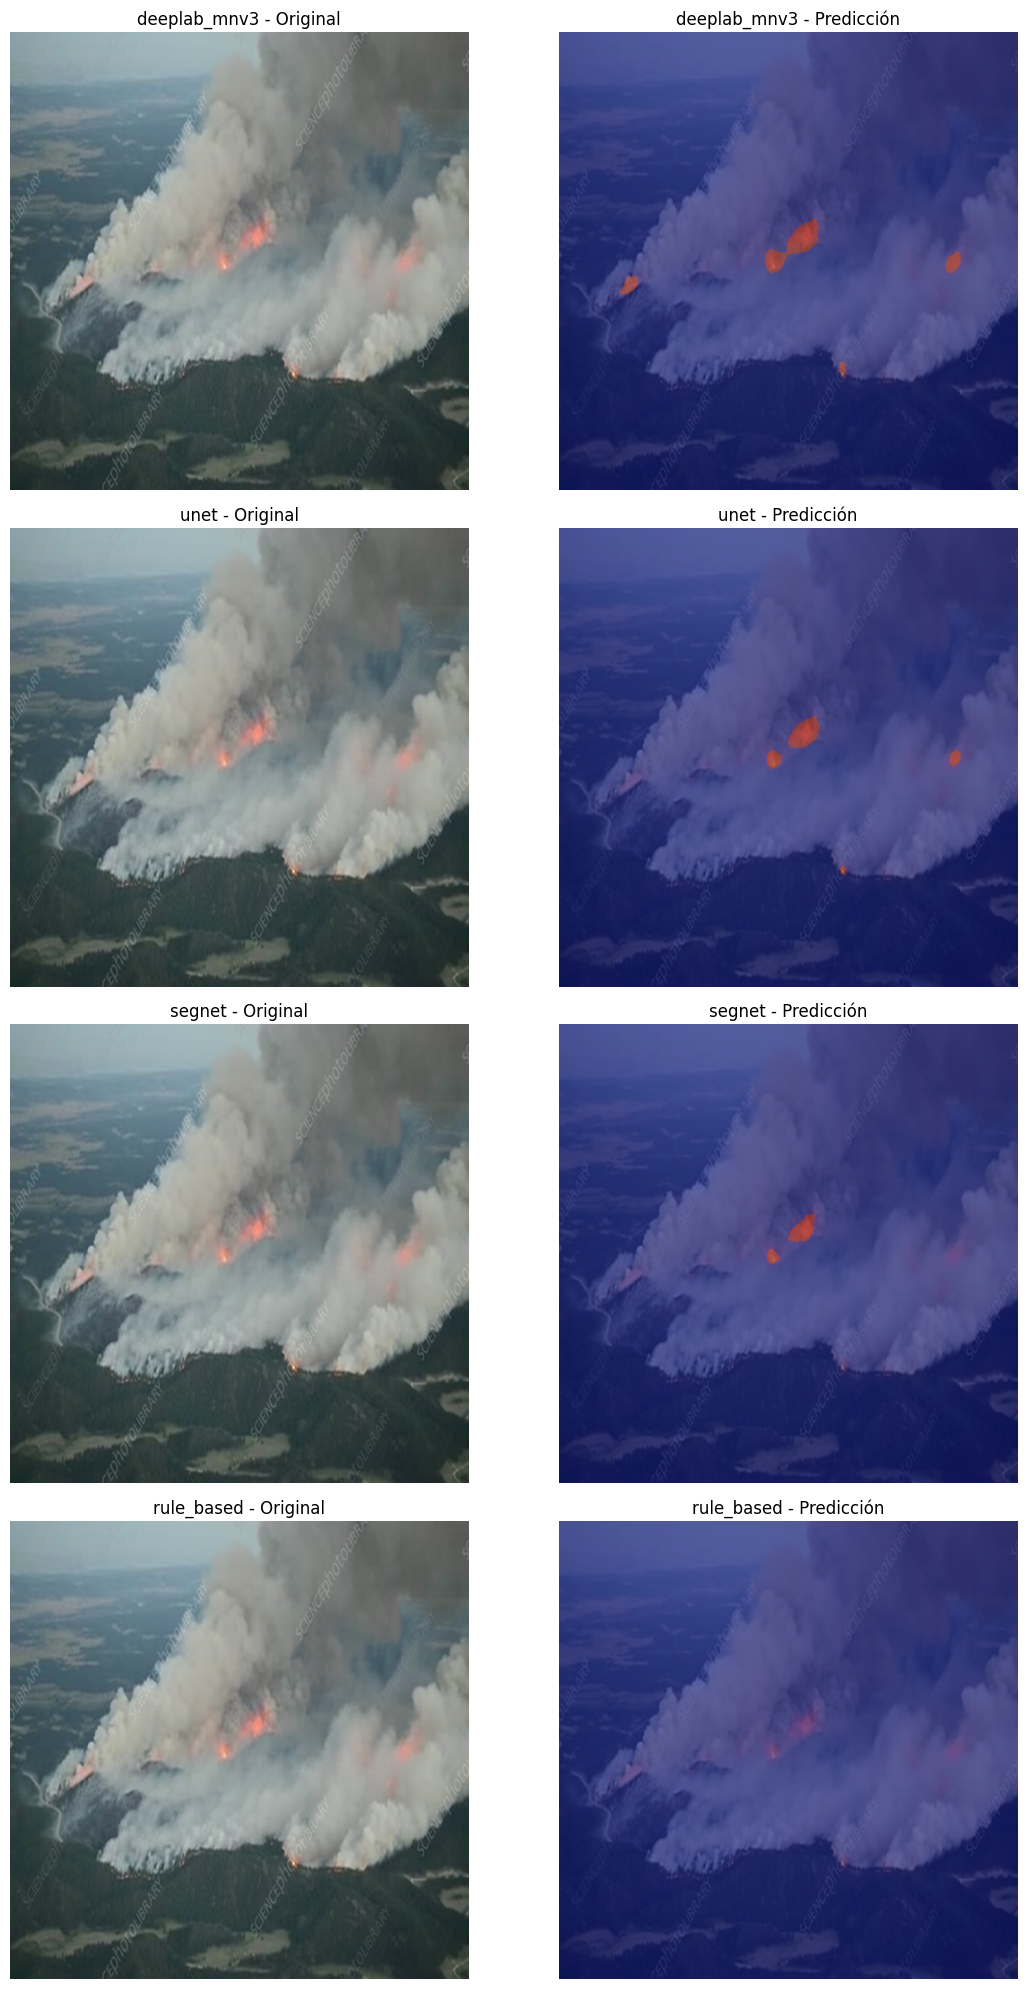

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


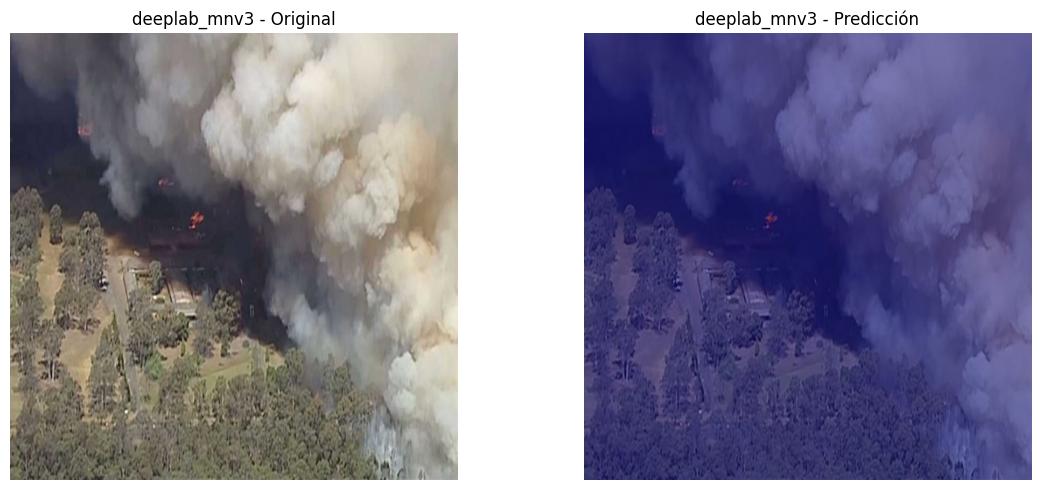

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input


def preprocess_image(img_path, input_shape=(512, 512)):

    with open(img_path, "rb") as f:
        img_bytes = f.read()
        img_data = BytesIO(img_bytes)
    img = Image.open(img_data).convert("RGB")

    # Redimensionar
    img = img.resize(input_shape)

    # Convertir a numpy
    img_array = np.array(img)

    # Preprocesamiento (igual que entrenamiento)
    img_array = preprocess_input(img_array)

    # Batch dimension
    img_input = np.expand_dims(img_array, axis=0)

    return img_array, img_input, np.array(img)

def predict_and_plot(img_path, models_info):

    img_array, img_input, img_disp = preprocess_image(img_path, (512, 512))

    fig, axes = plt.subplots(len(models_info), 2, figsize=(12, 5*len(models_info)))

    if len(models_info) == 1:  # si es un modelo, forzar axes en lista
        axes = [axes]

    for i, info in enumerate(models_info):
        model_name = info["name"]

        if model_name == "rule_based":
            pred_mask = rule_based_fire_mask(cv2.resize(img_disp, (512, 512)))
        else:
            model = get_model(model_name, input_shape=(512,512,3), num_classes=1)
            if model_name == "segnet":
                model.compile(jit_compile=False)
            model.load_weights(info["weights"])
            pred_mask = model.predict(img_input)[0, ..., 0]
            pred_mask = (pred_mask > 0.5).astype(np.uint8)


        axes[i][0].imshow(img_disp)
        axes[i][0].set_title(f"{model_name} - Original")
        axes[i][0].axis("off")


        axes[i][1].imshow(img_disp)
        axes[i][1].imshow(pred_mask, cmap="jet", alpha=0.5)
        axes[i][1].set_title(f"{model_name} - Predicción")
        axes[i][1].axis("off")

    plt.tight_layout()
    plt.show()


# Ejemplo de uso con varios modelos
models_to_test = [
    {"name": "deeplab_mnv3", "weights": "experiments/exp1_deeplab/best_model.keras"},
    {"name": "unet",         "weights": "experiments/exp2_unet/best_model.keras"},
    {"name": "segnet",       "weights": "experiments/exp3_segnet/best_model.keras"},
    {"name": "rule_based",   "weights": None}
]

predict_and_plot("800wm.jpeg", models_to_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 838ms/step


2025-10-07 22:46:57.950640: W tensorflow/core/common_runtime/optimize_function_graph_utils.cc:633] Ignoring multi-device function optimization failure: INVALID_ARGUMENT: Input 0 of node SegNet_Adapted_1/seg_net_max_pool_with_argmax_6_1/Cast was passed float from SegNet_Adapted_1/activation_114_1/Relu:0 incompatible with expected int64.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


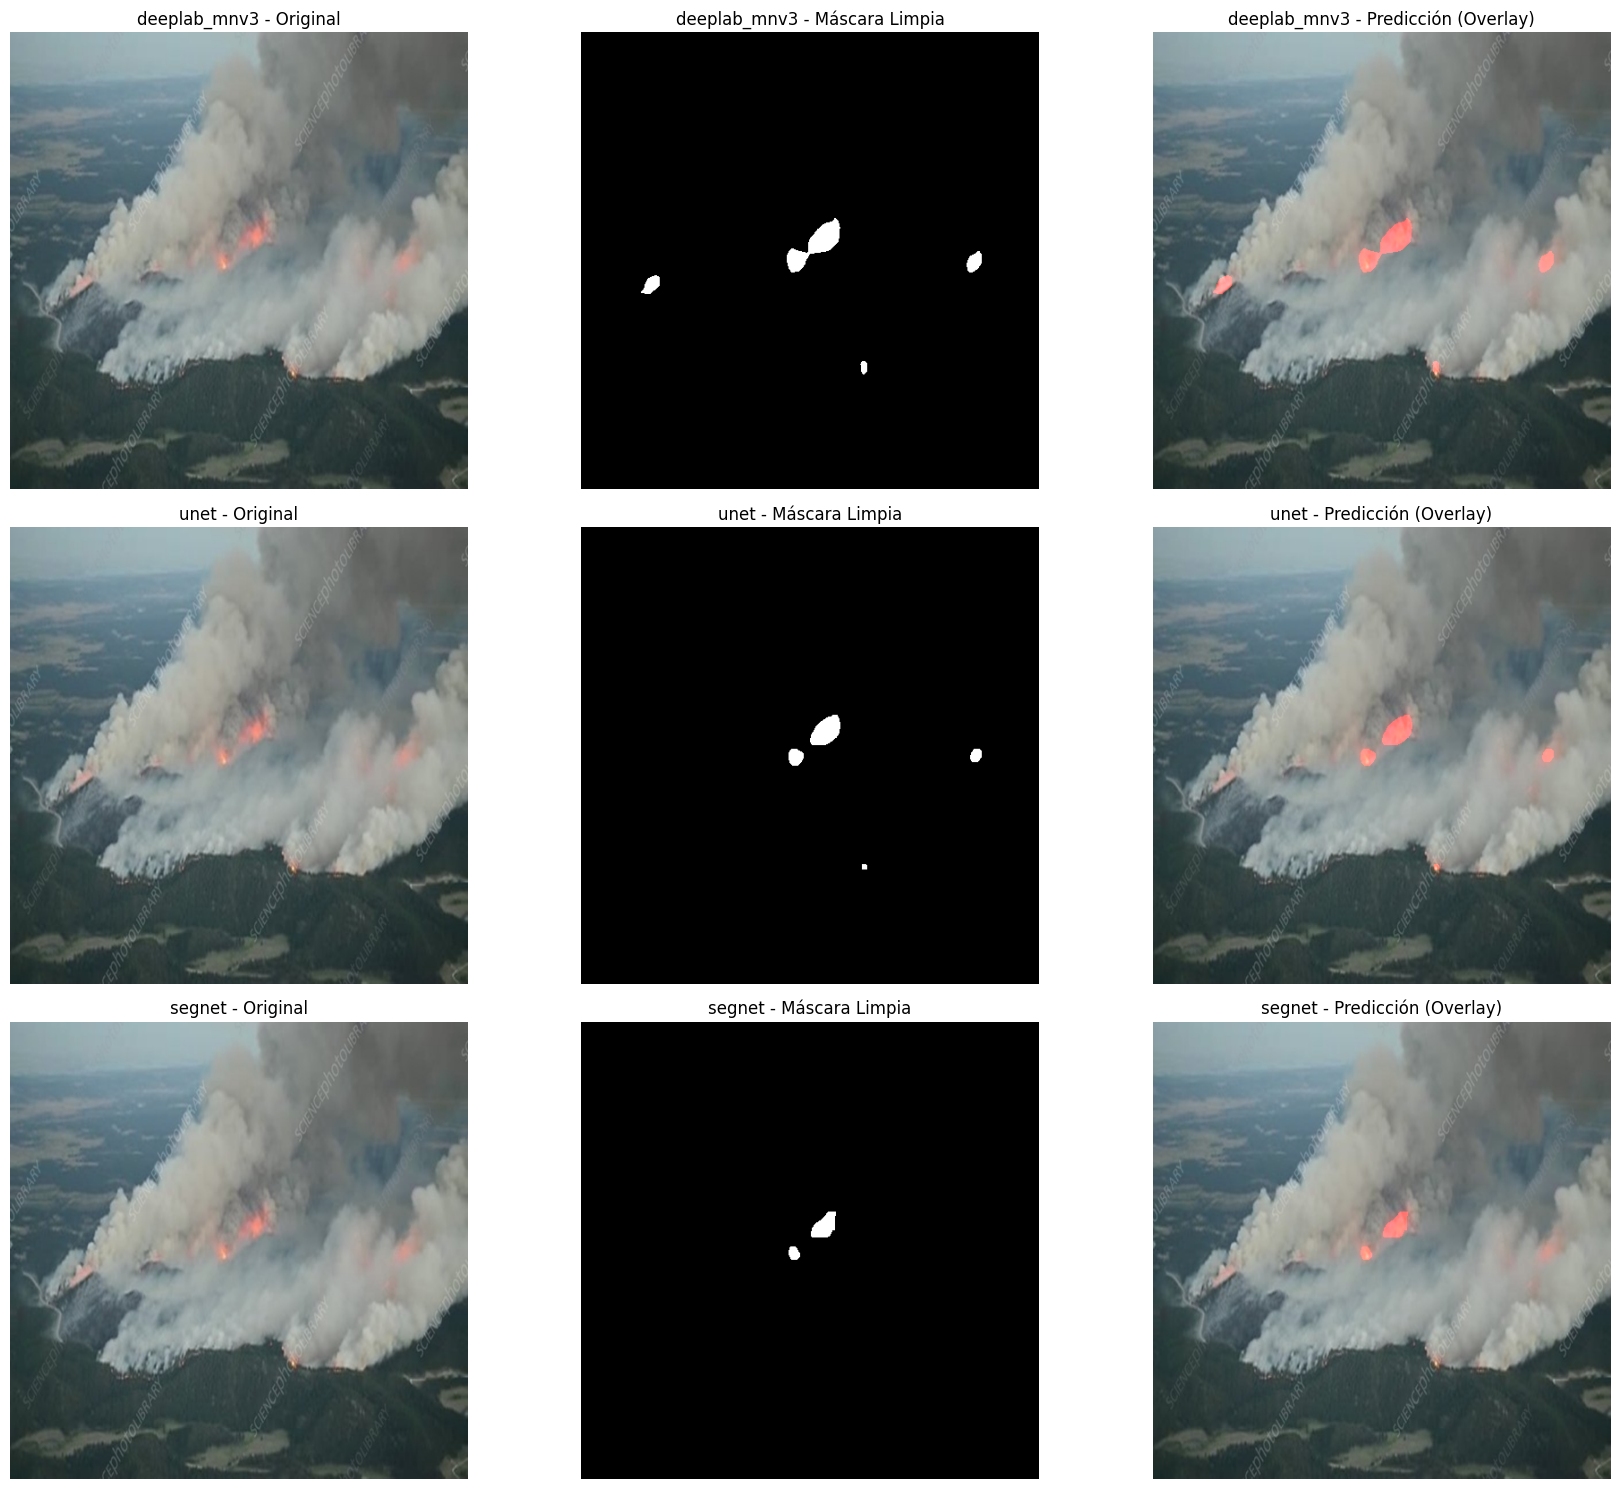

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input



def predict_and_plot(img_path, models_info):
    """
    Aplica modelos a una imagen, limpia el ruido para SegNet/U-Net,
    y grafica los resultados en tres columnas.
    """
    img_array, img_input, img_disp = preprocess_image(img_path, (512, 512))
    img_disp = np.ascontiguousarray(img_disp, dtype=np.uint8)

    # Ajusta los ejes si solo se prueba un modelo
    if len(models_info) == 1:
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        axes = [axes]
    else:
        fig, axes = plt.subplots(len(models_info), 3, figsize=(18, 5 * len(models_info)))

    for i, info in enumerate(models_info):
        model_name = info["name"]

        # --- OBTENER LA MÁSCARA PREDICHA ---
        if model_name == "rule_based":
            img_bgr = cv2.cvtColor(img_disp, cv2.COLOR_RGB2BGR)
            pred_mask = rule_based_fire_mask(img_bgr)
            pred_mask = (pred_mask > 0).astype(np.uint8)
        else:
            model = get_model(model_name, input_shape=(512, 512, 3), num_classes=1)
            if model_name == "segnet":
                model.compile(jit_compile=False)
            model.load_weights(info["weights"])
            pred_mask_raw = model.predict(img_input)[0, ..., 0]
            pred_mask = (pred_mask_raw > 0.5).astype(np.uint8)


        if model_name in ["segnet", "unet"]:
            kernel = np.ones((5, 5), np.uint8)

            cleaned_mask = cv2.morphologyEx(pred_mask, cv2.MORPH_OPEN, kernel)

            cleaned_mask = cv2.morphologyEx(cleaned_mask, cv2.MORPH_CLOSE, kernel)
        else:

            cleaned_mask = pred_mask



        # Columna 1: Imagen Original
        axes[i][0].imshow(img_disp)
        axes[i][0].set_title(f"{model_name} - Original")
        axes[i][0].axis("off")

        # Columna 2: Máscara Predicha (ya limpia para SegNet/U-Net)
        axes[i][1].imshow(cleaned_mask, cmap='gray')
        axes[i][1].set_title(f"{model_name} - Máscara Limpia")
        axes[i][1].axis("off")

        # Columna 3: Superposición (Overlay)
        overlay = img_disp.copy()
        red_mask_img = np.zeros_like(overlay)
        red_mask_img[cleaned_mask == 1] = [255, 0, 0]
        final_image = cv2.addWeighted(overlay, 1.0, red_mask_img, 0.5, 0)

        axes[i][2].imshow(final_image)
        axes[i][2].set_title(f"{model_name} - Predicción (Overlay)")
        axes[i][2].axis("off")

    plt.tight_layout()
    plt.show()


models_to_test = [
    {"name": "deeplab_mnv3", "weights": "experiments/exp1_deeplab/best_model.keras"},
    {"name": "unet",         "weights": "experiments/exp2_unet/best_model.keras"},
    {"name": "segnet",       "weights": "experiments/exp3_segnet/best_model.keras"},
]

predict_and_plot("800wm.jpeg", models_to_test)


Cargando modelo y pesos...


/home/ggomocio/fire_detection/entorno_tmp_2/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 352 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Modelo cargado.
Cargando y preprocesando imagen...
Imagen lista.
Realizando predicción...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step
Predicción completada.

--- ANÁLISIS DE LA PREDICCIÓN CRUDA ---
Valor MÁXIMO en la máscara de probabilidad: 1.0000
Valor PROMEDIO en la máscara de probabilidad: 0.0092
Valor MÍNIMO en la máscara de probabilidad: 0.0000
----------------------------------------



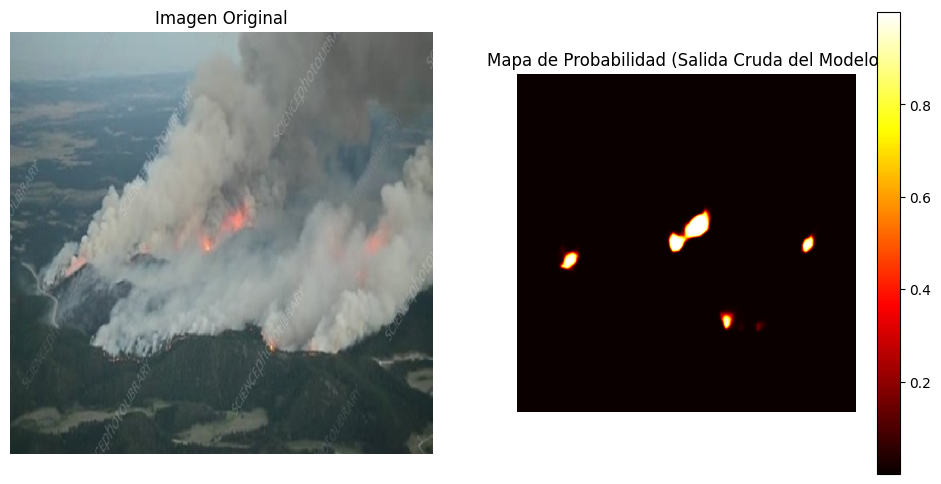

In [ ]:

MODEL_WEIGHTS_PATH = "experiments/exp1_deeplab/best_model.keras"
TEST_IMAGE_PATH = "800wm.jpeg" # O la imagen que prefieras probar
INPUT_SHAPE = (512, 512, 3)

# 1. Cargar el modelo
print("Cargando modelo y pesos...")
model = build_deeplab_mobilenetv3_paper(input_shape=INPUT_SHAPE)

# Compilar para desactivar el compilador XLA durante la predicción y evitar el error.
model.compile(jit_compile=False)

model.load_weights(MODEL_WEIGHTS_PATH)
print("Modelo cargado.")

# 2. Cargar y preprocesar la imagen de prueba
print("Cargando y preprocesando imagen...")
img = load_img(TEST_IMAGE_PATH, target_size=(INPUT_SHAPE[0], INPUT_SHAPE[1]))
img_array = img_to_array(img)
img_preprocessed = preprocess_input(img_array)
img_batch = np.expand_dims(img_preprocessed, axis=0)
print("Imagen lista.")

# 3. Realizar la predicción
print("Realizando predicción...")
prediction_raw = model.predict(img_batch)[0, ..., 0]
print("Predicción completada.")

# 4. ANALIZAR LA SALIDA CRUDA
min_val = np.min(prediction_raw)
max_val = np.max(prediction_raw)
mean_val = np.mean(prediction_raw)

print("\n--- ANÁLISIS DE LA PREDICCIÓN CRUDA ---")
print(f"Valor MÁXIMO en la máscara de probabilidad: {max_val:.4f}")
print(f"Valor PROMEDIO en la máscara de probabilidad: {mean_val:.4f}")
print(f"Valor MÍNIMO en la máscara de probabilidad: {min_val:.4f}")
print("----------------------------------------\n")

# 5. VISUALIZAR EL MAPA DE CALOR
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Imagen Original")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(prediction_raw, cmap='hot')
plt.title("Mapa de Probabilidad (Salida Cruda del Modelo)")
plt.colorbar()
plt.axis('off')

plt.show()

#Creacion de mejora de hiperparametros

In [ ]:
def augment(img, mask):
    # Volteo horizontal aleatorio (50% de probabilidad)
    if tf.random.uniform(()) > 0.5:
        img = tf.image.flip_left_right(img)
        mask = tf.image.flip_left_right(mask)

    # Ajustes de brillo aleatorios
    img = tf.image.random_brightness(img, max_delta=0.1)

    return img, mask


def create_dataset_data_augment(img_paths, mask_paths, img_size=(512,512), batch_size=8, is_training=False):
    def generator():
        for img_path, mask_path in zip(img_paths, mask_paths):
            img = img_to_array(load_img(img_path, target_size=img_size))
            mask = img_to_array(load_img(mask_path, color_mode="grayscale", target_size=img_size))
            mask = (mask > 0).astype("float32")
            img = preprocess_input(img)
            yield img, mask

    ds = tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            tf.TensorSpec(shape=(img_size[0], img_size[1], 3), dtype=tf.float32),
            tf.TensorSpec(shape=(img_size[0], img_size[1], 1), dtype=tf.float32)
        )
    )


    if is_training:
        ds = ds.shuffle(500).map(augment, num_parallel_calls=tf.data.AUTOTUNE)


    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [ ]:

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


def train_model_optimizado(model, train_ds, val_ds, exp_dir,
                epochs=50, monitor_metric="val_f1_score", monitor_mode="max", earlystop_patience=10):
    os.makedirs(exp_dir, exist_ok=True)

    checkpoint_cb = ModelCheckpoint(
        os.path.join(exp_dir, "best_model.keras"),
        monitor=monitor_metric,
        mode=monitor_mode,
        save_best_only=True
    )

    earlystop_cb = EarlyStopping(
        monitor=monitor_metric,
        mode=monitor_mode,
        patience=earlystop_patience,
        restore_best_weights=True
    )


    lr_scheduler_cb = ReduceLROnPlateau(
        monitor=monitor_metric,
        factor=0.2,
        patience=3,
        verbose=1,
        mode=monitor_mode,
        min_lr=1e-7
    )

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        verbose=1,

        callbacks=[checkpoint_cb, earlystop_cb, lr_scheduler_cb],
    )
    return history

#Prueba de optimiacion experimento V1

In [ ]:

def main_optimizacion(cfg):
    train_imgs, train_masks = get_image_mask_pairs(cfg.train)
    val_imgs, val_masks = get_image_mask_pairs(cfg.valid)
    test_imgs, test_masks = get_image_mask_pairs(cfg.test)


    train_ds = create_dataset_data_augment(train_imgs, train_masks, batch_size=cfg.batch_size, is_training=True)
    val_ds   = create_dataset_data_augment(val_imgs, val_masks, batch_size=cfg.batch_size, is_training=False)
    test_ds  = create_dataset_data_augment(test_imgs, test_masks, batch_size=cfg.batch_size, is_training=False)

    if cfg.model == "rule_based":
        from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score

        print("Ejecutando baseline basado en umbralización y reglas...")
        metrics = evaluate_rule_baseline(test_imgs, test_masks)
        history = None
        return history, metrics

        # Construir modelo según el nombre
    model = get_model(cfg.model, input_shape=(512,512,3), num_classes=1)
    optimizer = get_optimizer(cfg.optimizer, cfg.lr, cfg.optimizer_params)
    model.compile(
        optimizer=optimizer,
        loss=combo_loss(alpha=0.5, beta=0.5),
        metrics=[
                tf.keras.metrics.MeanIoU(num_classes=2, name="mean_iou"),
                tf.keras.metrics.Precision(name="precision"),
                tf.keras.metrics.Recall(name="recall"),
                F1Score(name="f1_score"),
                IoUBinary(name="iou_binary")
                ],
        jit_compile=False
    )


        # Entrenamiento
    history = train_model_optimizado(
    model,
    train_ds,
    val_ds,
    exp_dir=cfg.exp,
    epochs=cfg.epochs,
    monitor_metric=getattr(cfg, "monitor_metric", "val_mean_iou"),
    monitor_mode=getattr(cfg, "monitor_mode", "max"),
    earlystop_patience=getattr(cfg, "earlystop_patience", 50)
    )


        # Evaluación
    results = model.evaluate(test_ds, verbose=1, return_dict=True)
    metrics = results
    print("Métricas en el conjunto de prueba:" )
    print(metrics)
    return history, metrics

configs = [
    SimpleNamespace(
        model="deeplab_mnv3",
        train="fire-semantic-1/train",
        valid="fire-semantic-1/valid",
        test="fire-semantic-1/test",
        batch_size=16,
        epochs=100,
        lr=1e-3,
        optimizer="adamw",
        optimizer_params={"weight_decay": 1e-5}, # Parámetro para AdamW
        exp="experiments/exp_deeplab_optimized_v1", #
        monitor_metric="val_f1_score",
        monitor_mode="max",
        earlystop_patience=15
    )
]


for cfg in configs:
    print(f"\n=== Ejecutando experimento: {cfg.model} ({cfg.exp}) ===")
    history, metrics = main_optimizacion(cfg)


    if history is not None:
        save_history(history, os.path.join(cfg.exp, "history.csv"))


    os.makedirs(cfg.exp, exist_ok=True)
    with open(os.path.join(cfg.exp, "results.json"), "w") as f:
        json.dump(metrics, f)

    print("Resultados finales:", metrics)
    clear_memory()


=== Ejecutando experimento: deeplab_mnv3 (experiments/exp_deeplab_optimized_v1) ===
Epoch 1/100


KeyboardInterrupt: 

Cargando modelo y pesos...


/home/ggomocio/fire_detection/entorno_tmp_2/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 416 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Modelo cargado.
Cargando y preprocesando imagen...
Imagen lista.
Realizando predicción...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 829ms/step
Predicción completada.

--- ANÁLISIS DE LA PREDICCIÓN CRUDA ---
Valor MÁXIMO en la máscara de probabilidad: 1.0000
Valor PROMEDIO en la máscara de probabilidad: 0.0060
Valor MÍNIMO en la máscara de probabilidad: 0.0000
----------------------------------------



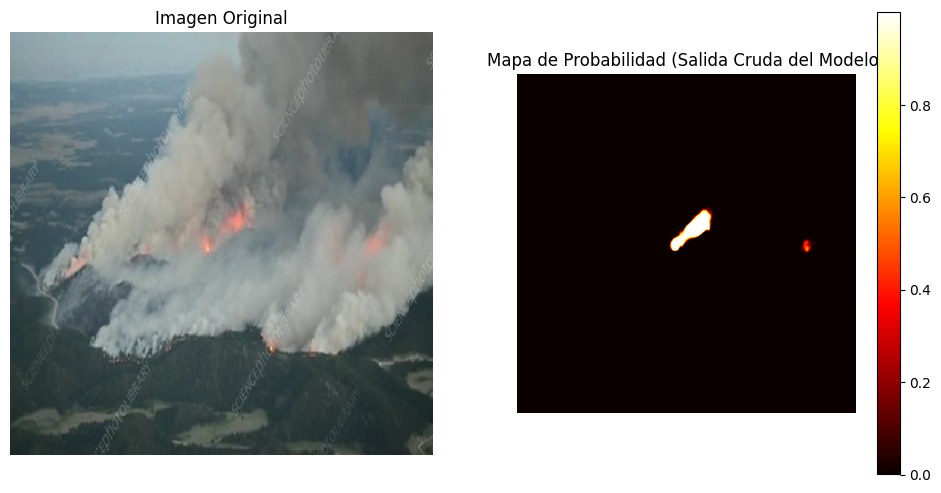

In [ ]:
MODEL_WEIGHTS_PATH = "experiments/exp_deeplab_optimized_v6/best_model.keras"
TEST_IMAGE_PATH = "800wm.jpeg"
INPUT_SHAPE = (512, 512, 3)

# 1. Cargar el modelo
print("Cargando modelo y pesos...")
model = build_deeplab_mobilenetv3_paper(input_shape=INPUT_SHAPE)


model.compile(jit_compile=False)

model.load_weights(MODEL_WEIGHTS_PATH)
print("Modelo cargado.")

# 2. Cargar y preprocesar la imagen de prueba
print("Cargando y preprocesando imagen...")
img = load_img(TEST_IMAGE_PATH, target_size=(INPUT_SHAPE[0], INPUT_SHAPE[1]))
img_array = img_to_array(img)
img_preprocessed = preprocess_input(img_array)
img_batch = np.expand_dims(img_preprocessed, axis=0)
print("Imagen lista.")

# 3. Realizar la predicción
print("Realizando predicción...")
prediction_raw = model.predict(img_batch)[0, ..., 0]
print("Predicción completada.")

# 4. ANALIZAR LA SALIDA CRUDA
min_val = np.min(prediction_raw)
max_val = np.max(prediction_raw)
mean_val = np.mean(prediction_raw)

print("\n--- ANÁLISIS DE LA PREDICCIÓN CRUDA ---")
print(f"Valor MÁXIMO en la máscara de probabilidad: {max_val:.4f}")
print(f"Valor PROMEDIO en la máscara de probabilidad: {mean_val:.4f}")
print(f"Valor MÍNIMO en la máscara de probabilidad: {min_val:.4f}")
print("----------------------------------------\n")

# 5. VISUALIZAR EL MAPA DE CALOR
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Imagen Original")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(prediction_raw, cmap='hot')
plt.title("Mapa de Probabilidad (Salida Cruda del Modelo)")
plt.colorbar()
plt.axis('off')

plt.show()

#Prueba de optimiacion experimento V2

In [ ]:

def main_optimizacion(cfg):
    train_imgs, train_masks = get_image_mask_pairs(cfg.train)
    val_imgs, val_masks = get_image_mask_pairs(cfg.valid)
    test_imgs, test_masks = get_image_mask_pairs(cfg.test)


    train_ds = create_dataset_data_augment(train_imgs, train_masks, batch_size=cfg.batch_size, is_training=True)
    val_ds   = create_dataset_data_augment(val_imgs, val_masks, batch_size=cfg.batch_size, is_training=False)
    test_ds  = create_dataset_data_augment(test_imgs, test_masks, batch_size=cfg.batch_size, is_training=False)

    if cfg.model == "rule_based":
        from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score

        print("Ejecutando baseline basado en umbralización y reglas...")
        metrics = evaluate_rule_baseline(test_imgs, test_masks)
        history = None
        return history, metrics

        # Construir modelo según el nombre
    model = get_model(cfg.model, input_shape=(512,512,3), num_classes=1)
    optimizer = get_optimizer(cfg.optimizer, cfg.lr, cfg.optimizer_params)
    model.compile(
        optimizer=optimizer,
        loss=combo_loss(alpha=0.3, beta=0.7),
        metrics=[
                tf.keras.metrics.MeanIoU(num_classes=2, name="mean_iou"),
                tf.keras.metrics.Precision(name="precision"),
                tf.keras.metrics.Recall(name="recall"),
                F1Score(name="f1_score"),
                IoUBinary(name="iou_binary")
                ],
        jit_compile=False
    )


        # Entrenamiento
    history = train_model_optimizado(
    model,
    train_ds,
    val_ds,
    exp_dir=cfg.exp,
    epochs=cfg.epochs,
    monitor_metric=getattr(cfg, "monitor_metric", "val_mean_iou"),
    monitor_mode=getattr(cfg, "monitor_mode", "max"),
    earlystop_patience=getattr(cfg, "earlystop_patience", 50)
    )

    results = model.evaluate(test_ds, verbose=1, return_dict=True)
    metrics = results
    print("Métricas en el conjunto de prueba:" )
    print(metrics)
    return history, metrics

configs = [
    SimpleNamespace(
        model="deeplab_mnv3",
        train="fire-semantic-1/train",
        valid="fire-semantic-1/valid",
        test="fire-semantic-1/test",
        batch_size=16,
        epochs=100,
        lr=1e-3,
        optimizer="adamw",
        optimizer_params={"weight_decay": 1e-5},
        exp="experiments/exp_deeplab_optimized_v2",
        monitor_metric="val_f1_score",
        monitor_mode="max",
        earlystop_patience=15
    )
]


for cfg in configs:
    print(f"\n=== Ejecutando experimento: {cfg.model} ({cfg.exp}) ===")
    history, metrics = main_optimizacion(cfg)


    if history is not None:
        save_history(history, os.path.join(cfg.exp, "history.csv"))

    # Guardar métricas
    os.makedirs(cfg.exp, exist_ok=True)
    with open(os.path.join(cfg.exp, "results.json"), "w") as f:
        json.dump(metrics, f)

    print("Resultados finales:", metrics)
    clear_memory()


=== Ejecutando experimento: deeplab_mnv3 (experiments/exp_deeplab_optimized_v2) ===
Epoch 1/100
    135/Unknown 69s 340ms/step - f1_score: 0.4566 - iou_binary: 0.2987 - loss: 0.5347 - mean_iou: 0.5843 - precision: 0.3381 - recall: 0.7629

2025-10-07 23:43:45.741139: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712
2025-10-07 23:43:56.297858: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 80s 424ms/step - f1_score: 0.5609 - iou_binary: 0.3897 - loss: 0.4217 - mean_iou: 0.5679 - precision: 0.4729 - recall: 0.6890 - val_f1_score: 0.0000e+00 - val_iou_binary: 1.6373e-14 - val_loss: 0.7250 - val_mean_iou: 0.4811 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - f1_score: 0.7138 - iou_binary: 0.5553 - loss: 0.2898 - mean_iou: 0.5332 - precision: 0.7215 - recall: 0.7077

2025-10-07 23:44:52.787829: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712
2025-10-07 23:45:02.985804: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 67s 421ms/step - f1_score: 0.7278 - iou_binary: 0.5721 - loss: 0.2814 - mean_iou: 0.5154 - precision: 0.7372 - recall: 0.7187 - val_f1_score: 0.2793 - val_iou_binary: 0.1623 - val_loss: 0.5535 - val_mean_iou: 0.4811 - val_precision: 0.9330 - val_recall: 0.1642 - learning_rate: 0.0010
Epoch 3/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - f1_score: 0.7714 - iou_binary: 0.6281 - loss: 0.2338 - mean_iou: 0.5184 - precision: 0.7664 - recall: 0.7767

2025-10-07 23:45:57.970188: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712
2025-10-07 23:46:08.309878: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 65s 423ms/step - f1_score: 0.7648 - iou_binary: 0.6191 - loss: 0.2393 - mean_iou: 0.5034 - precision: 0.7609 - recall: 0.7687 - val_f1_score: 0.6978 - val_iou_binary: 0.5358 - val_loss: 0.3265 - val_mean_iou: 0.4813 - val_precision: 0.7864 - val_recall: 0.6271 - learning_rate: 0.0010
Epoch 4/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - f1_score: 0.7841 - iou_binary: 0.6451 - loss: 0.2158 - mean_iou: 0.4952 - precision: 0.7869 - recall: 0.7816

2025-10-07 23:47:03.358325: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712


135/135 ━━━━━━━━━━━━━━━━━━━━ 65s 418ms/step - f1_score: 0.7656 - iou_binary: 0.6203 - loss: 0.2281 - mean_iou: 0.4940 - precision: 0.7798 - recall: 0.7519 - val_f1_score: 0.6908 - val_iou_binary: 0.5276 - val_loss: 0.3421 - val_mean_iou: 0.5205 - val_precision: 0.6936 - val_recall: 0.6879 - learning_rate: 0.0010
Epoch 5/100


2025-10-07 23:47:13.724687: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - f1_score: 0.7948 - iou_binary: 0.6595 - loss: 0.2041 - mean_iou: 0.4998 - precision: 0.7826 - recall: 0.8078

2025-10-07 23:48:08.901260: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712


135/135 ━━━━━━━━━━━━━━━━━━━━ 66s 424ms/step - f1_score: 0.7895 - iou_binary: 0.6522 - loss: 0.2087 - mean_iou: 0.4961 - precision: 0.7912 - recall: 0.7878 - val_f1_score: 0.6601 - val_iou_binary: 0.4927 - val_loss: 0.3919 - val_mean_iou: 0.4953 - val_precision: 0.7922 - val_recall: 0.5658 - learning_rate: 0.0010
Epoch 6/100


2025-10-07 23:48:19.275613: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - f1_score: 0.8026 - iou_binary: 0.6706 - loss: 0.1961 - mean_iou: 0.4934 - precision: 0.8031 - recall: 0.8026

2025-10-07 23:49:14.154319: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712


135/135 ━━━━━━━━━━━━━━━━━━━━ 65s 415ms/step - f1_score: 0.7957 - iou_binary: 0.6607 - loss: 0.2007 - mean_iou: 0.4904 - precision: 0.8066 - recall: 0.7851 - val_f1_score: 0.6518 - val_iou_binary: 0.4834 - val_loss: 0.3764 - val_mean_iou: 0.5062 - val_precision: 0.7909 - val_recall: 0.5543 - learning_rate: 0.0010
Epoch 7/100


2025-10-07 23:49:24.047252: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - f1_score: 0.8088 - iou_binary: 0.6792 - loss: 0.1879 - mean_iou: 0.4898 - precision: 0.8059 - recall: 0.8126

2025-10-07 23:50:19.300110: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712


135/135 ━━━━━━━━━━━━━━━━━━━━ 66s 426ms/step - f1_score: 0.8031 - iou_binary: 0.6710 - loss: 0.1938 - mean_iou: 0.4847 - precision: 0.8116 - recall: 0.7948 - val_f1_score: 0.5782 - val_iou_binary: 0.4067 - val_loss: 0.4189 - val_mean_iou: 0.4857 - val_precision: 0.8879 - val_recall: 0.4287 - learning_rate: 0.0010
Epoch 8/100


2025-10-07 23:50:29.818098: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - f1_score: 0.8312 - iou_binary: 0.7115 - loss: 0.1676 - mean_iou: 0.4954 - precision: 0.8264 - recall: 0.8366

2025-10-07 23:51:23.639223: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712



Epoch 8: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
135/135 ━━━━━━━━━━━━━━━━━━━━ 64s 417ms/step - f1_score: 0.8165 - iou_binary: 0.6900 - loss: 0.1825 - mean_iou: 0.4929 - precision: 0.8190 - recall: 0.8141 - val_f1_score: 0.6888 - val_iou_binary: 0.5253 - val_loss: 0.3001 - val_mean_iou: 0.4844 - val_precision: 0.8556 - val_recall: 0.5764 - learning_rate: 0.0010
Epoch 9/100


2025-10-07 23:51:34.167140: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - f1_score: 0.8376 - iou_binary: 0.7209 - loss: 0.1598 - mean_iou: 0.4841 - precision: 0.8318 - recall: 0.8440

2025-10-07 23:52:28.395894: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712


135/135 ━━━━━━━━━━━━━━━━━━━━ 64s 415ms/step - f1_score: 0.8425 - iou_binary: 0.7279 - loss: 0.1568 - mean_iou: 0.4826 - precision: 0.8495 - recall: 0.8357 - val_f1_score: 0.6532 - val_iou_binary: 0.4850 - val_loss: 0.3218 - val_mean_iou: 0.4813 - val_precision: 0.9095 - val_recall: 0.5097 - learning_rate: 2.0000e-04
Epoch 10/100


2025-10-07 23:52:38.244065: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - f1_score: 0.8577 - iou_binary: 0.7510 - loss: 0.1422 - mean_iou: 0.4856 - precision: 0.8559 - recall: 0.8600

2025-10-07 23:53:32.755703: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712


135/135 ━━━━━━━━━━━━━━━━━━━━ 65s 422ms/step - f1_score: 0.8514 - iou_binary: 0.7412 - loss: 0.1497 - mean_iou: 0.4836 - precision: 0.8580 - recall: 0.8449 - val_f1_score: 0.6961 - val_iou_binary: 0.5339 - val_loss: 0.2855 - val_mean_iou: 0.4813 - val_precision: 0.8944 - val_recall: 0.5698 - learning_rate: 2.0000e-04
Epoch 11/100


2025-10-07 23:53:43.374453: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - f1_score: 0.8620 - iou_binary: 0.7575 - loss: 0.1390 - mean_iou: 0.4846 - precision: 0.8640 - recall: 0.8603

2025-10-07 23:54:39.889594: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712
2025-10-07 23:54:49.404637: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 67s 424ms/step - f1_score: 0.8576 - iou_binary: 0.7508 - loss: 0.1418 - mean_iou: 0.4825 - precision: 0.8680 - recall: 0.8475 - val_f1_score: 0.7269 - val_iou_binary: 0.5709 - val_loss: 0.2568 - val_mean_iou: 0.4814 - val_precision: 0.8707 - val_recall: 0.6238 - learning_rate: 2.0000e-04
Epoch 12/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - f1_score: 0.8696 - iou_binary: 0.7693 - loss: 0.1318 - mean_iou: 0.4846 - precision: 0.8683 - recall: 0.8710

2025-10-07 23:55:44.638142: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712
2025-10-07 23:55:55.178614: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 66s 427ms/step - f1_score: 0.8662 - iou_binary: 0.7640 - loss: 0.1345 - mean_iou: 0.4831 - precision: 0.8726 - recall: 0.8599 - val_f1_score: 0.7307 - val_iou_binary: 0.5757 - val_loss: 0.2534 - val_mean_iou: 0.4813 - val_precision: 0.8599 - val_recall: 0.6353 - learning_rate: 2.0000e-04
Epoch 13/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - f1_score: 0.8746 - iou_binary: 0.7772 - loss: 0.1284 - mean_iou: 0.4841 - precision: 0.8741 - recall: 0.8753

2025-10-07 23:56:50.086832: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712
2025-10-07 23:57:00.727713: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 66s 422ms/step - f1_score: 0.8709 - iou_binary: 0.7713 - loss: 0.1321 - mean_iou: 0.4830 - precision: 0.8795 - recall: 0.8624 - val_f1_score: 0.7541 - val_iou_binary: 0.6053 - val_loss: 0.2306 - val_mean_iou: 0.4815 - val_precision: 0.8387 - val_recall: 0.6850 - learning_rate: 2.0000e-04
Epoch 14/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - f1_score: 0.8797 - iou_binary: 0.7853 - loss: 0.1296 - mean_iou: 0.4835 - precision: 0.8764 - recall: 0.8831

2025-10-07 23:57:58.382404: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712
2025-10-07 23:58:08.500507: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 68s 432ms/step - f1_score: 0.8730 - iou_binary: 0.7746 - loss: 0.1345 - mean_iou: 0.4823 - precision: 0.8774 - recall: 0.8686 - val_f1_score: 0.7591 - val_iou_binary: 0.6117 - val_loss: 0.2293 - val_mean_iou: 0.4814 - val_precision: 0.8421 - val_recall: 0.6910 - learning_rate: 2.0000e-04
Epoch 15/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - f1_score: 0.8843 - iou_binary: 0.7927 - loss: 0.1187 - mean_iou: 0.4829 - precision: 0.8835 - recall: 0.8854

2025-10-07 23:59:04.245337: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712
2025-10-07 23:59:14.429763: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 66s 421ms/step - f1_score: 0.8778 - iou_binary: 0.7822 - loss: 0.1259 - mean_iou: 0.4825 - precision: 0.8824 - recall: 0.8732 - val_f1_score: 0.7615 - val_iou_binary: 0.6149 - val_loss: 0.2250 - val_mean_iou: 0.4816 - val_precision: 0.8343 - val_recall: 0.7005 - learning_rate: 2.0000e-04
Epoch 16/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - f1_score: 0.8811 - iou_binary: 0.7875 - loss: 0.1187 - mean_iou: 0.4855 - precision: 0.8738 - recall: 0.8886

2025-10-08 00:00:10.139396: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712
2025-10-08 00:00:20.771277: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 66s 425ms/step - f1_score: 0.8816 - iou_binary: 0.7883 - loss: 0.1194 - mean_iou: 0.4830 - precision: 0.8866 - recall: 0.8767 - val_f1_score: 0.7702 - val_iou_binary: 0.6263 - val_loss: 0.2172 - val_mean_iou: 0.4816 - val_precision: 0.7812 - val_recall: 0.7595 - learning_rate: 2.0000e-04
Epoch 17/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - f1_score: 0.8868 - iou_binary: 0.7966 - loss: 0.1172 - mean_iou: 0.4837 - precision: 0.8741 - recall: 0.9002

2025-10-08 00:01:15.785475: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712
2025-10-08 00:01:26.202516: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 65s 421ms/step - f1_score: 0.8835 - iou_binary: 0.7914 - loss: 0.1211 - mean_iou: 0.4826 - precision: 0.8857 - recall: 0.8813 - val_f1_score: 0.7704 - val_iou_binary: 0.6265 - val_loss: 0.2191 - val_mean_iou: 0.4816 - val_precision: 0.8052 - val_recall: 0.7384 - learning_rate: 2.0000e-04
Epoch 18/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - f1_score: 0.8878 - iou_binary: 0.7982 - loss: 0.1133 - mean_iou: 0.4847 - precision: 0.8858 - recall: 0.8899

2025-10-08 00:02:21.764433: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712


135/135 ━━━━━━━━━━━━━━━━━━━━ 65s 413ms/step - f1_score: 0.8828 - iou_binary: 0.7902 - loss: 0.1194 - mean_iou: 0.4831 - precision: 0.8879 - recall: 0.8778 - val_f1_score: 0.7694 - val_iou_binary: 0.6252 - val_loss: 0.2156 - val_mean_iou: 0.4815 - val_precision: 0.7843 - val_recall: 0.7549 - learning_rate: 2.0000e-04
Epoch 19/100


2025-10-08 00:02:31.405542: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - f1_score: 0.8887 - iou_binary: 0.7998 - loss: 0.1156 - mean_iou: 0.4861 - precision: 0.8835 - recall: 0.8943

2025-10-08 00:03:26.271117: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712


135/135 ━━━━━━━━━━━━━━━━━━━━ 65s 418ms/step - f1_score: 0.8884 - iou_binary: 0.7991 - loss: 0.1167 - mean_iou: 0.4837 - precision: 0.8918 - recall: 0.8849 - val_f1_score: 0.7649 - val_iou_binary: 0.6193 - val_loss: 0.2233 - val_mean_iou: 0.4816 - val_precision: 0.8051 - val_recall: 0.7285 - learning_rate: 2.0000e-04
Epoch 20/100


2025-10-08 00:03:35.924018: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - f1_score: 0.8933 - iou_binary: 0.8073 - loss: 0.1113 - mean_iou: 0.4843 - precision: 0.8853 - recall: 0.9016

2025-10-08 00:04:29.750299: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712
2025-10-08 00:04:39.357815: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 64s 414ms/step - f1_score: 0.8892 - iou_binary: 0.8006 - loss: 0.1157 - mean_iou: 0.4834 - precision: 0.8913 - recall: 0.8872 - val_f1_score: 0.7715 - val_iou_binary: 0.6279 - val_loss: 0.2165 - val_mean_iou: 0.4819 - val_precision: 0.8053 - val_recall: 0.7404 - learning_rate: 2.0000e-04
Epoch 21/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - f1_score: 0.8974 - iou_binary: 0.8140 - loss: 0.1060 - mean_iou: 0.4849 - precision: 0.8996 - recall: 0.8953

2025-10-08 00:05:34.991225: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712
2025-10-08 00:05:45.625360: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4432914994822983950
2025-10-08 00:05:45.625384: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13930264515029039954
2025-10-08 00:05:45.625388: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703
2025-10-08 00:05:45.625392: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14740773709716504793
2025-10-08 00:05:45.625395: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16857580629513321091


135/135 ━━━━━━━━━━━━━━━━━━━━ 66s 425ms/step - f1_score: 0.8934 - iou_binary: 0.8073 - loss: 0.1091 - mean_iou: 0.4835 - precision: 0.8971 - recall: 0.8897 - val_f1_score: 0.7723 - val_iou_binary: 0.6291 - val_loss: 0.2130 - val_mean_iou: 0.4820 - val_precision: 0.8063 - val_recall: 0.7410 - learning_rate: 2.0000e-04
Epoch 22/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - f1_score: 0.9016 - iou_binary: 0.8209 - loss: 0.1022 - mean_iou: 0.4859 - precision: 0.8997 - recall: 0.9035

2025-10-08 00:06:40.727259: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712
2025-10-08 00:06:40.727697: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2025-10-08 00:06:50.381375: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 65s 419ms/step - f1_score: 0.8962 - iou_binary: 0.8120 - loss: 0.1074 - mean_iou: 0.4837 - precision: 0.8998 - recall: 0.8927 - val_f1_score: 0.7726 - val_iou_binary: 0.6295 - val_loss: 0.2124 - val_mean_iou: 0.4819 - val_precision: 0.7769 - val_recall: 0.7683 - learning_rate: 2.0000e-04
Epoch 23/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - f1_score: 0.8987 - iou_binary: 0.8160 - loss: 0.1069 - mean_iou: 0.4844 - precision: 0.8933 - recall: 0.9042

2025-10-08 00:07:46.368265: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712
2025-10-08 00:07:56.561063: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 66s 429ms/step - f1_score: 0.8987 - iou_binary: 0.8160 - loss: 0.1078 - mean_iou: 0.4832 - precision: 0.8984 - recall: 0.8989 - val_f1_score: 0.7731 - val_iou_binary: 0.6301 - val_loss: 0.2110 - val_mean_iou: 0.4831 - val_precision: 0.7669 - val_recall: 0.7793 - learning_rate: 2.0000e-04
Epoch 24/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - f1_score: 0.9046 - iou_binary: 0.8260 - loss: 0.1002 - mean_iou: 0.4857 - precision: 0.8999 - recall: 0.9095

2025-10-08 00:08:51.558760: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712


135/135 ━━━━━━━━━━━━━━━━━━━━ 65s 416ms/step - f1_score: 0.9004 - iou_binary: 0.8188 - loss: 0.1058 - mean_iou: 0.4848 - precision: 0.9010 - recall: 0.8997 - val_f1_score: 0.7708 - val_iou_binary: 0.6271 - val_loss: 0.2131 - val_mean_iou: 0.4824 - val_precision: 0.7873 - val_recall: 0.7550 - learning_rate: 2.0000e-04
Epoch 25/100


2025-10-08 00:09:01.889696: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - f1_score: 0.9003 - iou_binary: 0.8187 - loss: 0.1015 - mean_iou: 0.4870 - precision: 0.8956 - recall: 0.9051

2025-10-08 00:09:57.299486: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712
2025-10-08 00:10:07.486198: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 66s 425ms/step - f1_score: 0.8998 - iou_binary: 0.8178 - loss: 0.1041 - mean_iou: 0.4843 - precision: 0.9022 - recall: 0.8973 - val_f1_score: 0.7732 - val_iou_binary: 0.6303 - val_loss: 0.2127 - val_mean_iou: 0.4827 - val_precision: 0.7875 - val_recall: 0.7594 - learning_rate: 2.0000e-04
Epoch 26/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - f1_score: 0.9095 - iou_binary: 0.8342 - loss: 0.0950 - mean_iou: 0.4841 - precision: 0.9061 - recall: 0.9130

2025-10-08 00:11:01.858766: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712


135/135 ━━━━━━━━━━━━━━━━━━━━ 64s 414ms/step - f1_score: 0.9033 - iou_binary: 0.8237 - loss: 0.1012 - mean_iou: 0.4838 - precision: 0.9055 - recall: 0.9012 - val_f1_score: 0.7651 - val_iou_binary: 0.6196 - val_loss: 0.2175 - val_mean_iou: 0.4825 - val_precision: 0.7622 - val_recall: 0.7681 - learning_rate: 2.0000e-04
Epoch 27/100


2025-10-08 00:11:11.590933: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - f1_score: 0.9061 - iou_binary: 0.8283 - loss: 0.0964 - mean_iou: 0.4858 - precision: 0.8971 - recall: 0.9153

2025-10-08 00:12:03.004609: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712


135/135 ━━━━━━━━━━━━━━━━━━━━ 61s 411ms/step - f1_score: 0.9057 - iou_binary: 0.8276 - loss: 0.0987 - mean_iou: 0.4844 - precision: 0.9053 - recall: 0.9061 - val_f1_score: 0.7710 - val_iou_binary: 0.6274 - val_loss: 0.2120 - val_mean_iou: 0.4827 - val_precision: 0.7633 - val_recall: 0.7789 - learning_rate: 2.0000e-04
Epoch 28/100


2025-10-08 00:12:12.808876: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - f1_score: 0.9100 - iou_binary: 0.8349 - loss: 0.0943 - mean_iou: 0.4857 - precision: 0.9050 - recall: 0.9151

2025-10-08 00:13:08.060856: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712
2025-10-08 00:13:18.753450: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4432914994822983950
2025-10-08 00:13:18.753483: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13930264515029039954
2025-10-08 00:13:18.753494: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703
2025-10-08 00:13:18.753502: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14740773709716504793
2025-10-08 00:13:18.753508: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16857580629513321091


135/135 ━━━━━━━━━━━━━━━━━━━━ 67s 425ms/step - f1_score: 0.9062 - iou_binary: 0.8285 - loss: 0.0976 - mean_iou: 0.4859 - precision: 0.9053 - recall: 0.9071 - val_f1_score: 0.7733 - val_iou_binary: 0.6304 - val_loss: 0.2094 - val_mean_iou: 0.4832 - val_precision: 0.7924 - val_recall: 0.7551 - learning_rate: 2.0000e-04
Epoch 29/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - f1_score: 0.9126 - iou_binary: 0.8393 - loss: 0.0909 - mean_iou: 0.4863 - precision: 0.9099 - recall: 0.9154

2025-10-08 00:14:14.437465: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712


135/135 ━━━━━━━━━━━━━━━━━━━━ 65s 421ms/step - f1_score: 0.9094 - iou_binary: 0.8339 - loss: 0.0954 - mean_iou: 0.4857 - precision: 0.9103 - recall: 0.9086 - val_f1_score: 0.7705 - val_iou_binary: 0.6267 - val_loss: 0.2121 - val_mean_iou: 0.4834 - val_precision: 0.7822 - val_recall: 0.7592 - learning_rate: 2.0000e-04
Epoch 30/100


2025-10-08 00:14:24.342326: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - f1_score: 0.9139 - iou_binary: 0.8415 - loss: 0.0907 - mean_iou: 0.4888 - precision: 0.9127 - recall: 0.9152

2025-10-08 00:15:19.589294: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712



Epoch 30: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
135/135 ━━━━━━━━━━━━━━━━━━━━ 65s 418ms/step - f1_score: 0.9103 - iou_binary: 0.8354 - loss: 0.0951 - mean_iou: 0.4868 - precision: 0.9104 - recall: 0.9103 - val_f1_score: 0.7722 - val_iou_binary: 0.6289 - val_loss: 0.2088 - val_mean_iou: 0.4831 - val_precision: 0.7612 - val_recall: 0.7834 - learning_rate: 2.0000e-04
Epoch 31/100


2025-10-08 00:15:29.463557: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - f1_score: 0.9146 - iou_binary: 0.8428 - loss: 0.0896 - mean_iou: 0.4858 - precision: 0.9077 - recall: 0.9218

2025-10-08 00:16:24.663241: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712
2025-10-08 00:16:34.974194: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 66s 430ms/step - f1_score: 0.9153 - iou_binary: 0.8439 - loss: 0.0895 - mean_iou: 0.4845 - precision: 0.9159 - recall: 0.9148 - val_f1_score: 0.7775 - val_iou_binary: 0.6360 - val_loss: 0.2077 - val_mean_iou: 0.4834 - val_precision: 0.7809 - val_recall: 0.7741 - learning_rate: 4.0000e-05
Epoch 32/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - f1_score: 0.9143 - iou_binary: 0.8421 - loss: 0.0908 - mean_iou: 0.4875 - precision: 0.9076 - recall: 0.9210

2025-10-08 00:17:30.902597: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712
2025-10-08 00:17:41.139445: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 66s 426ms/step - f1_score: 0.9163 - iou_binary: 0.8456 - loss: 0.0902 - mean_iou: 0.4853 - precision: 0.9162 - recall: 0.9165 - val_f1_score: 0.7776 - val_iou_binary: 0.6362 - val_loss: 0.2073 - val_mean_iou: 0.4845 - val_precision: 0.7723 - val_recall: 0.7831 - learning_rate: 4.0000e-05
Epoch 33/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - f1_score: 0.9219 - iou_binary: 0.8551 - loss: 0.0848 - mean_iou: 0.4877 - precision: 0.9175 - recall: 0.9263

2025-10-08 00:18:36.190637: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712
2025-10-08 00:18:46.585723: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 65s 424ms/step - f1_score: 0.9188 - iou_binary: 0.8498 - loss: 0.0870 - mean_iou: 0.4865 - precision: 0.9190 - recall: 0.9186 - val_f1_score: 0.7781 - val_iou_binary: 0.6368 - val_loss: 0.2076 - val_mean_iou: 0.4846 - val_precision: 0.7808 - val_recall: 0.7754 - learning_rate: 4.0000e-05
Epoch 34/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - f1_score: 0.9192 - iou_binary: 0.8506 - loss: 0.0848 - mean_iou: 0.4884 - precision: 0.9175 - recall: 0.9210

2025-10-08 00:19:41.500185: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712
2025-10-08 00:19:51.534466: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 65s 419ms/step - f1_score: 0.9192 - iou_binary: 0.8505 - loss: 0.0855 - mean_iou: 0.4863 - precision: 0.9196 - recall: 0.9188 - val_f1_score: 0.7784 - val_iou_binary: 0.6372 - val_loss: 0.2074 - val_mean_iou: 0.4851 - val_precision: 0.7848 - val_recall: 0.7721 - learning_rate: 4.0000e-05
Epoch 35/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - f1_score: 0.9185 - iou_binary: 0.8493 - loss: 0.0862 - mean_iou: 0.4896 - precision: 0.9133 - recall: 0.9237

2025-10-08 00:20:43.337705: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712
2025-10-08 00:20:52.804397: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 61s 416ms/step - f1_score: 0.9185 - iou_binary: 0.8492 - loss: 0.0865 - mean_iou: 0.4871 - precision: 0.9197 - recall: 0.9172 - val_f1_score: 0.7785 - val_iou_binary: 0.6373 - val_loss: 0.2068 - val_mean_iou: 0.4861 - val_precision: 0.7755 - val_recall: 0.7815 - learning_rate: 4.0000e-05
Epoch 36/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - f1_score: 0.9180 - iou_binary: 0.8485 - loss: 0.0846 - mean_iou: 0.4903 - precision: 0.9099 - recall: 0.9264

2025-10-08 00:21:48.499848: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712


135/135 ━━━━━━━━━━━━━━━━━━━━ 65s 420ms/step - f1_score: 0.9202 - iou_binary: 0.8521 - loss: 0.0845 - mean_iou: 0.4876 - precision: 0.9203 - recall: 0.9200 - val_f1_score: 0.7765 - val_iou_binary: 0.6347 - val_loss: 0.2089 - val_mean_iou: 0.4856 - val_precision: 0.7890 - val_recall: 0.7645 - learning_rate: 4.0000e-05
Epoch 37/100


2025-10-08 00:21:58.716648: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - f1_score: 0.9208 - iou_binary: 0.8533 - loss: 0.0815 - mean_iou: 0.4897 - precision: 0.9146 - recall: 0.9272

2025-10-08 00:22:53.252905: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712


135/135 ━━━━━━━━━━━━━━━━━━━━ 64s 413ms/step - f1_score: 0.9208 - iou_binary: 0.8532 - loss: 0.0838 - mean_iou: 0.4881 - precision: 0.9204 - recall: 0.9212 - val_f1_score: 0.7774 - val_iou_binary: 0.6359 - val_loss: 0.2090 - val_mean_iou: 0.4870 - val_precision: 0.7881 - val_recall: 0.7670 - learning_rate: 4.0000e-05
Epoch 38/100


2025-10-08 00:23:02.920112: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4432914994822983950
2025-10-08 00:23:02.920142: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13930264515029039954
2025-10-08 00:23:02.920151: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703
2025-10-08 00:23:02.920159: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14740773709716504793
2025-10-08 00:23:02.920165: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16857580629513321091


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - f1_score: 0.9236 - iou_binary: 0.8581 - loss: 0.0811 - mean_iou: 0.4908 - precision: 0.9206 - recall: 0.9266

2025-10-08 00:23:58.453041: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712


135/135 ━━━━━━━━━━━━━━━━━━━━ 66s 422ms/step - f1_score: 0.9231 - iou_binary: 0.8572 - loss: 0.0827 - mean_iou: 0.4883 - precision: 0.9240 - recall: 0.9222 - val_f1_score: 0.7778 - val_iou_binary: 0.6364 - val_loss: 0.2079 - val_mean_iou: 0.4875 - val_precision: 0.7864 - val_recall: 0.7694 - learning_rate: 4.0000e-05
Epoch 39/100


2025-10-08 00:24:08.524685: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - f1_score: 0.9181 - iou_binary: 0.8486 - loss: 0.0839 - mean_iou: 0.4925 - precision: 0.9136 - recall: 0.9227

2025-10-08 00:25:02.437081: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712



Epoch 39: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
135/135 ━━━━━━━━━━━━━━━━━━━━ 64s 414ms/step - f1_score: 0.9215 - iou_binary: 0.8544 - loss: 0.0838 - mean_iou: 0.4882 - precision: 0.9208 - recall: 0.9221 - val_f1_score: 0.7764 - val_iou_binary: 0.6345 - val_loss: 0.2096 - val_mean_iou: 0.4860 - val_precision: 0.7945 - val_recall: 0.7590 - learning_rate: 4.0000e-05
Epoch 40/100


2025-10-08 00:25:12.802443: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - f1_score: 0.9248 - iou_binary: 0.8601 - loss: 0.0793 - mean_iou: 0.4900 - precision: 0.9210 - recall: 0.9286

2025-10-08 00:26:07.757820: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712


135/135 ━━━━━━━━━━━━━━━━━━━━ 65s 416ms/step - f1_score: 0.9238 - iou_binary: 0.8583 - loss: 0.0813 - mean_iou: 0.4880 - precision: 0.9240 - recall: 0.9235 - val_f1_score: 0.7771 - val_iou_binary: 0.6355 - val_loss: 0.2092 - val_mean_iou: 0.4865 - val_precision: 0.7939 - val_recall: 0.7611 - learning_rate: 8.0000e-06
Epoch 41/100


2025-10-08 00:26:17.460225: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - f1_score: 0.9218 - iou_binary: 0.8550 - loss: 0.0814 - mean_iou: 0.4912 - precision: 0.9197 - recall: 0.9240

2025-10-08 00:27:11.966878: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712


135/135 ━━━━━━━━━━━━━━━━━━━━ 65s 418ms/step - f1_score: 0.9241 - iou_binary: 0.8589 - loss: 0.0818 - mean_iou: 0.4878 - precision: 0.9260 - recall: 0.9223 - val_f1_score: 0.7770 - val_iou_binary: 0.6353 - val_loss: 0.2088 - val_mean_iou: 0.4871 - val_precision: 0.7920 - val_recall: 0.7625 - learning_rate: 8.0000e-06
Epoch 42/100


2025-10-08 00:27:22.065309: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - f1_score: 0.9249 - iou_binary: 0.8604 - loss: 0.0817 - mean_iou: 0.4910 - precision: 0.9225 - recall: 0.9274

2025-10-08 00:28:16.883710: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712


135/135 ━━━━━━━━━━━━━━━━━━━━ 65s 421ms/step - f1_score: 0.9243 - iou_binary: 0.8592 - loss: 0.0819 - mean_iou: 0.4884 - precision: 0.9254 - recall: 0.9232 - val_f1_score: 0.7771 - val_iou_binary: 0.6354 - val_loss: 0.2091 - val_mean_iou: 0.4875 - val_precision: 0.7913 - val_recall: 0.7634 - learning_rate: 8.0000e-06
Epoch 43/100


2025-10-08 00:28:27.457011: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - f1_score: 0.9232 - iou_binary: 0.8574 - loss: 0.0809 - mean_iou: 0.4919 - precision: 0.9187 - recall: 0.9278

2025-10-08 00:29:22.638690: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712


135/135 ━━━━━━━━━━━━━━━━━━━━ 66s 420ms/step - f1_score: 0.9243 - iou_binary: 0.8593 - loss: 0.0824 - mean_iou: 0.4890 - precision: 0.9254 - recall: 0.9233 - val_f1_score: 0.7772 - val_iou_binary: 0.6356 - val_loss: 0.2091 - val_mean_iou: 0.4879 - val_precision: 0.7924 - val_recall: 0.7626 - learning_rate: 8.0000e-06
Epoch 44/100


2025-10-08 00:29:33.064611: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - f1_score: 0.9268 - iou_binary: 0.8637 - loss: 0.0815 - mean_iou: 0.4913 - precision: 0.9211 - recall: 0.9328

2025-10-08 00:30:27.963115: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712



Epoch 44: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.
135/135 ━━━━━━━━━━━━━━━━━━━━ 65s 418ms/step - f1_score: 0.9235 - iou_binary: 0.8579 - loss: 0.0850 - mean_iou: 0.4886 - precision: 0.9251 - recall: 0.9219 - val_f1_score: 0.7768 - val_iou_binary: 0.6351 - val_loss: 0.2105 - val_mean_iou: 0.4872 - val_precision: 0.7930 - val_recall: 0.7613 - learning_rate: 8.0000e-06
Epoch 45/100


2025-10-08 00:30:37.999648: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - f1_score: 0.9236 - iou_binary: 0.8581 - loss: 0.0805 - mean_iou: 0.4911 - precision: 0.9171 - recall: 0.9303

2025-10-08 00:31:33.497232: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712


135/135 ━━━━━━━━━━━━━━━━━━━━ 66s 421ms/step - f1_score: 0.9241 - iou_binary: 0.8589 - loss: 0.0820 - mean_iou: 0.4883 - precision: 0.9218 - recall: 0.9263 - val_f1_score: 0.7768 - val_iou_binary: 0.6351 - val_loss: 0.2103 - val_mean_iou: 0.4873 - val_precision: 0.7938 - val_recall: 0.7605 - learning_rate: 1.6000e-06
Epoch 46/100


2025-10-08 00:31:44.180186: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - f1_score: 0.9242 - iou_binary: 0.8591 - loss: 0.0820 - mean_iou: 0.4900 - precision: 0.9190 - recall: 0.9294

2025-10-08 00:32:38.894365: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712


135/135 ━━━━━━━━━━━━━━━━━━━━ 64s 414ms/step - f1_score: 0.9258 - iou_binary: 0.8619 - loss: 0.0817 - mean_iou: 0.4889 - precision: 0.9249 - recall: 0.9268 - val_f1_score: 0.7768 - val_iou_binary: 0.6350 - val_loss: 0.2104 - val_mean_iou: 0.4875 - val_precision: 0.7939 - val_recall: 0.7603 - learning_rate: 1.6000e-06
Epoch 47/100


2025-10-08 00:32:48.521977: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - f1_score: 0.9234 - iou_binary: 0.8577 - loss: 0.0801 - mean_iou: 0.4900 - precision: 0.9180 - recall: 0.9289

2025-10-08 00:33:43.093947: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712


135/135 ━━━━━━━━━━━━━━━━━━━━ 65s 421ms/step - f1_score: 0.9236 - iou_binary: 0.8580 - loss: 0.0817 - mean_iou: 0.4880 - precision: 0.9258 - recall: 0.9214 - val_f1_score: 0.7766 - val_iou_binary: 0.6348 - val_loss: 0.2106 - val_mean_iou: 0.4875 - val_precision: 0.7965 - val_recall: 0.7577 - learning_rate: 1.6000e-06
Epoch 48/100


2025-10-08 00:33:53.604898: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - f1_score: 0.9213 - iou_binary: 0.8542 - loss: 0.0829 - mean_iou: 0.4921 - precision: 0.9175 - recall: 0.9253

2025-10-08 00:34:49.118091: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712


135/135 ━━━━━━━━━━━━━━━━━━━━ 66s 428ms/step - f1_score: 0.9236 - iou_binary: 0.8581 - loss: 0.0821 - mean_iou: 0.4887 - precision: 0.9243 - recall: 0.9230 - val_f1_score: 0.7765 - val_iou_binary: 0.6347 - val_loss: 0.2103 - val_mean_iou: 0.4874 - val_precision: 0.7967 - val_recall: 0.7574 - learning_rate: 1.6000e-06
Epoch 49/100


2025-10-08 00:34:59.725570: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - f1_score: 0.9224 - iou_binary: 0.8561 - loss: 0.0806 - mean_iou: 0.4918 - precision: 0.9187 - recall: 0.9262

2025-10-08 00:35:54.673318: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712



Epoch 49: ReduceLROnPlateau reducing learning rate to 3.200000264769187e-07.
135/135 ━━━━━━━━━━━━━━━━━━━━ 65s 421ms/step - f1_score: 0.9246 - iou_binary: 0.8598 - loss: 0.0812 - mean_iou: 0.4885 - precision: 0.9270 - recall: 0.9222 - val_f1_score: 0.7765 - val_iou_binary: 0.6346 - val_loss: 0.2104 - val_mean_iou: 0.4876 - val_precision: 0.7967 - val_recall: 0.7573 - learning_rate: 1.6000e-06
Epoch 50/100


2025-10-08 00:36:05.124402: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - f1_score: 0.9246 - iou_binary: 0.8598 - loss: 0.0787 - mean_iou: 0.4907 - precision: 0.9220 - recall: 0.9272

2025-10-08 00:36:59.123286: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712


135/135 ━━━━━━━━━━━━━━━━━━━━ 64s 418ms/step - f1_score: 0.9250 - iou_binary: 0.8605 - loss: 0.0810 - mean_iou: 0.4886 - precision: 0.9263 - recall: 0.9238 - val_f1_score: 0.7765 - val_iou_binary: 0.6346 - val_loss: 0.2104 - val_mean_iou: 0.4877 - val_precision: 0.7967 - val_recall: 0.7572 - learning_rate: 3.2000e-07


2025-10-08 00:37:09.594166: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 239ms/step - f1_score: 0.7580 - iou_binary: 0.6104 - loss: 0.2196 - mean_iou: 0.4854 - precision: 0.7713 - recall: 0.7452
Métricas en el conjunto de prueba:
{'f1_score': 0.7580391764640808, 'iou_binary': 0.6103568077087402, 'loss': 0.21956241130828857, 'mean_iou': 0.4853948652744293, 'precision': 0.7713478207588196, 'recall': 0.7451820373535156}
Historial guardado en experiments/exp_deeplab_optimized_v2/history.csv
Resultados finales: {'f1_score': 0.7580391764640808, 'iou_binary': 0.6103568077087402, 'loss': 0.21956241130828857, 'mean_iou': 0.4853948652744293, 'precision': 0.7713478207588196, 'recall': 0.7451820373535156}


2025-10-08 00:37:14.649870: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


#Prueba de optimiacion experimento V3

In [ ]:
def main_optimizacion(cfg):
    train_imgs, train_masks = get_image_mask_pairs(cfg.train)
    val_imgs, val_masks = get_image_mask_pairs(cfg.valid)
    test_imgs, test_masks = get_image_mask_pairs(cfg.test)


    train_ds = create_dataset_data_augment(train_imgs, train_masks, batch_size=cfg.batch_size, is_training=True)
    val_ds   = create_dataset_data_augment(val_imgs, val_masks, batch_size=cfg.batch_size, is_training=False)
    test_ds  = create_dataset_data_augment(test_imgs, test_masks, batch_size=cfg.batch_size, is_training=False)

    if cfg.model == "rule_based":
        from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score

        print("Ejecutando baseline basado en umbralización y reglas...")
        metrics = evaluate_rule_baseline(test_imgs, test_masks)
        history = None
        return history, metrics

        # Construir modelo según el nombre
    model = get_model(cfg.model, input_shape=(512,512,3), num_classes=1)
    optimizer = get_optimizer(cfg.optimizer, cfg.lr, cfg.optimizer_params)
    model.compile(
        optimizer=optimizer,
        loss=combo_loss(alpha=0.5, beta=0.5),
        metrics=[
                tf.keras.metrics.MeanIoU(num_classes=2, name="mean_iou"),
                tf.keras.metrics.Precision(name="precision"),
                tf.keras.metrics.Recall(name="recall"),
                F1Score(name="f1_score"),
                IoUBinary(name="iou_binary")
                ],
        jit_compile=False
    )


        # Entrenamiento
    history = train_model_optimizado(
    model,
    train_ds,
    val_ds,
    exp_dir=cfg.exp,
    epochs=cfg.epochs,
    monitor_metric=getattr(cfg, "monitor_metric", "val_mean_iou"),
    monitor_mode=getattr(cfg, "monitor_mode", "max"),
    earlystop_patience=getattr(cfg, "earlystop_patience", 50)
    )


    results = model.evaluate(test_ds, verbose=1, return_dict=True)
    metrics = results
    print("Métricas en el conjunto de prueba:" )
    print(metrics)
    return history, metrics

configs = [
    SimpleNamespace(
        model="deeplab_mnv3",
        train="fire-semantic-1/train",
        valid="fire-semantic-1/valid",
        test="fire-semantic-1/test",
        batch_size=16,
        epochs=100,
        lr=1e-3,
        optimizer="adamw",
        optimizer_params={"weight_decay": 1e-5}, # Parámetro para AdamW
        exp="experiments/exp_deeplab_optimized_v3",
        monitor_metric="val_f1_score",
        monitor_mode="max",
        earlystop_patience=15
    )
]


for cfg in configs:
    print(f"\n=== Ejecutando experimento: {cfg.model} ({cfg.exp}) ===")
    history, metrics = main_optimizacion(cfg)


    if history is not None:
        save_history(history, os.path.join(cfg.exp, "history.csv"))

    # Guardar métricas
    os.makedirs(cfg.exp, exist_ok=True)
    with open(os.path.join(cfg.exp, "results.json"), "w") as f:
        json.dump(metrics, f)

    print("Resultados finales:", metrics)
    clear_memory()


=== Ejecutando experimento: deeplab_mnv3 (experiments/exp_deeplab_optimized_v3) ===
Epoch 1/100
    135/Unknown 69s 333ms/step - f1_score: 0.5236 - iou_binary: 0.3586 - loss: 0.4113 - mean_iou: 0.4915 - precision: 0.4457 - recall: 0.6543

2025-10-08 00:53:36.959687: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712
2025-10-08 00:53:47.704407: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 80s 419ms/step - f1_score: 0.6275 - iou_binary: 0.4572 - loss: 0.3206 - mean_iou: 0.4858 - precision: 0.5888 - recall: 0.6717 - val_f1_score: 0.0000e+00 - val_iou_binary: 1.6373e-14 - val_loss: 0.6003 - val_mean_iou: 0.4811 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - f1_score: 0.7394 - iou_binary: 0.5869 - loss: 0.2256 - mean_iou: 0.4829 - precision: 0.7378 - recall: 0.7411

2025-10-08 00:54:43.253974: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712
2025-10-08 00:54:53.697993: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4432914994822983950
2025-10-08 00:54:53.698036: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13930264515029039954
2025-10-08 00:54:53.698046: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703
2025-10-08 00:54:53.698056: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14740773709716504793
2025-10-08 00:54:53.698064: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16857580629513321091


135/135 ━━━━━━━━━━━━━━━━━━━━ 66s 418ms/step - f1_score: 0.7321 - iou_binary: 0.5774 - loss: 0.2298 - mean_iou: 0.4816 - precision: 0.7411 - recall: 0.7233 - val_f1_score: 3.4049e-04 - val_iou_binary: 1.7028e-04 - val_loss: 0.5239 - val_mean_iou: 0.4811 - val_precision: 0.8958 - val_recall: 1.7028e-04 - learning_rate: 0.0010
Epoch 3/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - f1_score: 0.7543 - iou_binary: 0.6058 - loss: 0.2080 - mean_iou: 0.4816 - precision: 0.7425 - recall: 0.7672

2025-10-08 00:55:49.426001: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712
2025-10-08 00:55:59.484749: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4432914994822983950
2025-10-08 00:55:59.484780: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13930264515029039954
2025-10-08 00:55:59.484787: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703
2025-10-08 00:55:59.484795: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14740773709716504793
2025-10-08 00:55:59.484800: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16857580629513321091


135/135 ━━━━━━━━━━━━━━━━━━━━ 66s 424ms/step - f1_score: 0.7522 - iou_binary: 0.6029 - loss: 0.2076 - mean_iou: 0.4804 - precision: 0.7595 - recall: 0.7451 - val_f1_score: 0.7086 - val_iou_binary: 0.5487 - val_loss: 0.2724 - val_mean_iou: 0.4811 - val_precision: 0.7341 - val_recall: 0.6847 - learning_rate: 0.0010
Epoch 4/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - f1_score: 0.7765 - iou_binary: 0.6348 - loss: 0.1850 - mean_iou: 0.4816 - precision: 0.7618 - recall: 0.7933

2025-10-08 00:56:55.122948: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712


135/135 ━━━━━━━━━━━━━━━━━━━━ 65s 418ms/step - f1_score: 0.7705 - iou_binary: 0.6267 - loss: 0.1895 - mean_iou: 0.4804 - precision: 0.7727 - recall: 0.7684 - val_f1_score: 0.6799 - val_iou_binary: 0.5150 - val_loss: 0.2986 - val_mean_iou: 0.4811 - val_precision: 0.8064 - val_recall: 0.5876 - learning_rate: 0.0010
Epoch 5/100


2025-10-08 00:57:05.320251: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - f1_score: 0.7844 - iou_binary: 0.6453 - loss: 0.1765 - mean_iou: 0.4819 - precision: 0.7715 - recall: 0.7992

2025-10-08 00:58:00.430610: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712
2025-10-08 00:58:09.597740: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 65s 416ms/step - f1_score: 0.7902 - iou_binary: 0.6532 - loss: 0.1717 - mean_iou: 0.4806 - precision: 0.7958 - recall: 0.7847 - val_f1_score: 0.7328 - val_iou_binary: 0.5783 - val_loss: 0.2462 - val_mean_iou: 0.4819 - val_precision: 0.6870 - val_recall: 0.7850 - learning_rate: 0.0010
Epoch 6/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - f1_score: 0.8149 - iou_binary: 0.6878 - loss: 0.1515 - mean_iou: 0.4795 - precision: 0.8061 - recall: 0.8241

2025-10-08 00:59:04.396048: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712
2025-10-08 00:59:14.781643: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 65s 420ms/step - f1_score: 0.8053 - iou_binary: 0.6740 - loss: 0.1568 - mean_iou: 0.4798 - precision: 0.8107 - recall: 0.7999 - val_f1_score: 0.7437 - val_iou_binary: 0.5920 - val_loss: 0.2185 - val_mean_iou: 0.4811 - val_precision: 0.7869 - val_recall: 0.7050 - learning_rate: 0.0010
Epoch 7/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - f1_score: 0.8248 - iou_binary: 0.7021 - loss: 0.1438 - mean_iou: 0.4811 - precision: 0.8227 - recall: 0.8270

2025-10-08 01:00:10.378428: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712


135/135 ━━━━━━━━━━━━━━━━━━━━ 65s 417ms/step - f1_score: 0.8144 - iou_binary: 0.6868 - loss: 0.1517 - mean_iou: 0.4803 - precision: 0.8184 - recall: 0.8104 - val_f1_score: 0.7236 - val_iou_binary: 0.5670 - val_loss: 0.2214 - val_mean_iou: 0.4814 - val_precision: 0.7996 - val_recall: 0.6609 - learning_rate: 0.0010
Epoch 8/100


2025-10-08 01:00:20.503472: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - f1_score: 0.8230 - iou_binary: 0.6993 - loss: 0.1445 - mean_iou: 0.4808 - precision: 0.8126 - recall: 0.8341

2025-10-08 01:01:15.474397: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712


135/135 ━━━━━━━━━━━━━━━━━━━━ 65s 420ms/step - f1_score: 0.8162 - iou_binary: 0.6895 - loss: 0.1477 - mean_iou: 0.4797 - precision: 0.8175 - recall: 0.8150 - val_f1_score: 0.6928 - val_iou_binary: 0.5300 - val_loss: 0.2757 - val_mean_iou: 0.5228 - val_precision: 0.6746 - val_recall: 0.7120 - learning_rate: 0.0010
Epoch 9/100


2025-10-08 01:01:25.685713: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - f1_score: 0.8294 - iou_binary: 0.7087 - loss: 0.1363 - mean_iou: 0.4814 - precision: 0.8276 - recall: 0.8313

2025-10-08 01:02:21.507781: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712



Epoch 9: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
135/135 ━━━━━━━━━━━━━━━━━━━━ 66s 419ms/step - f1_score: 0.8281 - iou_binary: 0.7066 - loss: 0.1394 - mean_iou: 0.4802 - precision: 0.8269 - recall: 0.8293 - val_f1_score: 0.7316 - val_iou_binary: 0.5768 - val_loss: 0.2230 - val_mean_iou: 0.4813 - val_precision: 0.8241 - val_recall: 0.6578 - learning_rate: 0.0010
Epoch 10/100


2025-10-08 01:02:31.373246: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - f1_score: 0.8528 - iou_binary: 0.7434 - loss: 0.1184 - mean_iou: 0.4808 - precision: 0.8655 - recall: 0.8407

2025-10-08 01:03:25.807234: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712
2025-10-08 01:03:36.423997: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 66s 425ms/step - f1_score: 0.8538 - iou_binary: 0.7448 - loss: 0.1204 - mean_iou: 0.4798 - precision: 0.8644 - recall: 0.8434 - val_f1_score: 0.7457 - val_iou_binary: 0.5946 - val_loss: 0.2044 - val_mean_iou: 0.4811 - val_precision: 0.8542 - val_recall: 0.6617 - learning_rate: 2.0000e-04
Epoch 11/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - f1_score: 0.8694 - iou_binary: 0.7690 - loss: 0.1087 - mean_iou: 0.4810 - precision: 0.8631 - recall: 0.8759

2025-10-08 01:04:31.970558: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712
2025-10-08 01:04:42.336191: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 66s 423ms/step - f1_score: 0.8651 - iou_binary: 0.7622 - loss: 0.1130 - mean_iou: 0.4797 - precision: 0.8696 - recall: 0.8606 - val_f1_score: 0.7630 - val_iou_binary: 0.6168 - val_loss: 0.1865 - val_mean_iou: 0.4811 - val_precision: 0.8387 - val_recall: 0.6999 - learning_rate: 2.0000e-04
Epoch 12/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - f1_score: 0.8743 - iou_binary: 0.7767 - loss: 0.1035 - mean_iou: 0.4814 - precision: 0.8654 - recall: 0.8836

2025-10-08 01:05:37.869243: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712
2025-10-08 01:05:48.859114: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4432914994822983950
2025-10-08 01:05:48.859144: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13930264515029039954
2025-10-08 01:05:48.859156: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703
2025-10-08 01:05:48.859163: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14740773709716504793
2025-10-08 01:05:48.859167: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16857580629513321091


135/135 ━━━━━━━━━━━━━━━━━━━━ 66s 430ms/step - f1_score: 0.8713 - iou_binary: 0.7720 - loss: 0.1071 - mean_iou: 0.4797 - precision: 0.8740 - recall: 0.8687 - val_f1_score: 0.7687 - val_iou_binary: 0.6243 - val_loss: 0.1843 - val_mean_iou: 0.4811 - val_precision: 0.8437 - val_recall: 0.7059 - learning_rate: 2.0000e-04
Epoch 13/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - f1_score: 0.8799 - iou_binary: 0.7856 - loss: 0.1039 - mean_iou: 0.4806 - precision: 0.8824 - recall: 0.8774

2025-10-08 01:06:44.447374: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712
2025-10-08 01:06:54.671904: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 66s 424ms/step - f1_score: 0.8766 - iou_binary: 0.7804 - loss: 0.1056 - mean_iou: 0.4797 - precision: 0.8808 - recall: 0.8725 - val_f1_score: 0.7743 - val_iou_binary: 0.6317 - val_loss: 0.1787 - val_mean_iou: 0.4811 - val_precision: 0.8269 - val_recall: 0.7280 - learning_rate: 2.0000e-04
Epoch 14/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - f1_score: 0.8793 - iou_binary: 0.7846 - loss: 0.1003 - mean_iou: 0.4815 - precision: 0.8769 - recall: 0.8817

2025-10-08 01:07:47.693755: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712
2025-10-08 01:07:57.846027: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4432914994822983950
2025-10-08 01:07:57.846062: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13930264515029039954
2025-10-08 01:07:57.846088: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703
2025-10-08 01:07:57.846099: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14740773709716504793
2025-10-08 01:07:57.846106: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16857580629513321091


135/135 ━━━━━━━━━━━━━━━━━━━━ 63s 420ms/step - f1_score: 0.8765 - iou_binary: 0.7801 - loss: 0.1041 - mean_iou: 0.4798 - precision: 0.8829 - recall: 0.8701 - val_f1_score: 0.7815 - val_iou_binary: 0.6413 - val_loss: 0.1740 - val_mean_iou: 0.4811 - val_precision: 0.7921 - val_recall: 0.7711 - learning_rate: 2.0000e-04
Epoch 15/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - f1_score: 0.8796 - iou_binary: 0.7852 - loss: 0.1021 - mean_iou: 0.4818 - precision: 0.8738 - recall: 0.8857

2025-10-08 01:08:52.749452: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712


135/135 ━━━━━━━━━━━━━━━━━━━━ 64s 416ms/step - f1_score: 0.8818 - iou_binary: 0.7886 - loss: 0.1016 - mean_iou: 0.4798 - precision: 0.8847 - recall: 0.8790 - val_f1_score: 0.7764 - val_iou_binary: 0.6346 - val_loss: 0.1771 - val_mean_iou: 0.4811 - val_precision: 0.8214 - val_recall: 0.7362 - learning_rate: 2.0000e-04
Epoch 16/100


2025-10-08 01:09:02.716382: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - f1_score: 0.8892 - iou_binary: 0.8005 - loss: 0.0940 - mean_iou: 0.4810 - precision: 0.8885 - recall: 0.8898

2025-10-08 01:09:57.230387: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712
2025-10-08 01:10:06.912458: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 65s 416ms/step - f1_score: 0.8863 - iou_binary: 0.7958 - loss: 0.0963 - mean_iou: 0.4799 - precision: 0.8896 - recall: 0.8830 - val_f1_score: 0.7821 - val_iou_binary: 0.6422 - val_loss: 0.1709 - val_mean_iou: 0.4811 - val_precision: 0.7940 - val_recall: 0.7706 - learning_rate: 2.0000e-04
Epoch 17/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - f1_score: 0.8907 - iou_binary: 0.8030 - loss: 0.0908 - mean_iou: 0.4816 - precision: 0.8867 - recall: 0.8949

2025-10-08 01:11:03.404337: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712


135/135 ━━━━━━━━━━━━━━━━━━━━ 66s 418ms/step - f1_score: 0.8898 - iou_binary: 0.8015 - loss: 0.0929 - mean_iou: 0.4798 - precision: 0.8915 - recall: 0.8882 - val_f1_score: 0.7798 - val_iou_binary: 0.6391 - val_loss: 0.1695 - val_mean_iou: 0.4811 - val_precision: 0.8050 - val_recall: 0.7562 - learning_rate: 2.0000e-04
Epoch 18/100


2025-10-08 01:11:13.401347: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - f1_score: 0.8904 - iou_binary: 0.8025 - loss: 0.0899 - mean_iou: 0.4820 - precision: 0.8870 - recall: 0.8941

2025-10-08 01:12:08.441039: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712
2025-10-08 01:12:18.358173: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 66s 420ms/step - f1_score: 0.8923 - iou_binary: 0.8055 - loss: 0.0913 - mean_iou: 0.4798 - precision: 0.8939 - recall: 0.8906 - val_f1_score: 0.7829 - val_iou_binary: 0.6432 - val_loss: 0.1671 - val_mean_iou: 0.4812 - val_precision: 0.7707 - val_recall: 0.7955 - learning_rate: 2.0000e-04
Epoch 19/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - f1_score: 0.8977 - iou_binary: 0.8145 - loss: 0.0849 - mean_iou: 0.4811 - precision: 0.8911 - recall: 0.9046

2025-10-08 01:13:13.006532: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712


135/135 ━━━━━━━━━━━━━━━━━━━━ 64s 417ms/step - f1_score: 0.8942 - iou_binary: 0.8087 - loss: 0.0897 - mean_iou: 0.4799 - precision: 0.8965 - recall: 0.8920 - val_f1_score: 0.7813 - val_iou_binary: 0.6411 - val_loss: 0.1687 - val_mean_iou: 0.4812 - val_precision: 0.7601 - val_recall: 0.8038 - learning_rate: 2.0000e-04
Epoch 20/100


2025-10-08 01:13:23.453862: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - f1_score: 0.8952 - iou_binary: 0.8103 - loss: 0.0867 - mean_iou: 0.4823 - precision: 0.8845 - recall: 0.9064

2025-10-08 01:14:16.773566: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712


135/135 ━━━━━━━━━━━━━━━━━━━━ 63s 411ms/step - f1_score: 0.8964 - iou_binary: 0.8122 - loss: 0.0892 - mean_iou: 0.4799 - precision: 0.8964 - recall: 0.8963 - val_f1_score: 0.7822 - val_iou_binary: 0.6423 - val_loss: 0.1679 - val_mean_iou: 0.4811 - val_precision: 0.7887 - val_recall: 0.7758 - learning_rate: 2.0000e-04
Epoch 21/100


2025-10-08 01:14:26.738469: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - f1_score: 0.9013 - iou_binary: 0.8204 - loss: 0.0825 - mean_iou: 0.4818 - precision: 0.8975 - recall: 0.9052

2025-10-08 01:15:21.325744: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712



Epoch 21: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
135/135 ━━━━━━━━━━━━━━━━━━━━ 65s 420ms/step - f1_score: 0.8976 - iou_binary: 0.8142 - loss: 0.0863 - mean_iou: 0.4800 - precision: 0.8987 - recall: 0.8965 - val_f1_score: 0.7779 - val_iou_binary: 0.6365 - val_loss: 0.1690 - val_mean_iou: 0.4811 - val_precision: 0.7755 - val_recall: 0.7803 - learning_rate: 2.0000e-04
Epoch 22/100


2025-10-08 01:15:32.021645: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - f1_score: 0.9013 - iou_binary: 0.8203 - loss: 0.0816 - mean_iou: 0.4807 - precision: 0.8856 - recall: 0.9179

2025-10-08 01:16:26.777720: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712


135/135 ━━━━━━━━━━━━━━━━━━━━ 65s 416ms/step - f1_score: 0.9044 - iou_binary: 0.8255 - loss: 0.0816 - mean_iou: 0.4798 - precision: 0.9027 - recall: 0.9061 - val_f1_score: 0.7810 - val_iou_binary: 0.6407 - val_loss: 0.1694 - val_mean_iou: 0.4812 - val_precision: 0.7743 - val_recall: 0.7879 - learning_rate: 4.0000e-05
Epoch 23/100


2025-10-08 01:16:37.051138: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - f1_score: 0.9045 - iou_binary: 0.8257 - loss: 0.0812 - mean_iou: 0.4809 - precision: 0.8959 - recall: 0.9134

2025-10-08 01:17:31.152525: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712


135/135 ━━━━━━━━━━━━━━━━━━━━ 64s 409ms/step - f1_score: 0.9053 - iou_binary: 0.8270 - loss: 0.0815 - mean_iou: 0.4800 - precision: 0.9070 - recall: 0.9036 - val_f1_score: 0.7819 - val_iou_binary: 0.6419 - val_loss: 0.1693 - val_mean_iou: 0.4812 - val_precision: 0.7721 - val_recall: 0.7920 - learning_rate: 4.0000e-05
Epoch 24/100


2025-10-08 01:17:40.887844: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - f1_score: 0.9047 - iou_binary: 0.8260 - loss: 0.0823 - mean_iou: 0.4809 - precision: 0.8924 - recall: 0.9175

2025-10-08 01:18:35.759087: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712



Epoch 24: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
135/135 ━━━━━━━━━━━━━━━━━━━━ 65s 411ms/step - f1_score: 0.9061 - iou_binary: 0.8283 - loss: 0.0812 - mean_iou: 0.4800 - precision: 0.9063 - recall: 0.9058 - val_f1_score: 0.7821 - val_iou_binary: 0.6422 - val_loss: 0.1698 - val_mean_iou: 0.4812 - val_precision: 0.7808 - val_recall: 0.7834 - learning_rate: 4.0000e-05
Epoch 25/100


2025-10-08 01:18:45.451810: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - f1_score: 0.9101 - iou_binary: 0.8352 - loss: 0.0792 - mean_iou: 0.4797 - precision: 0.8983 - recall: 0.9224

2025-10-08 01:19:40.205417: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712
2025-10-08 01:19:50.568134: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 66s 426ms/step - f1_score: 0.9074 - iou_binary: 0.8306 - loss: 0.0813 - mean_iou: 0.4800 - precision: 0.9090 - recall: 0.9059 - val_f1_score: 0.7831 - val_iou_binary: 0.6435 - val_loss: 0.1691 - val_mean_iou: 0.4812 - val_precision: 0.7894 - val_recall: 0.7769 - learning_rate: 8.0000e-06
Epoch 26/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - f1_score: 0.9066 - iou_binary: 0.8292 - loss: 0.0805 - mean_iou: 0.4814 - precision: 0.8967 - recall: 0.9169

2025-10-08 01:20:43.848215: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712
2025-10-08 01:20:54.242849: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4432914994822983950
2025-10-08 01:20:54.242885: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13930264515029039954
2025-10-08 01:20:54.242897: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703
2025-10-08 01:20:54.242907: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14740773709716504793
2025-10-08 01:20:54.242937: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16857580629513321091


135/135 ━━━━━━━━━━━━━━━━━━━━ 64s 417ms/step - f1_score: 0.9082 - iou_binary: 0.8318 - loss: 0.0801 - mean_iou: 0.4800 - precision: 0.9119 - recall: 0.9044 - val_f1_score: 0.7831 - val_iou_binary: 0.6436 - val_loss: 0.1693 - val_mean_iou: 0.4812 - val_precision: 0.7884 - val_recall: 0.7780 - learning_rate: 8.0000e-06
Epoch 27/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - f1_score: 0.9044 - iou_binary: 0.8255 - loss: 0.0799 - mean_iou: 0.4815 - precision: 0.8953 - recall: 0.9139

2025-10-08 01:21:49.187248: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712
2025-10-08 01:21:59.496759: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 65s 419ms/step - f1_score: 0.9071 - iou_binary: 0.8301 - loss: 0.0798 - mean_iou: 0.4800 - precision: 0.9093 - recall: 0.9050 - val_f1_score: 0.7833 - val_iou_binary: 0.6437 - val_loss: 0.1693 - val_mean_iou: 0.4813 - val_precision: 0.7901 - val_recall: 0.7765 - learning_rate: 8.0000e-06
Epoch 28/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - f1_score: 0.9099 - iou_binary: 0.8347 - loss: 0.0752 - mean_iou: 0.4814 - precision: 0.9006 - recall: 0.9195

2025-10-08 01:22:55.288475: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712
2025-10-08 01:23:05.372737: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 66s 423ms/step - f1_score: 0.9086 - iou_binary: 0.8325 - loss: 0.0779 - mean_iou: 0.4800 - precision: 0.9103 - recall: 0.9070 - val_f1_score: 0.7836 - val_iou_binary: 0.6442 - val_loss: 0.1691 - val_mean_iou: 0.4813 - val_precision: 0.7892 - val_recall: 0.7780 - learning_rate: 8.0000e-06
Epoch 29/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - f1_score: 0.9093 - iou_binary: 0.8337 - loss: 0.0760 - mean_iou: 0.4815 - precision: 0.9002 - recall: 0.9186

2025-10-08 01:24:01.051487: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712


135/135 ━━━━━━━━━━━━━━━━━━━━ 64s 408ms/step - f1_score: 0.9099 - iou_binary: 0.8347 - loss: 0.0772 - mean_iou: 0.4800 - precision: 0.9121 - recall: 0.9077 - val_f1_score: 0.7833 - val_iou_binary: 0.6438 - val_loss: 0.1695 - val_mean_iou: 0.4813 - val_precision: 0.7887 - val_recall: 0.7779 - learning_rate: 8.0000e-06
Epoch 30/100


2025-10-08 01:24:10.481561: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - f1_score: 0.9080 - iou_binary: 0.8315 - loss: 0.0778 - mean_iou: 0.4827 - precision: 0.8999 - recall: 0.9163

2025-10-08 01:25:04.720962: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712


135/135 ━━━━━━━━━━━━━━━━━━━━ 64s 413ms/step - f1_score: 0.9105 - iou_binary: 0.8356 - loss: 0.0784 - mean_iou: 0.4800 - precision: 0.9127 - recall: 0.9083 - val_f1_score: 0.7835 - val_iou_binary: 0.6441 - val_loss: 0.1694 - val_mean_iou: 0.4813 - val_precision: 0.7881 - val_recall: 0.7789 - learning_rate: 8.0000e-06
Epoch 31/100


2025-10-08 01:25:14.390989: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - f1_score: 0.9071 - iou_binary: 0.8301 - loss: 0.0803 - mean_iou: 0.4809 - precision: 0.8962 - recall: 0.9184

2025-10-08 01:26:08.421530: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712



Epoch 31: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.
135/135 ━━━━━━━━━━━━━━━━━━━━ 64s 412ms/step - f1_score: 0.9087 - iou_binary: 0.8327 - loss: 0.0799 - mean_iou: 0.4801 - precision: 0.9106 - recall: 0.9069 - val_f1_score: 0.7835 - val_iou_binary: 0.6441 - val_loss: 0.1695 - val_mean_iou: 0.4813 - val_precision: 0.7917 - val_recall: 0.7755 - learning_rate: 8.0000e-06
Epoch 32/100


2025-10-08 01:26:18.499876: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - f1_score: 0.9087 - iou_binary: 0.8327 - loss: 0.0753 - mean_iou: 0.4809 - precision: 0.8943 - recall: 0.9237

2025-10-08 01:27:12.725366: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712


135/135 ━━━━━━━━━━━━━━━━━━━━ 65s 415ms/step - f1_score: 0.9102 - iou_binary: 0.8352 - loss: 0.0763 - mean_iou: 0.4800 - precision: 0.9073 - recall: 0.9131 - val_f1_score: 0.7833 - val_iou_binary: 0.6437 - val_loss: 0.1698 - val_mean_iou: 0.4813 - val_precision: 0.7954 - val_recall: 0.7715 - learning_rate: 1.6000e-06
Epoch 33/100


2025-10-08 01:27:23.332857: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - f1_score: 0.9080 - iou_binary: 0.8315 - loss: 0.0786 - mean_iou: 0.4818 - precision: 0.8980 - recall: 0.9182

2025-10-08 01:28:17.930369: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712


135/135 ━━━━━━━━━━━━━━━━━━━━ 65s 413ms/step - f1_score: 0.9098 - iou_binary: 0.8346 - loss: 0.0794 - mean_iou: 0.4801 - precision: 0.9117 - recall: 0.9079 - val_f1_score: 0.7830 - val_iou_binary: 0.6434 - val_loss: 0.1702 - val_mean_iou: 0.4813 - val_precision: 0.7983 - val_recall: 0.7683 - learning_rate: 1.6000e-06
Epoch 34/100


2025-10-08 01:28:28.092223: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - f1_score: 0.9088 - iou_binary: 0.8329 - loss: 0.0774 - mean_iou: 0.4815 - precision: 0.9019 - recall: 0.9159

2025-10-08 01:29:22.988503: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712



Epoch 34: ReduceLROnPlateau reducing learning rate to 3.200000264769187e-07.
135/135 ━━━━━━━━━━━━━━━━━━━━ 65s 412ms/step - f1_score: 0.9100 - iou_binary: 0.8349 - loss: 0.0777 - mean_iou: 0.4801 - precision: 0.9118 - recall: 0.9082 - val_f1_score: 0.7831 - val_iou_binary: 0.6435 - val_loss: 0.1700 - val_mean_iou: 0.4813 - val_precision: 0.7981 - val_recall: 0.7686 - learning_rate: 1.6000e-06
Epoch 35/100


2025-10-08 01:29:32.955474: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - f1_score: 0.9068 - iou_binary: 0.8296 - loss: 0.0819 - mean_iou: 0.4824 - precision: 0.8991 - recall: 0.9148

2025-10-08 01:30:28.005245: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712


135/135 ━━━━━━━━━━━━━━━━━━━━ 65s 416ms/step - f1_score: 0.9096 - iou_binary: 0.8342 - loss: 0.0821 - mean_iou: 0.4802 - precision: 0.9128 - recall: 0.9064 - val_f1_score: 0.7830 - val_iou_binary: 0.6434 - val_loss: 0.1702 - val_mean_iou: 0.4813 - val_precision: 0.7991 - val_recall: 0.7675 - learning_rate: 3.2000e-07
Epoch 36/100


2025-10-08 01:30:37.710571: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703
2025-10-08 01:30:37.710618: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - f1_score: 0.9097 - iou_binary: 0.8344 - loss: 0.0763 - mean_iou: 0.4816 - precision: 0.9016 - recall: 0.9180

2025-10-08 01:31:32.874990: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712


135/135 ━━━━━━━━━━━━━━━━━━━━ 64s 411ms/step - f1_score: 0.9105 - iou_binary: 0.8358 - loss: 0.0779 - mean_iou: 0.4800 - precision: 0.9127 - recall: 0.9084 - val_f1_score: 0.7829 - val_iou_binary: 0.6432 - val_loss: 0.1703 - val_mean_iou: 0.4813 - val_precision: 0.7998 - val_recall: 0.7667 - learning_rate: 3.2000e-07
Epoch 37/100


2025-10-08 01:31:42.114974: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4432914994822983950
2025-10-08 01:31:42.115003: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13930264515029039954
2025-10-08 01:31:42.115012: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703
2025-10-08 01:31:42.115019: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14740773709716504793
2025-10-08 01:31:42.115024: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16857580629513321091


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - f1_score: 0.9094 - iou_binary: 0.8338 - loss: 0.0767 - mean_iou: 0.4811 - precision: 0.9037 - recall: 0.9152

2025-10-08 01:32:37.634191: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712



Epoch 37: ReduceLROnPlateau reducing learning rate to 1e-07.
135/135 ━━━━━━━━━━━━━━━━━━━━ 66s 423ms/step - f1_score: 0.9098 - iou_binary: 0.8344 - loss: 0.0781 - mean_iou: 0.4801 - precision: 0.9131 - recall: 0.9064 - val_f1_score: 0.7829 - val_iou_binary: 0.6432 - val_loss: 0.1703 - val_mean_iou: 0.4813 - val_precision: 0.7999 - val_recall: 0.7666 - learning_rate: 3.2000e-07
Epoch 38/100


2025-10-08 01:32:47.962835: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - f1_score: 0.9107 - iou_binary: 0.8360 - loss: 0.0764 - mean_iou: 0.4814 - precision: 0.9033 - recall: 0.9182

2025-10-08 01:33:43.169834: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712


135/135 ━━━━━━━━━━━━━━━━━━━━ 65s 413ms/step - f1_score: 0.9106 - iou_binary: 0.8359 - loss: 0.0771 - mean_iou: 0.4800 - precision: 0.9121 - recall: 0.9091 - val_f1_score: 0.7829 - val_iou_binary: 0.6432 - val_loss: 0.1703 - val_mean_iou: 0.4813 - val_precision: 0.8002 - val_recall: 0.7663 - learning_rate: 1.0000e-07
Epoch 39/100


2025-10-08 01:33:53.241423: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - f1_score: 0.9099 - iou_binary: 0.8348 - loss: 0.0771 - mean_iou: 0.4814 - precision: 0.8999 - recall: 0.9202

2025-10-08 01:34:47.699099: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712


135/135 ━━━━━━━━━━━━━━━━━━━━ 64s 416ms/step - f1_score: 0.9107 - iou_binary: 0.8360 - loss: 0.0793 - mean_iou: 0.4801 - precision: 0.9130 - recall: 0.9084 - val_f1_score: 0.7828 - val_iou_binary: 0.6432 - val_loss: 0.1703 - val_mean_iou: 0.4813 - val_precision: 0.8006 - val_recall: 0.7659 - learning_rate: 1.0000e-07
Epoch 40/100


2025-10-08 01:34:57.672103: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4432914994822983950
2025-10-08 01:34:57.672137: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13930264515029039954
2025-10-08 01:34:57.672148: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703
2025-10-08 01:34:57.672158: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14740773709716504793
2025-10-08 01:34:57.672166: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16857580629513321091


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - f1_score: 0.9128 - iou_binary: 0.8396 - loss: 0.0763 - mean_iou: 0.4805 - precision: 0.9086 - recall: 0.9170

2025-10-08 01:35:51.646460: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712


135/135 ━━━━━━━━━━━━━━━━━━━━ 63s 409ms/step - f1_score: 0.9096 - iou_binary: 0.8341 - loss: 0.0789 - mean_iou: 0.4801 - precision: 0.9107 - recall: 0.9085 - val_f1_score: 0.7828 - val_iou_binary: 0.6431 - val_loss: 0.1704 - val_mean_iou: 0.4813 - val_precision: 0.8008 - val_recall: 0.7656 - learning_rate: 1.0000e-07
Epoch 41/100


2025-10-08 01:36:01.061615: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - f1_score: 0.9105 - iou_binary: 0.8357 - loss: 0.0753 - mean_iou: 0.4815 - precision: 0.9036 - recall: 0.9174

2025-10-08 01:36:56.138467: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712


135/135 ━━━━━━━━━━━━━━━━━━━━ 66s 424ms/step - f1_score: 0.9102 - iou_binary: 0.8352 - loss: 0.0776 - mean_iou: 0.4799 - precision: 0.9116 - recall: 0.9089 - val_f1_score: 0.7828 - val_iou_binary: 0.6431 - val_loss: 0.1704 - val_mean_iou: 0.4813 - val_precision: 0.8012 - val_recall: 0.7652 - learning_rate: 1.0000e-07
Epoch 42/100


2025-10-08 01:37:06.652386: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - f1_score: 0.9085 - iou_binary: 0.8323 - loss: 0.0769 - mean_iou: 0.4815 - precision: 0.9018 - recall: 0.9154

2025-10-08 01:38:00.476113: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712


135/135 ━━━━━━━━━━━━━━━━━━━━ 64s 425ms/step - f1_score: 0.9108 - iou_binary: 0.8362 - loss: 0.0771 - mean_iou: 0.4801 - precision: 0.9115 - recall: 0.9101 - val_f1_score: 0.7827 - val_iou_binary: 0.6430 - val_loss: 0.1705 - val_mean_iou: 0.4813 - val_precision: 0.8016 - val_recall: 0.7648 - learning_rate: 1.0000e-07
Epoch 43/100


2025-10-08 01:38:11.166112: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - f1_score: 0.9098 - iou_binary: 0.8346 - loss: 0.0769 - mean_iou: 0.4806 - precision: 0.9029 - recall: 0.9170

2025-10-08 01:39:05.544271: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712


135/135 ━━━━━━━━━━━━━━━━━━━━ 65s 419ms/step - f1_score: 0.9103 - iou_binary: 0.8353 - loss: 0.0778 - mean_iou: 0.4800 - precision: 0.9119 - recall: 0.9086 - val_f1_score: 0.7827 - val_iou_binary: 0.6430 - val_loss: 0.1705 - val_mean_iou: 0.4813 - val_precision: 0.8015 - val_recall: 0.7648 - learning_rate: 1.0000e-07


2025-10-08 01:39:16.160746: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 253ms/step - f1_score: 0.7701 - iou_binary: 0.6261 - loss: 0.1730 - mean_iou: 0.4814 - precision: 0.7882 - recall: 0.7528
Métricas en el conjunto de prueba:
{'f1_score': 0.7700779438018799, 'iou_binary': 0.6261193156242371, 'loss': 0.17298318445682526, 'mean_iou': 0.4813602864742279, 'precision': 0.7882001399993896, 'recall': 0.7527704238891602}
Historial guardado en experiments/exp_deeplab_optimized_v3/history.csv
Resultados finales: {'f1_score': 0.7700779438018799, 'iou_binary': 0.6261193156242371, 'loss': 0.17298318445682526, 'mean_iou': 0.4813602864742279, 'precision': 0.7882001399993896, 'recall': 0.7527704238891602}


2025-10-08 01:39:21.702808: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


#Prueba de optimiacion experimento V4

In [ ]:

def main_optimizacion(cfg):
    train_imgs, train_masks = get_image_mask_pairs(cfg.train)
    val_imgs, val_masks = get_image_mask_pairs(cfg.valid)
    test_imgs, test_masks = get_image_mask_pairs(cfg.test)
    #data_augmented 0.2

    train_ds = create_dataset_data_augment(train_imgs, train_masks, batch_size=cfg.batch_size, is_training=True)
    val_ds   = create_dataset_data_augment(val_imgs, val_masks, batch_size=cfg.batch_size, is_training=False)
    test_ds  = create_dataset_data_augment(test_imgs, test_masks, batch_size=cfg.batch_size, is_training=False)

    if cfg.model == "rule_based":
        from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score

        print("Ejecutando baseline basado en umbralización y reglas...")
        metrics = evaluate_rule_baseline(test_imgs, test_masks)
        history = None
        return history, metrics

        # Construir modelo según el nombre
    model = get_model(cfg.model, input_shape=(512,512,3), num_classes=1)
    optimizer = get_optimizer(cfg.optimizer, cfg.lr, cfg.optimizer_params)
    model.compile(
        optimizer=optimizer,
        loss=combo_loss(alpha=0.5, beta=0.5),
        metrics=[
                tf.keras.metrics.MeanIoU(num_classes=2, name="mean_iou"),
                tf.keras.metrics.Precision(name="precision"),
                tf.keras.metrics.Recall(name="recall"),
                F1Score(name="f1_score"),
                IoUBinary(name="iou_binary")
                ],
        jit_compile=False
    )


        # Entrenamiento
    history = train_model_optimizado(
    model,
    train_ds,
    val_ds,
    exp_dir=cfg.exp,
    epochs=cfg.epochs,
    monitor_metric=getattr(cfg, "monitor_metric", "val_mean_iou"),
    monitor_mode=getattr(cfg, "monitor_mode", "max"),
    earlystop_patience=getattr(cfg, "earlystop_patience", 50)
    )


        # Evaluación
    results = model.evaluate(test_ds, verbose=1, return_dict=True)
    metrics = results
    print("Métricas en el conjunto de prueba:" )
    print(metrics)
    return history, metrics

configs = [
    SimpleNamespace(
        model="deeplab_mnv3",
        train="fire-semantic-1/train",
        valid="fire-semantic-1/valid",
        test="fire-semantic-1/test",
        batch_size=16,
        epochs=100,
        lr=1e-3,
        optimizer="adamw",
        optimizer_params={"weight_decay": 1e-5},
        exp="experiments/exp_deeplab_optimized_v4",
        monitor_metric="val_f1_score",
        monitor_mode="max",
        earlystop_patience=15
    )
]


for cfg in configs:
    print(f"\n=== Ejecutando experimento: {cfg.model} ({cfg.exp}) ===")
    history, metrics = main_optimizacion(cfg)

    # Solo guardar history si existe (modelos entrenables)
    if history is not None:
        save_history(history, os.path.join(cfg.exp, "history.csv"))

    # Guardar métricas
    os.makedirs(cfg.exp, exist_ok=True)
    with open(os.path.join(cfg.exp, "results.json"), "w") as f:
        json.dump(metrics, f)

    print("Resultados finales:", metrics)
    clear_memory()


=== Ejecutando experimento: deeplab_mnv3 (experiments/exp_deeplab_optimized_v4) ===


/home/ggomocio/fire_detection/entorno_tmp_2/lib/python3.10/site-packages/keras/src/applications/mobilenet_v3.py:452: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


Epoch 1/100
    135/Unknown 69s 338ms/step - f1_score: 0.5148 - iou_binary: 0.3509 - loss: 0.4234 - mean_iou: 0.5019 - precision: 0.4154 - recall: 0.7143

2025-10-08 01:49:57.165272: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16866461288529946864
2025-10-08 01:49:57.165300: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712
/home/ggomocio/fire_detection/entorno_tmp_2/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
2025-10-08 01:50:08.699439: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 82s 431ms/step - f1_score: 0.6128 - iou_binary: 0.4418 - loss: 0.3285 - mean_iou: 0.4916 - precision: 0.5576 - recall: 0.6801 - val_f1_score: 0.0000e+00 - val_iou_binary: 1.6373e-14 - val_loss: 0.5912 - val_mean_iou: 0.4811 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - f1_score: 0.7098 - iou_binary: 0.5504 - loss: 0.2425 - mean_iou: 0.4843 - precision: 0.6880 - recall: 0.7361

2025-10-08 01:51:04.539076: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12579318054109395191
2025-10-08 01:51:04.539110: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6575674802473586096
2025-10-08 01:51:04.539121: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16866461288529946864
2025-10-08 01:51:04.539130: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712
2025-10-08 01:51:14.968322: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4432914994822983950
2025-10-08 01:51:14.968348: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13930264515029039954
2025-10-08 01:51:14.968355: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv

135/135 ━━━━━━━━━━━━━━━━━━━━ 66s 419ms/step - f1_score: 0.7326 - iou_binary: 0.5780 - loss: 0.2311 - mean_iou: 0.4810 - precision: 0.7265 - recall: 0.7388 - val_f1_score: 6.4391e-04 - val_iou_binary: 3.2206e-04 - val_loss: 0.5237 - val_mean_iou: 0.4811 - val_precision: 1.0000 - val_recall: 3.2206e-04 - learning_rate: 0.0010
Epoch 3/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - f1_score: 0.7734 - iou_binary: 0.6307 - loss: 0.1981 - mean_iou: 0.4813 - precision: 0.7829 - recall: 0.7641

2025-10-08 01:52:10.830207: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12579318054109395191
2025-10-08 01:52:10.830240: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6575674802473586096
2025-10-08 01:52:10.830252: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16866461288529946864
2025-10-08 01:52:10.830259: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712
2025-10-08 01:52:20.790724: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 66s 418ms/step - f1_score: 0.7663 - iou_binary: 0.6212 - loss: 0.1997 - mean_iou: 0.4809 - precision: 0.7772 - recall: 0.7557 - val_f1_score: 0.4535 - val_iou_binary: 0.2932 - val_loss: 0.3944 - val_mean_iou: 0.4811 - val_precision: 0.9278 - val_recall: 0.3001 - learning_rate: 0.0010
Epoch 4/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - f1_score: 0.7870 - iou_binary: 0.6489 - loss: 0.1810 - mean_iou: 0.4802 - precision: 0.7939 - recall: 0.7805

2025-10-08 01:53:15.820543: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6575674802473586096
2025-10-08 01:53:15.820578: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16866461288529946864
2025-10-08 01:53:15.820586: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712
2025-10-08 01:53:25.235763: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 65s 415ms/step - f1_score: 0.7810 - iou_binary: 0.6407 - loss: 0.1814 - mean_iou: 0.4802 - precision: 0.7883 - recall: 0.7739 - val_f1_score: 0.6850 - val_iou_binary: 0.5209 - val_loss: 0.2554 - val_mean_iou: 0.4811 - val_precision: 0.8237 - val_recall: 0.5863 - learning_rate: 0.0010
Epoch 5/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - f1_score: 0.7984 - iou_binary: 0.6647 - loss: 0.1642 - mean_iou: 0.4819 - precision: 0.7994 - recall: 0.7976

2025-10-08 01:54:21.704005: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16866461288529946864
2025-10-08 01:54:21.704058: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712


135/135 ━━━━━━━━━━━━━━━━━━━━ 66s 421ms/step - f1_score: 0.7851 - iou_binary: 0.6462 - loss: 0.1745 - mean_iou: 0.4801 - precision: 0.7901 - recall: 0.7802 - val_f1_score: 0.6835 - val_iou_binary: 0.5191 - val_loss: 0.2835 - val_mean_iou: 0.4906 - val_precision: 0.7588 - val_recall: 0.6217 - learning_rate: 0.0010
Epoch 6/100


2025-10-08 01:54:31.896508: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - f1_score: 0.8117 - iou_binary: 0.6833 - loss: 0.1528 - mean_iou: 0.4813 - precision: 0.8075 - recall: 0.8165

2025-10-08 01:55:26.216675: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12579318054109395191
2025-10-08 01:55:26.216706: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6575674802473586096
2025-10-08 01:55:26.216718: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16866461288529946864
2025-10-08 01:55:26.216726: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712
2025-10-08 01:55:36.311261: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 65s 419ms/step - f1_score: 0.8015 - iou_binary: 0.6687 - loss: 0.1613 - mean_iou: 0.4801 - precision: 0.8016 - recall: 0.8013 - val_f1_score: 0.7109 - val_iou_binary: 0.5514 - val_loss: 0.2308 - val_mean_iou: 0.4815 - val_precision: 0.8295 - val_recall: 0.6219 - learning_rate: 0.0010
Epoch 7/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - f1_score: 0.8226 - iou_binary: 0.6989 - loss: 0.1442 - mean_iou: 0.4823 - precision: 0.8326 - recall: 0.8132

2025-10-08 01:56:30.908508: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712


135/135 ━━━━━━━━━━━━━━━━━━━━ 64s 415ms/step - f1_score: 0.8154 - iou_binary: 0.6884 - loss: 0.1501 - mean_iou: 0.4803 - precision: 0.8205 - recall: 0.8104 - val_f1_score: 0.6691 - val_iou_binary: 0.5028 - val_loss: 0.2467 - val_mean_iou: 0.4811 - val_precision: 0.8469 - val_recall: 0.5530 - learning_rate: 0.0010
Epoch 8/100


2025-10-08 01:56:41.266385: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - f1_score: 0.8242 - iou_binary: 0.7011 - loss: 0.1434 - mean_iou: 0.4815 - precision: 0.8235 - recall: 0.8254

2025-10-08 01:57:36.033345: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712
2025-10-08 01:57:45.345769: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 65s 417ms/step - f1_score: 0.8227 - iou_binary: 0.6988 - loss: 0.1449 - mean_iou: 0.4800 - precision: 0.8286 - recall: 0.8169 - val_f1_score: 0.7298 - val_iou_binary: 0.5746 - val_loss: 0.2237 - val_mean_iou: 0.4811 - val_precision: 0.8342 - val_recall: 0.6487 - learning_rate: 0.0010
Epoch 9/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - f1_score: 0.8406 - iou_binary: 0.7251 - loss: 0.1297 - mean_iou: 0.4815 - precision: 0.8343 - recall: 0.8473

2025-10-08 01:58:41.327058: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6575674802473586096
2025-10-08 01:58:41.327086: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16866461288529946864
2025-10-08 01:58:41.327094: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712
2025-10-08 01:58:51.190746: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 66s 424ms/step - f1_score: 0.8350 - iou_binary: 0.7167 - loss: 0.1354 - mean_iou: 0.4801 - precision: 0.8385 - recall: 0.8315 - val_f1_score: 0.7593 - val_iou_binary: 0.6120 - val_loss: 0.1930 - val_mean_iou: 0.4813 - val_precision: 0.7677 - val_recall: 0.7511 - learning_rate: 0.0010
Epoch 10/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - f1_score: 0.8473 - iou_binary: 0.7352 - loss: 0.1223 - mean_iou: 0.4807 - precision: 0.8432 - recall: 0.8514

2025-10-08 01:59:45.739736: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12579318054109395191
2025-10-08 01:59:45.739757: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6575674802473586096
2025-10-08 01:59:45.739762: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16866461288529946864
2025-10-08 01:59:45.739766: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712


135/135 ━━━━━━━━━━━━━━━━━━━━ 64s 414ms/step - f1_score: 0.8340 - iou_binary: 0.7152 - loss: 0.1321 - mean_iou: 0.4800 - precision: 0.8391 - recall: 0.8289 - val_f1_score: 0.7460 - val_iou_binary: 0.5949 - val_loss: 0.2069 - val_mean_iou: 0.4843 - val_precision: 0.7959 - val_recall: 0.7020 - learning_rate: 0.0010
Epoch 11/100


2025-10-08 01:59:56.261848: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - f1_score: 0.8445 - iou_binary: 0.7309 - loss: 0.1258 - mean_iou: 0.4814 - precision: 0.8502 - recall: 0.8391

2025-10-08 02:00:50.863591: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16866461288529946864
2025-10-08 02:00:50.863626: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712


135/135 ━━━━━━━━━━━━━━━━━━━━ 65s 420ms/step - f1_score: 0.8377 - iou_binary: 0.7208 - loss: 0.1314 - mean_iou: 0.4804 - precision: 0.8423 - recall: 0.8332 - val_f1_score: 0.7436 - val_iou_binary: 0.5919 - val_loss: 0.2174 - val_mean_iou: 0.4814 - val_precision: 0.7390 - val_recall: 0.7484 - learning_rate: 0.0010
Epoch 12/100


2025-10-08 02:01:01.232367: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - f1_score: 0.8640 - iou_binary: 0.7608 - loss: 0.1121 - mean_iou: 0.4797 - precision: 0.8625 - recall: 0.8657

2025-10-08 02:01:56.589303: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12579318054109395191
2025-10-08 02:01:56.589331: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6575674802473586096
2025-10-08 02:01:56.589340: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16866461288529946864
2025-10-08 02:01:56.589347: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712



Epoch 12: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
135/135 ━━━━━━━━━━━━━━━━━━━━ 66s 417ms/step - f1_score: 0.8559 - iou_binary: 0.7481 - loss: 0.1180 - mean_iou: 0.4799 - precision: 0.8600 - recall: 0.8518 - val_f1_score: 0.7465 - val_iou_binary: 0.5955 - val_loss: 0.2218 - val_mean_iou: 0.4812 - val_precision: 0.8029 - val_recall: 0.6975 - learning_rate: 0.0010
Epoch 13/100


2025-10-08 02:02:07.049975: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - f1_score: 0.8701 - iou_binary: 0.7700 - loss: 0.1033 - mean_iou: 0.4824 - precision: 0.8656 - recall: 0.8748

2025-10-08 02:03:01.570805: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12579318054109395191
2025-10-08 02:03:01.570832: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6575674802473586096
2025-10-08 02:03:01.570841: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16866461288529946864
2025-10-08 02:03:01.570847: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712
2025-10-08 02:03:11.008783: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 65s 418ms/step - f1_score: 0.8735 - iou_binary: 0.7755 - loss: 0.1033 - mean_iou: 0.4800 - precision: 0.8790 - recall: 0.8682 - val_f1_score: 0.7624 - val_iou_binary: 0.6160 - val_loss: 0.1894 - val_mean_iou: 0.4811 - val_precision: 0.8289 - val_recall: 0.7057 - learning_rate: 2.0000e-04
Epoch 14/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - f1_score: 0.8830 - iou_binary: 0.7906 - loss: 0.0978 - mean_iou: 0.4804 - precision: 0.8726 - recall: 0.8940

2025-10-08 02:04:06.784335: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12579318054109395191
2025-10-08 02:04:06.784363: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6575674802473586096
2025-10-08 02:04:06.784371: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16866461288529946864
2025-10-08 02:04:06.784377: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712
2025-10-08 02:04:16.894481: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 66s 419ms/step - f1_score: 0.8811 - iou_binary: 0.7875 - loss: 0.0996 - mean_iou: 0.4797 - precision: 0.8828 - recall: 0.8794 - val_f1_score: 0.7654 - val_iou_binary: 0.6199 - val_loss: 0.1881 - val_mean_iou: 0.4811 - val_precision: 0.8271 - val_recall: 0.7122 - learning_rate: 2.0000e-04
Epoch 15/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - f1_score: 0.8870 - iou_binary: 0.7970 - loss: 0.0939 - mean_iou: 0.4815 - precision: 0.8846 - recall: 0.8895

2025-10-08 02:05:11.959408: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12579318054109395191
2025-10-08 02:05:11.959439: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6575674802473586096
2025-10-08 02:05:11.959452: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16866461288529946864
2025-10-08 02:05:11.959461: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712
2025-10-08 02:05:21.903911: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 65s 418ms/step - f1_score: 0.8845 - iou_binary: 0.7929 - loss: 0.0976 - mean_iou: 0.4797 - precision: 0.8882 - recall: 0.8807 - val_f1_score: 0.7657 - val_iou_binary: 0.6203 - val_loss: 0.1839 - val_mean_iou: 0.4811 - val_precision: 0.8233 - val_recall: 0.7156 - learning_rate: 2.0000e-04
Epoch 16/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - f1_score: 0.8874 - iou_binary: 0.7977 - loss: 0.0927 - mean_iou: 0.4818 - precision: 0.8839 - recall: 0.8911

2025-10-08 02:06:17.123978: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712
2025-10-08 02:06:27.025346: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 65s 416ms/step - f1_score: 0.8868 - iou_binary: 0.7966 - loss: 0.0959 - mean_iou: 0.4797 - precision: 0.8886 - recall: 0.8849 - val_f1_score: 0.7716 - val_iou_binary: 0.6281 - val_loss: 0.1785 - val_mean_iou: 0.4811 - val_precision: 0.8085 - val_recall: 0.7378 - learning_rate: 2.0000e-04
Epoch 17/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - f1_score: 0.8960 - iou_binary: 0.8118 - loss: 0.0875 - mean_iou: 0.4804 - precision: 0.8932 - recall: 0.8989

2025-10-08 02:07:21.714420: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12579318054109395191
2025-10-08 02:07:21.714448: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6575674802473586096
2025-10-08 02:07:21.714457: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16866461288529946864
2025-10-08 02:07:21.714464: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712
2025-10-08 02:07:32.268489: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 65s 418ms/step - f1_score: 0.8923 - iou_binary: 0.8055 - loss: 0.0909 - mean_iou: 0.4796 - precision: 0.8935 - recall: 0.8910 - val_f1_score: 0.7730 - val_iou_binary: 0.6300 - val_loss: 0.1770 - val_mean_iou: 0.4811 - val_precision: 0.8316 - val_recall: 0.7221 - learning_rate: 2.0000e-04
Epoch 18/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - f1_score: 0.8980 - iou_binary: 0.8151 - loss: 0.0844 - mean_iou: 0.4814 - precision: 0.8934 - recall: 0.9028

2025-10-08 02:08:27.055945: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12579318054109395191
2025-10-08 02:08:27.055979: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6575674802473586096
2025-10-08 02:08:27.055991: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16866461288529946864
2025-10-08 02:08:27.055997: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712
2025-10-08 02:08:36.795437: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 65s 414ms/step - f1_score: 0.8943 - iou_binary: 0.8088 - loss: 0.0888 - mean_iou: 0.4797 - precision: 0.8957 - recall: 0.8929 - val_f1_score: 0.7767 - val_iou_binary: 0.6349 - val_loss: 0.1731 - val_mean_iou: 0.4811 - val_precision: 0.8011 - val_recall: 0.7538 - learning_rate: 2.0000e-04
Epoch 19/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - f1_score: 0.8999 - iou_binary: 0.8181 - loss: 0.0845 - mean_iou: 0.4811 - precision: 0.8912 - recall: 0.9089

2025-10-08 02:09:32.043624: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12579318054109395191
2025-10-08 02:09:32.043657: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6575674802473586096
2025-10-08 02:09:32.043669: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16866461288529946864
2025-10-08 02:09:32.043676: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712
2025-10-08 02:09:41.141607: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 64s 412ms/step - f1_score: 0.8966 - iou_binary: 0.8127 - loss: 0.0882 - mean_iou: 0.4797 - precision: 0.8978 - recall: 0.8955 - val_f1_score: 0.7787 - val_iou_binary: 0.6375 - val_loss: 0.1700 - val_mean_iou: 0.4811 - val_precision: 0.7998 - val_recall: 0.7586 - learning_rate: 2.0000e-04
Epoch 20/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - f1_score: 0.8990 - iou_binary: 0.8165 - loss: 0.0842 - mean_iou: 0.4806 - precision: 0.8878 - recall: 0.9106

2025-10-08 02:10:36.691299: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16866461288529946864
2025-10-08 02:10:36.691338: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712
2025-10-08 02:10:46.431389: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 65s 421ms/step - f1_score: 0.8973 - iou_binary: 0.8138 - loss: 0.0867 - mean_iou: 0.4798 - precision: 0.8955 - recall: 0.8991 - val_f1_score: 0.7817 - val_iou_binary: 0.6416 - val_loss: 0.1671 - val_mean_iou: 0.4811 - val_precision: 0.7921 - val_recall: 0.7715 - learning_rate: 2.0000e-04
Epoch 21/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - f1_score: 0.9032 - iou_binary: 0.8235 - loss: 0.0808 - mean_iou: 0.4805 - precision: 0.9013 - recall: 0.9052

2025-10-08 02:11:40.995605: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12579318054109395191
2025-10-08 02:11:40.995639: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6575674802473586096
2025-10-08 02:11:40.995651: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16866461288529946864
2025-10-08 02:11:40.995658: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712


135/135 ━━━━━━━━━━━━━━━━━━━━ 64s 414ms/step - f1_score: 0.9000 - iou_binary: 0.8181 - loss: 0.0842 - mean_iou: 0.4798 - precision: 0.9023 - recall: 0.8976 - val_f1_score: 0.7812 - val_iou_binary: 0.6409 - val_loss: 0.1684 - val_mean_iou: 0.4811 - val_precision: 0.7889 - val_recall: 0.7736 - learning_rate: 2.0000e-04
Epoch 22/100


2025-10-08 02:11:50.935126: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - f1_score: 0.9059 - iou_binary: 0.8281 - loss: 0.0787 - mean_iou: 0.4804 - precision: 0.9013 - recall: 0.9108

2025-10-08 02:12:45.580963: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12579318054109395191
2025-10-08 02:12:45.580994: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6575674802473586096
2025-10-08 02:12:45.581007: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16866461288529946864
2025-10-08 02:12:45.581015: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712


135/135 ━━━━━━━━━━━━━━━━━━━━ 65s 420ms/step - f1_score: 0.9019 - iou_binary: 0.8213 - loss: 0.0819 - mean_iou: 0.4799 - precision: 0.9040 - recall: 0.8998 - val_f1_score: 0.7778 - val_iou_binary: 0.6364 - val_loss: 0.1695 - val_mean_iou: 0.4811 - val_precision: 0.7946 - val_recall: 0.7617 - learning_rate: 2.0000e-04
Epoch 23/100


2025-10-08 02:12:56.006540: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - f1_score: 0.9070 - iou_binary: 0.8300 - loss: 0.0781 - mean_iou: 0.4811 - precision: 0.9014 - recall: 0.9128

2025-10-08 02:13:50.670093: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12579318054109395191
2025-10-08 02:13:50.670127: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6575674802473586096
2025-10-08 02:13:50.670139: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16866461288529946864
2025-10-08 02:13:50.670147: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712



Epoch 23: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
135/135 ━━━━━━━━━━━━━━━━━━━━ 65s 419ms/step - f1_score: 0.9053 - iou_binary: 0.8269 - loss: 0.0802 - mean_iou: 0.4799 - precision: 0.9052 - recall: 0.9053 - val_f1_score: 0.7793 - val_iou_binary: 0.6384 - val_loss: 0.1703 - val_mean_iou: 0.4811 - val_precision: 0.7895 - val_recall: 0.7693 - learning_rate: 2.0000e-04
Epoch 24/100


2025-10-08 02:14:00.972096: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4432914994822983950
2025-10-08 02:14:00.972122: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13930264515029039954
2025-10-08 02:14:00.972129: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703
2025-10-08 02:14:00.972135: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14740773709716504793
2025-10-08 02:14:00.972139: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16857580629513321091


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - f1_score: 0.9067 - iou_binary: 0.8293 - loss: 0.0770 - mean_iou: 0.4818 - precision: 0.8970 - recall: 0.9166

2025-10-08 02:14:55.954418: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12579318054109395191
2025-10-08 02:14:55.954450: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6575674802473586096
2025-10-08 02:14:55.954463: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16866461288529946864
2025-10-08 02:14:55.954471: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712
2025-10-08 02:15:06.034841: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 66s 424ms/step - f1_score: 0.9084 - iou_binary: 0.8322 - loss: 0.0783 - mean_iou: 0.4799 - precision: 0.9082 - recall: 0.9086 - val_f1_score: 0.7817 - val_iou_binary: 0.6416 - val_loss: 0.1686 - val_mean_iou: 0.4811 - val_precision: 0.7978 - val_recall: 0.7663 - learning_rate: 4.0000e-05
Epoch 25/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - f1_score: 0.9100 - iou_binary: 0.8350 - loss: 0.0746 - mean_iou: 0.4803 - precision: 0.9033 - recall: 0.9169

2025-10-08 02:16:01.389515: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12579318054109395191
2025-10-08 02:16:01.389544: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6575674802473586096
2025-10-08 02:16:01.389554: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16866461288529946864
2025-10-08 02:16:01.389562: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712
2025-10-08 02:16:10.684227: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 65s 416ms/step - f1_score: 0.9086 - iou_binary: 0.8326 - loss: 0.0764 - mean_iou: 0.4799 - precision: 0.9105 - recall: 0.9068 - val_f1_score: 0.7818 - val_iou_binary: 0.6417 - val_loss: 0.1695 - val_mean_iou: 0.4811 - val_precision: 0.7982 - val_recall: 0.7661 - learning_rate: 4.0000e-05
Epoch 26/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - f1_score: 0.9085 - iou_binary: 0.8323 - loss: 0.0776 - mean_iou: 0.4805 - precision: 0.9001 - recall: 0.9171

2025-10-08 02:17:05.198854: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12579318054109395191
2025-10-08 02:17:05.198891: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6575674802473586096
2025-10-08 02:17:05.198903: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16866461288529946864
2025-10-08 02:17:05.198910: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712
2025-10-08 02:17:15.779059: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 65s 421ms/step - f1_score: 0.9108 - iou_binary: 0.8362 - loss: 0.0771 - mean_iou: 0.4799 - precision: 0.9104 - recall: 0.9112 - val_f1_score: 0.7826 - val_iou_binary: 0.6428 - val_loss: 0.1680 - val_mean_iou: 0.4812 - val_precision: 0.7870 - val_recall: 0.7782 - learning_rate: 4.0000e-05
Epoch 27/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - f1_score: 0.9106 - iou_binary: 0.8359 - loss: 0.0745 - mean_iou: 0.4813 - precision: 0.9006 - recall: 0.9210

2025-10-08 02:18:10.611812: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16866461288529946864
2025-10-08 02:18:10.611841: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712


135/135 ━━━━━━━━━━━━━━━━━━━━ 65s 418ms/step - f1_score: 0.9117 - iou_binary: 0.8377 - loss: 0.0748 - mean_iou: 0.4800 - precision: 0.9122 - recall: 0.9112 - val_f1_score: 0.7821 - val_iou_binary: 0.6421 - val_loss: 0.1686 - val_mean_iou: 0.4812 - val_precision: 0.7874 - val_recall: 0.7767 - learning_rate: 4.0000e-05
Epoch 28/100


2025-10-08 02:18:21.122388: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - f1_score: 0.9119 - iou_binary: 0.8381 - loss: 0.0750 - mean_iou: 0.4813 - precision: 0.9037 - recall: 0.9203

2025-10-08 02:19:14.563708: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12579318054109395191
2025-10-08 02:19:14.563742: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6575674802473586096
2025-10-08 02:19:14.563756: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16866461288529946864
2025-10-08 02:19:14.563764: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712
2025-10-08 02:19:24.956671: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 64s 418ms/step - f1_score: 0.9123 - iou_binary: 0.8388 - loss: 0.0751 - mean_iou: 0.4800 - precision: 0.9111 - recall: 0.9135 - val_f1_score: 0.7826 - val_iou_binary: 0.6428 - val_loss: 0.1678 - val_mean_iou: 0.4812 - val_precision: 0.7902 - val_recall: 0.7752 - learning_rate: 4.0000e-05
Epoch 29/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - f1_score: 0.9096 - iou_binary: 0.8342 - loss: 0.0733 - mean_iou: 0.4818 - precision: 0.8996 - recall: 0.9201

2025-10-08 02:20:20.405203: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12579318054109395191
2025-10-08 02:20:20.405235: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6575674802473586096
2025-10-08 02:20:20.405248: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16866461288529946864
2025-10-08 02:20:20.405257: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712
2025-10-08 02:20:30.646975: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 66s 421ms/step - f1_score: 0.9120 - iou_binary: 0.8382 - loss: 0.0742 - mean_iou: 0.4799 - precision: 0.9122 - recall: 0.9117 - val_f1_score: 0.7828 - val_iou_binary: 0.6431 - val_loss: 0.1681 - val_mean_iou: 0.4812 - val_precision: 0.7956 - val_recall: 0.7704 - learning_rate: 4.0000e-05
Epoch 30/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - f1_score: 0.9048 - iou_binary: 0.8262 - loss: 0.0766 - mean_iou: 0.4834 - precision: 0.8932 - recall: 0.9169

2025-10-08 02:21:25.338514: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712


135/135 ━━━━━━━━━━━━━━━━━━━━ 64s 418ms/step - f1_score: 0.9129 - iou_binary: 0.8397 - loss: 0.0741 - mean_iou: 0.4800 - precision: 0.9116 - recall: 0.9141 - val_f1_score: 0.7826 - val_iou_binary: 0.6428 - val_loss: 0.1678 - val_mean_iou: 0.4812 - val_precision: 0.7936 - val_recall: 0.7718 - learning_rate: 4.0000e-05
Epoch 31/100


2025-10-08 02:21:35.715944: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4432914994822983950
2025-10-08 02:21:35.715990: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13930264515029039954
2025-10-08 02:21:35.715999: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703
2025-10-08 02:21:35.716008: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14740773709716504793
2025-10-08 02:21:35.716015: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16857580629513321091


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - f1_score: 0.9166 - iou_binary: 0.8461 - loss: 0.0726 - mean_iou: 0.4796 - precision: 0.9072 - recall: 0.9262

2025-10-08 02:22:29.992371: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12579318054109395191
2025-10-08 02:22:29.992397: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6575674802473586096
2025-10-08 02:22:29.992408: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16866461288529946864
2025-10-08 02:22:29.992414: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712


135/135 ━━━━━━━━━━━━━━━━━━━━ 65s 415ms/step - f1_score: 0.9147 - iou_binary: 0.8427 - loss: 0.0751 - mean_iou: 0.4802 - precision: 0.9127 - recall: 0.9166 - val_f1_score: 0.7814 - val_iou_binary: 0.6412 - val_loss: 0.1691 - val_mean_iou: 0.4812 - val_precision: 0.8038 - val_recall: 0.7602 - learning_rate: 4.0000e-05
Epoch 32/100


2025-10-08 02:22:40.407105: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - f1_score: 0.9110 - iou_binary: 0.8366 - loss: 0.0734 - mean_iou: 0.4817 - precision: 0.9061 - recall: 0.9161

2025-10-08 02:23:34.886342: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12579318054109395191
2025-10-08 02:23:34.886369: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6575674802473586096
2025-10-08 02:23:34.886378: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16866461288529946864
2025-10-08 02:23:34.886383: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712
2025-10-08 02:23:45.328623: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 66s 422ms/step - f1_score: 0.9149 - iou_binary: 0.8432 - loss: 0.0722 - mean_iou: 0.4801 - precision: 0.9147 - recall: 0.9151 - val_f1_score: 0.7833 - val_iou_binary: 0.6438 - val_loss: 0.1680 - val_mean_iou: 0.4813 - val_precision: 0.7976 - val_recall: 0.7695 - learning_rate: 4.0000e-05
Epoch 33/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - f1_score: 0.9126 - iou_binary: 0.8393 - loss: 0.0721 - mean_iou: 0.4817 - precision: 0.9089 - recall: 0.9163

2025-10-08 02:24:39.469714: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712


135/135 ━━━━━━━━━━━━━━━━━━━━ 65s 417ms/step - f1_score: 0.9154 - iou_binary: 0.8440 - loss: 0.0723 - mean_iou: 0.4801 - precision: 0.9170 - recall: 0.9138 - val_f1_score: 0.7832 - val_iou_binary: 0.6437 - val_loss: 0.1683 - val_mean_iou: 0.4812 - val_precision: 0.7995 - val_recall: 0.7675 - learning_rate: 4.0000e-05
Epoch 34/100


2025-10-08 02:24:50.458941: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - f1_score: 0.9167 - iou_binary: 0.8462 - loss: 0.0713 - mean_iou: 0.4816 - precision: 0.9133 - recall: 0.9201

2025-10-08 02:25:45.482320: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12579318054109395191
2025-10-08 02:25:45.482359: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6575674802473586096
2025-10-08 02:25:45.482368: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16866461288529946864
2025-10-08 02:25:45.482374: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712


135/135 ━━━━━━━━━━━━━━━━━━━━ 65s 419ms/step - f1_score: 0.9163 - iou_binary: 0.8455 - loss: 0.0732 - mean_iou: 0.4801 - precision: 0.9181 - recall: 0.9144 - val_f1_score: 0.7812 - val_iou_binary: 0.6410 - val_loss: 0.1696 - val_mean_iou: 0.4812 - val_precision: 0.8035 - val_recall: 0.7602 - learning_rate: 4.0000e-05
Epoch 35/100


2025-10-08 02:25:55.546752: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - f1_score: 0.9181 - iou_binary: 0.8486 - loss: 0.0701 - mean_iou: 0.4814 - precision: 0.9138 - recall: 0.9224

2025-10-08 02:26:51.102380: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12579318054109395191
2025-10-08 02:26:51.102425: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6575674802473586096
2025-10-08 02:26:51.102437: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16866461288529946864
2025-10-08 02:26:51.102446: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712



Epoch 35: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
135/135 ━━━━━━━━━━━━━━━━━━━━ 65s 420ms/step - f1_score: 0.9172 - iou_binary: 0.8471 - loss: 0.0723 - mean_iou: 0.4801 - precision: 0.9177 - recall: 0.9167 - val_f1_score: 0.7811 - val_iou_binary: 0.6408 - val_loss: 0.1693 - val_mean_iou: 0.4812 - val_precision: 0.7929 - val_recall: 0.7696 - learning_rate: 4.0000e-05
Epoch 36/100


2025-10-08 02:27:00.951024: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - f1_score: 0.9180 - iou_binary: 0.8485 - loss: 0.0711 - mean_iou: 0.4808 - precision: 0.9101 - recall: 0.9261

2025-10-08 02:27:55.619832: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16866461288529946864
2025-10-08 02:27:55.619863: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712


135/135 ━━━━━━━━━━━━━━━━━━━━ 64s 409ms/step - f1_score: 0.9181 - iou_binary: 0.8486 - loss: 0.0715 - mean_iou: 0.4801 - precision: 0.9169 - recall: 0.9193 - val_f1_score: 0.7819 - val_iou_binary: 0.6419 - val_loss: 0.1687 - val_mean_iou: 0.4813 - val_precision: 0.7991 - val_recall: 0.7655 - learning_rate: 8.0000e-06
Epoch 37/100


2025-10-08 02:28:04.471384: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - f1_score: 0.9200 - iou_binary: 0.8520 - loss: 0.0701 - mean_iou: 0.4809 - precision: 0.9128 - recall: 0.9274

2025-10-08 02:29:00.062892: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12579318054109395191
2025-10-08 02:29:00.062996: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6575674802473586096
2025-10-08 02:29:00.063010: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16866461288529946864
2025-10-08 02:29:00.063016: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712


135/135 ━━━━━━━━━━━━━━━━━━━━ 66s 415ms/step - f1_score: 0.9173 - iou_binary: 0.8472 - loss: 0.0722 - mean_iou: 0.4801 - precision: 0.9187 - recall: 0.9158 - val_f1_score: 0.7820 - val_iou_binary: 0.6421 - val_loss: 0.1689 - val_mean_iou: 0.4813 - val_precision: 0.8008 - val_recall: 0.7641 - learning_rate: 8.0000e-06
Epoch 38/100


2025-10-08 02:29:10.231979: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - f1_score: 0.9174 - iou_binary: 0.8475 - loss: 0.0687 - mean_iou: 0.4814 - precision: 0.9100 - recall: 0.9251

2025-10-08 02:30:05.021965: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12579318054109395191
2025-10-08 02:30:05.022008: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6575674802473586096
2025-10-08 02:30:05.022020: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16866461288529946864
2025-10-08 02:30:05.022026: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712



Epoch 38: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.
135/135 ━━━━━━━━━━━━━━━━━━━━ 65s 411ms/step - f1_score: 0.9177 - iou_binary: 0.8478 - loss: 0.0706 - mean_iou: 0.4802 - precision: 0.9191 - recall: 0.9162 - val_f1_score: 0.7823 - val_iou_binary: 0.6425 - val_loss: 0.1688 - val_mean_iou: 0.4813 - val_precision: 0.8014 - val_recall: 0.7642 - learning_rate: 8.0000e-06
Epoch 39/100


2025-10-08 02:30:14.860068: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - f1_score: 0.9147 - iou_binary: 0.8428 - loss: 0.0696 - mean_iou: 0.4817 - precision: 0.9026 - recall: 0.9271

2025-10-08 02:31:09.812032: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12579318054109395191
2025-10-08 02:31:09.812065: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6575674802473586096
2025-10-08 02:31:09.812078: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16866461288529946864
2025-10-08 02:31:09.812086: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712


135/135 ━━━━━━━━━━━━━━━━━━━━ 65s 415ms/step - f1_score: 0.9182 - iou_binary: 0.8488 - loss: 0.0699 - mean_iou: 0.4802 - precision: 0.9161 - recall: 0.9204 - val_f1_score: 0.7822 - val_iou_binary: 0.6423 - val_loss: 0.1690 - val_mean_iou: 0.4813 - val_precision: 0.8039 - val_recall: 0.7616 - learning_rate: 1.6000e-06
Epoch 40/100


2025-10-08 02:31:19.817590: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - f1_score: 0.9189 - iou_binary: 0.8499 - loss: 0.0676 - mean_iou: 0.4817 - precision: 0.9130 - recall: 0.9248

2025-10-08 02:32:13.402329: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12579318054109395191
2025-10-08 02:32:13.402361: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6575674802473586096
2025-10-08 02:32:13.402371: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16866461288529946864
2025-10-08 02:32:13.402376: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712


135/135 ━━━━━━━━━━━━━━━━━━━━ 63s 407ms/step - f1_score: 0.9180 - iou_binary: 0.8484 - loss: 0.0702 - mean_iou: 0.4801 - precision: 0.9190 - recall: 0.9170 - val_f1_score: 0.7820 - val_iou_binary: 0.6420 - val_loss: 0.1693 - val_mean_iou: 0.4813 - val_precision: 0.8054 - val_recall: 0.7600 - learning_rate: 1.6000e-06
Epoch 41/100


2025-10-08 02:32:22.849198: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - f1_score: 0.9186 - iou_binary: 0.8495 - loss: 0.0672 - mean_iou: 0.4813 - precision: 0.9132 - recall: 0.9242

2025-10-08 02:33:17.347525: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12579318054109395191
2025-10-08 02:33:17.347554: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6575674802473586096
2025-10-08 02:33:17.347564: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16866461288529946864
2025-10-08 02:33:17.347571: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712



Epoch 41: ReduceLROnPlateau reducing learning rate to 3.200000264769187e-07.
135/135 ━━━━━━━━━━━━━━━━━━━━ 65s 415ms/step - f1_score: 0.9179 - iou_binary: 0.8483 - loss: 0.0690 - mean_iou: 0.4802 - precision: 0.9202 - recall: 0.9156 - val_f1_score: 0.7819 - val_iou_binary: 0.6419 - val_loss: 0.1694 - val_mean_iou: 0.4813 - val_precision: 0.8061 - val_recall: 0.7591 - learning_rate: 1.6000e-06
Epoch 42/100


2025-10-08 02:33:27.465974: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - f1_score: 0.9150 - iou_binary: 0.8433 - loss: 0.0704 - mean_iou: 0.4824 - precision: 0.9055 - recall: 0.9247

2025-10-08 02:34:22.367973: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712


135/135 ━━━━━━━━━━━━━━━━━━━━ 65s 417ms/step - f1_score: 0.9185 - iou_binary: 0.8492 - loss: 0.0695 - mean_iou: 0.4802 - precision: 0.9183 - recall: 0.9186 - val_f1_score: 0.7819 - val_iou_binary: 0.6419 - val_loss: 0.1694 - val_mean_iou: 0.4813 - val_precision: 0.8055 - val_recall: 0.7596 - learning_rate: 3.2000e-07
Epoch 43/100


2025-10-08 02:34:32.633354: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - f1_score: 0.9180 - iou_binary: 0.8485 - loss: 0.0683 - mean_iou: 0.4815 - precision: 0.9102 - recall: 0.9259

2025-10-08 02:35:26.610857: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12579318054109395191
2025-10-08 02:35:26.610894: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6575674802473586096
2025-10-08 02:35:26.610912: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16866461288529946864
2025-10-08 02:35:26.610937: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712


135/135 ━━━━━━━━━━━━━━━━━━━━ 64s 412ms/step - f1_score: 0.9192 - iou_binary: 0.8505 - loss: 0.0695 - mean_iou: 0.4801 - precision: 0.9179 - recall: 0.9206 - val_f1_score: 0.7819 - val_iou_binary: 0.6419 - val_loss: 0.1694 - val_mean_iou: 0.4813 - val_precision: 0.8058 - val_recall: 0.7593 - learning_rate: 3.2000e-07
Epoch 44/100


2025-10-08 02:35:36.671307: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - f1_score: 0.9178 - iou_binary: 0.8482 - loss: 0.0692 - mean_iou: 0.4816 - precision: 0.9134 - recall: 0.9223

2025-10-08 02:36:30.642428: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16866461288529946864
2025-10-08 02:36:30.642461: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712
2025-10-08 02:36:30.642468: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6575674802473586096



Epoch 44: ReduceLROnPlateau reducing learning rate to 1e-07.
135/135 ━━━━━━━━━━━━━━━━━━━━ 64s 410ms/step - f1_score: 0.9181 - iou_binary: 0.8486 - loss: 0.0705 - mean_iou: 0.4802 - precision: 0.9182 - recall: 0.9179 - val_f1_score: 0.7819 - val_iou_binary: 0.6419 - val_loss: 0.1695 - val_mean_iou: 0.4813 - val_precision: 0.8066 - val_recall: 0.7588 - learning_rate: 3.2000e-07
Epoch 45/100


2025-10-08 02:36:40.248988: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - f1_score: 0.9221 - iou_binary: 0.8555 - loss: 0.0658 - mean_iou: 0.4814 - precision: 0.9151 - recall: 0.9292

2025-10-08 02:37:34.345111: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16866461288529946864
2025-10-08 02:37:34.345140: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712


135/135 ━━━━━━━━━━━━━━━━━━━━ 64s 412ms/step - f1_score: 0.9193 - iou_binary: 0.8506 - loss: 0.0685 - mean_iou: 0.4801 - precision: 0.9174 - recall: 0.9212 - val_f1_score: 0.7819 - val_iou_binary: 0.6419 - val_loss: 0.1695 - val_mean_iou: 0.4813 - val_precision: 0.8066 - val_recall: 0.7587 - learning_rate: 1.0000e-07
Epoch 46/100


2025-10-08 02:37:44.164998: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - f1_score: 0.9193 - iou_binary: 0.8506 - loss: 0.0697 - mean_iou: 0.4816 - precision: 0.9125 - recall: 0.9261

2025-10-08 02:38:38.486140: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12579318054109395191
2025-10-08 02:38:38.486169: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6575674802473586096
2025-10-08 02:38:38.486180: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16866461288529946864
2025-10-08 02:38:38.486187: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712


135/135 ━━━━━━━━━━━━━━━━━━━━ 65s 416ms/step - f1_score: 0.9191 - iou_binary: 0.8502 - loss: 0.0706 - mean_iou: 0.4802 - precision: 0.9200 - recall: 0.9181 - val_f1_score: 0.7819 - val_iou_binary: 0.6419 - val_loss: 0.1696 - val_mean_iou: 0.4813 - val_precision: 0.8065 - val_recall: 0.7587 - learning_rate: 1.0000e-07
Epoch 47/100


2025-10-08 02:38:48.861710: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - f1_score: 0.9177 - iou_binary: 0.8479 - loss: 0.0727 - mean_iou: 0.4809 - precision: 0.9127 - recall: 0.9227

2025-10-08 02:39:43.983020: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12579318054109395191
2025-10-08 02:39:43.983048: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6575674802473586096
2025-10-08 02:39:43.983059: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16866461288529946864
2025-10-08 02:39:43.983065: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712


135/135 ━━━━━━━━━━━━━━━━━━━━ 65s 414ms/step - f1_score: 0.9188 - iou_binary: 0.8498 - loss: 0.0712 - mean_iou: 0.4801 - precision: 0.9180 - recall: 0.9196 - val_f1_score: 0.7819 - val_iou_binary: 0.6418 - val_loss: 0.1696 - val_mean_iou: 0.4813 - val_precision: 0.8066 - val_recall: 0.7585 - learning_rate: 1.0000e-07


2025-10-08 02:39:53.878144: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 232ms/step - f1_score: 0.7595 - iou_binary: 0.6123 - loss: 0.1806 - mean_iou: 0.4814 - precision: 0.7844 - recall: 0.7362
Métricas en el conjunto de prueba:
{'f1_score': 0.7595380544662476, 'iou_binary': 0.6123027205467224, 'loss': 0.1805892288684845, 'mean_iou': 0.4813639223575592, 'precision': 0.7843978404998779, 'recall': 0.7362057566642761}
Historial guardado en experiments/exp_deeplab_optimized_v4/history.csv
Resultados finales: {'f1_score': 0.7595380544662476, 'iou_binary': 0.6123027205467224, 'loss': 0.1805892288684845, 'mean_iou': 0.4813639223575592, 'precision': 0.7843978404998779, 'recall': 0.7362057566642761}


2025-10-08 02:39:58.942160: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


In [ ]:

from keras_tuner.tuners import Hyperband
import keras_tuner as kt
def build_model(hp):

    hp_weight_decay = hp.Choice('weight_decay', values=[1e-4, 1e-5, 1e-6])
    hp_lr = hp.Choice('learning_rate', values=[1e-3, 5e-4, 1e-4])
    hp_alpha = hp.Choice('alpha', values=[0.0, 0.3, 0.4, 0.5, 0.6, 0.7, 1.0])
    hp_beta = 1.0 - hp_alpha # Asegura que beta = 1 - alpha


    model = get_model("deeplab_mnv3", input_shape=(512,512,3), num_classes=1)


    optimizer = tf.keras.optimizers.AdamW(learning_rate=hp_lr, weight_decay=hp_weight_decay)
    model.compile(
        optimizer=optimizer,
        loss=combo_loss(alpha=hp_alpha, beta=hp_beta),
        metrics=[F1Score(name="f1_score")]
    )
    return model

In [ ]:

tuner = Hyperband(
    build_model,
    objective=kt.Objective("val_f1_score", direction="max"),
    max_epochs=100,
    factor=3,
    directory='keras_tuner_dir',
    project_name='fire_segmentation_v1_tunner'
)


stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_f1_score', patience=15, mode='max')

print("Preparando datasets...")
train_imgs, train_masks = get_image_mask_pairs("fire-semantic-1/train")
val_imgs, val_masks = get_image_mask_pairs("fire-semantic-1/valid")


BATCH_SIZE = 16
train_ds = create_dataset_data_augment(train_imgs, train_masks, batch_size=BATCH_SIZE, is_training=True)
val_ds   = create_dataset_data_augment(val_imgs, val_masks, batch_size=BATCH_SIZE, is_training=False)
print("Datasets listos.")
tuner.search(train_ds, validation_data=val_ds, callbacks=[stop_early])

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Mejor learning rate: {best_hps.get('learning_rate')}")
print(f"Mejor alpha para combo_loss: {best_hps.get('alpha')}")
hps_dict = best_hps.values
with open("best_hyperparameters.json", "w") as f:
    json.dump(hps_dict, f, indent=4)

print(f"Mejor LR encontrado: {best_hps.get('learning_rate')}")
print(f"Mejor Alpha encontrado: {best_hps.get('alpha')}")
print(f"Mejor Weight Decay encontrado: {best_hps.get('weight_decay')}")

Trial 42 Complete [00h 03m 03s]
val_f1_score: 0.0

Best val_f1_score So Far: 0.30977559089660645
Total elapsed time: 02h 04m 20s
Mejor learning rate: 0.001
Mejor alpha para combo_loss: 0.4
Mejor LR encontrado: 0.001
Mejor Alpha encontrado: 0.4
Mejor Weight Decay encontrado: 0.0001


#valores de keras

#Prueba de optimiacion experimento V5

In [ ]:
def main_optimizacion(cfg):
    train_imgs, train_masks = get_image_mask_pairs(cfg.train)
    val_imgs, val_masks = get_image_mask_pairs(cfg.valid)
    test_imgs, test_masks = get_image_mask_pairs(cfg.test)

    train_ds = create_dataset_data_augment(train_imgs, train_masks, batch_size=cfg.batch_size, is_training=True)
    val_ds   = create_dataset_data_augment(val_imgs, val_masks, batch_size=cfg.batch_size, is_training=False)
    test_ds  = create_dataset_data_augment(test_imgs, test_masks, batch_size=cfg.batch_size, is_training=False)

    if cfg.model == "rule_based":
        from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score

        print("Ejecutando baseline basado en umbralización y reglas...")
        metrics = evaluate_rule_baseline(test_imgs, test_masks)
        history = None
        return history, metrics

    model = get_model(cfg.model, input_shape=(512,512,3), num_classes=1)
    optimizer = get_optimizer(cfg.optimizer, cfg.lr, cfg.optimizer_params)
    model.compile(
        optimizer=optimizer,
        loss=combo_loss(alpha=0.4, beta=0.6),
        metrics=[
                tf.keras.metrics.MeanIoU(num_classes=2, name="mean_iou"),
                tf.keras.metrics.Precision(name="precision"),
                tf.keras.metrics.Recall(name="recall"),
                F1Score(name="f1_score"),
                IoUBinary(name="iou_binary")
                ],
        jit_compile=False
    )



    history = train_model_optimizado(
    model,
    train_ds,
    val_ds,
    exp_dir=cfg.exp,
    epochs=cfg.epochs,
    monitor_metric=getattr(cfg, "monitor_metric", "val_mean_iou"),
    monitor_mode=getattr(cfg, "monitor_mode", "max"),
    earlystop_patience=getattr(cfg, "earlystop_patience", 50)
    )



        # Evaluación
    results = model.evaluate(test_ds, verbose=1, return_dict=True)
    metrics = results
    print("Métricas en el conjunto de prueba:" )
    print(metrics)
    return history, metrics

configs = [
    SimpleNamespace(
        model="deeplab_mnv3",
        train="fire-semantic-1/train",
        valid="fire-semantic-1/valid",
        test="fire-semantic-1/test",
        batch_size=16,
        epochs=100,
        lr=0.001,
        optimizer="adamw",
        optimizer_params={"weight_decay": 0.0001},
        exp="experiments/exp_deeplab_optimized_v5",
        monitor_metric="val_f1_score",
        monitor_mode="max",
        earlystop_patience=15
    )
]


for cfg in configs:
    print(f"\n=== Ejecutando experimento: {cfg.model} ({cfg.exp}) ===")
    history, metrics = main_optimizacion(cfg)


    if history is not None:
        save_history(history, os.path.join(cfg.exp, "history.csv"))


    os.makedirs(cfg.exp, exist_ok=True)
    with open(os.path.join(cfg.exp, "results.json"), "w") as f:
        json.dump(metrics, f)

    print("Resultados finales:", metrics)
    clear_memory()


=== Ejecutando experimento: deeplab_mnv3 (experiments/exp_deeplab_optimized_v5) ===


/home/ggomocio/fire_detection/entorno_tmp_2/lib/python3.10/site-packages/keras/src/applications/mobilenet_v3.py:452: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


Epoch 1/100
    135/Unknown 66s 337ms/step - f1_score: 0.5154 - iou_binary: 0.3514 - loss: 0.4558 - mean_iou: 0.5025 - precision: 0.4144 - recall: 0.7222

2025-10-08 07:04:07.275809: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712
2025-10-08 07:04:07.275843: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12579318054109395191
/home/ggomocio/fire_detection/entorno_tmp_2/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
2025-10-08 07:04:18.390751: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 78s 426ms/step - f1_score: 0.6068 - iou_binary: 0.4355 - loss: 0.3628 - mean_iou: 0.4927 - precision: 0.5422 - recall: 0.6889 - val_f1_score: 0.0000e+00 - val_iou_binary: 1.6373e-14 - val_loss: 0.6747 - val_mean_iou: 0.4811 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - f1_score: 0.7236 - iou_binary: 0.5671 - loss: 0.2553 - mean_iou: 0.4849 - precision: 0.7118 - recall: 0.7364

2025-10-08 07:05:14.132561: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712
2025-10-08 07:05:14.132595: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12579318054109395191
2025-10-08 07:05:24.253317: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 66s 418ms/step - f1_score: 0.7354 - iou_binary: 0.5816 - loss: 0.2499 - mean_iou: 0.4818 - precision: 0.7280 - recall: 0.7430 - val_f1_score: 6.1969e-04 - val_iou_binary: 3.0994e-04 - val_loss: 0.6496 - val_mean_iou: 0.4811 - val_precision: 1.0000 - val_recall: 3.0994e-04 - learning_rate: 0.0010
Epoch 3/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - f1_score: 0.7496 - iou_binary: 0.5997 - loss: 0.2251 - mean_iou: 0.4837 - precision: 0.7391 - recall: 0.7634

2025-10-08 07:06:19.555106: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712
2025-10-08 07:06:29.385511: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 65s 417ms/step - f1_score: 0.7592 - iou_binary: 0.6119 - loss: 0.2190 - mean_iou: 0.4816 - precision: 0.7577 - recall: 0.7607 - val_f1_score: 0.4984 - val_iou_binary: 0.3319 - val_loss: 0.4543 - val_mean_iou: 0.4811 - val_precision: 0.8374 - val_recall: 0.3548 - learning_rate: 0.0010
Epoch 4/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - f1_score: 0.7647 - iou_binary: 0.6193 - loss: 0.2130 - mean_iou: 0.4833 - precision: 0.7692 - recall: 0.7608

2025-10-08 07:07:24.968287: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712
2025-10-08 07:07:35.426279: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 66s 425ms/step - f1_score: 0.7657 - iou_binary: 0.6204 - loss: 0.2143 - mean_iou: 0.4818 - precision: 0.7778 - recall: 0.7540 - val_f1_score: 0.6946 - val_iou_binary: 0.5321 - val_loss: 0.3200 - val_mean_iou: 0.4973 - val_precision: 0.6647 - val_recall: 0.7274 - learning_rate: 0.0010
Epoch 5/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - f1_score: 0.8074 - iou_binary: 0.6772 - loss: 0.1753 - mean_iou: 0.4840 - precision: 0.8008 - recall: 0.8148

2025-10-08 07:08:32.031110: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712


135/135 ━━━━━━━━━━━━━━━━━━━━ 65s 418ms/step - f1_score: 0.7993 - iou_binary: 0.6657 - loss: 0.1842 - mean_iou: 0.4817 - precision: 0.8034 - recall: 0.7952 - val_f1_score: 0.6630 - val_iou_binary: 0.4959 - val_loss: 0.3361 - val_mean_iou: 0.4868 - val_precision: 0.7742 - val_recall: 0.5797 - learning_rate: 0.0010
Epoch 6/100


2025-10-08 07:08:41.486260: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - f1_score: 0.8142 - iou_binary: 0.6867 - loss: 0.1666 - mean_iou: 0.4820 - precision: 0.7988 - recall: 0.8309

2025-10-08 07:09:37.388281: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12579318054109395191
2025-10-08 07:09:37.388316: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712
2025-10-08 07:09:47.013450: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 66s 421ms/step - f1_score: 0.8107 - iou_binary: 0.6816 - loss: 0.1695 - mean_iou: 0.4809 - precision: 0.8105 - recall: 0.8108 - val_f1_score: 0.7389 - val_iou_binary: 0.5860 - val_loss: 0.2433 - val_mean_iou: 0.4862 - val_precision: 0.7468 - val_recall: 0.7312 - learning_rate: 0.0010
Epoch 7/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - f1_score: 0.8184 - iou_binary: 0.6927 - loss: 0.1635 - mean_iou: 0.4824 - precision: 0.8193 - recall: 0.8177

2025-10-08 07:10:42.890342: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712
2025-10-08 07:10:42.890370: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12579318054109395191


135/135 ━━━━━━━━━━━━━━━━━━━━ 65s 411ms/step - f1_score: 0.8153 - iou_binary: 0.6882 - loss: 0.1674 - mean_iou: 0.4808 - precision: 0.8247 - recall: 0.8061 - val_f1_score: 0.6842 - val_iou_binary: 0.5200 - val_loss: 0.2818 - val_mean_iou: 0.4856 - val_precision: 0.8390 - val_recall: 0.5776 - learning_rate: 0.0010
Epoch 8/100


2025-10-08 07:10:52.440286: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - f1_score: 0.8246 - iou_binary: 0.7017 - loss: 0.1566 - mean_iou: 0.4823 - precision: 0.8309 - recall: 0.8187

2025-10-08 07:11:46.640410: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712
2025-10-08 07:11:46.640445: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12579318054109395191


135/135 ━━━━━━━━━━━━━━━━━━━━ 64s 413ms/step - f1_score: 0.8184 - iou_binary: 0.6926 - loss: 0.1624 - mean_iou: 0.4818 - precision: 0.8270 - recall: 0.8099 - val_f1_score: 0.7176 - val_iou_binary: 0.5595 - val_loss: 0.2798 - val_mean_iou: 0.5496 - val_precision: 0.6891 - val_recall: 0.7485 - learning_rate: 0.0010
Epoch 9/100


2025-10-08 07:11:56.666436: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - f1_score: 0.8230 - iou_binary: 0.6993 - loss: 0.1556 - mean_iou: 0.4817 - precision: 0.8246 - recall: 0.8215

2025-10-08 07:12:51.493202: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712
2025-10-08 07:12:51.493238: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12579318054109395191



Epoch 9: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
135/135 ━━━━━━━━━━━━━━━━━━━━ 63s 406ms/step - f1_score: 0.8179 - iou_binary: 0.6920 - loss: 0.1618 - mean_iou: 0.4806 - precision: 0.8249 - recall: 0.8111 - val_f1_score: 0.7042 - val_iou_binary: 0.5435 - val_loss: 0.3143 - val_mean_iou: 0.4959 - val_precision: 0.7739 - val_recall: 0.6461 - learning_rate: 0.0010
Epoch 10/100


2025-10-08 07:12:59.780180: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - f1_score: 0.8427 - iou_binary: 0.7282 - loss: 0.1427 - mean_iou: 0.4818 - precision: 0.8207 - recall: 0.8668

2025-10-08 07:13:51.053344: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712
2025-10-08 07:14:00.915292: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 62s 410ms/step - f1_score: 0.8463 - iou_binary: 0.7336 - loss: 0.1397 - mean_iou: 0.4803 - precision: 0.8480 - recall: 0.8447 - val_f1_score: 0.7436 - val_iou_binary: 0.5919 - val_loss: 0.2422 - val_mean_iou: 0.4815 - val_precision: 0.8195 - val_recall: 0.6806 - learning_rate: 2.0000e-04
Epoch 11/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - f1_score: 0.8629 - iou_binary: 0.7589 - loss: 0.1248 - mean_iou: 0.4818 - precision: 0.8537 - recall: 0.8727

2025-10-08 07:14:56.251107: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712
2025-10-08 07:14:56.251146: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12579318054109395191
2025-10-08 07:15:05.878376: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 65s 419ms/step - f1_score: 0.8575 - iou_binary: 0.7505 - loss: 0.1279 - mean_iou: 0.4803 - precision: 0.8655 - recall: 0.8496 - val_f1_score: 0.7588 - val_iou_binary: 0.6113 - val_loss: 0.2260 - val_mean_iou: 0.4811 - val_precision: 0.8283 - val_recall: 0.7000 - learning_rate: 2.0000e-04
Epoch 12/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - f1_score: 0.8719 - iou_binary: 0.7732 - loss: 0.1236 - mean_iou: 0.4807 - precision: 0.8696 - recall: 0.8744

2025-10-08 07:16:02.240402: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712
2025-10-08 07:16:12.145647: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 66s 420ms/step - f1_score: 0.8651 - iou_binary: 0.7622 - loss: 0.1280 - mean_iou: 0.4805 - precision: 0.8686 - recall: 0.8616 - val_f1_score: 0.7654 - val_iou_binary: 0.6199 - val_loss: 0.2152 - val_mean_iou: 0.4811 - val_precision: 0.8082 - val_recall: 0.7268 - learning_rate: 2.0000e-04
Epoch 13/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - f1_score: 0.8740 - iou_binary: 0.7762 - loss: 0.1150 - mean_iou: 0.4817 - precision: 0.8693 - recall: 0.8789

2025-10-08 07:17:06.684314: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712
2025-10-08 07:17:16.545839: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 64s 417ms/step - f1_score: 0.8723 - iou_binary: 0.7735 - loss: 0.1179 - mean_iou: 0.4806 - precision: 0.8785 - recall: 0.8662 - val_f1_score: 0.7700 - val_iou_binary: 0.6260 - val_loss: 0.2060 - val_mean_iou: 0.4811 - val_precision: 0.8155 - val_recall: 0.7293 - learning_rate: 2.0000e-04
Epoch 14/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - f1_score: 0.8802 - iou_binary: 0.7861 - loss: 0.1094 - mean_iou: 0.4811 - precision: 0.8767 - recall: 0.8839

2025-10-08 07:18:11.566032: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712
2025-10-08 07:18:21.874305: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 65s 424ms/step - f1_score: 0.8770 - iou_binary: 0.7810 - loss: 0.1119 - mean_iou: 0.4805 - precision: 0.8815 - recall: 0.8726 - val_f1_score: 0.7715 - val_iou_binary: 0.6280 - val_loss: 0.2031 - val_mean_iou: 0.4811 - val_precision: 0.8222 - val_recall: 0.7267 - learning_rate: 2.0000e-04
Epoch 15/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - f1_score: 0.8832 - iou_binary: 0.7908 - loss: 0.1080 - mean_iou: 0.4819 - precision: 0.8786 - recall: 0.8878

2025-10-08 07:19:15.794155: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712
2025-10-08 07:19:15.794195: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12579318054109395191
2025-10-08 07:19:25.695301: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 64s 421ms/step - f1_score: 0.8822 - iou_binary: 0.7892 - loss: 0.1097 - mean_iou: 0.4804 - precision: 0.8862 - recall: 0.8782 - val_f1_score: 0.7744 - val_iou_binary: 0.6318 - val_loss: 0.2008 - val_mean_iou: 0.4811 - val_precision: 0.8258 - val_recall: 0.7290 - learning_rate: 2.0000e-04
Epoch 16/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - f1_score: 0.8855 - iou_binary: 0.7945 - loss: 0.1092 - mean_iou: 0.4808 - precision: 0.8801 - recall: 0.8910

2025-10-08 07:20:20.584216: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712
2025-10-08 07:20:20.584250: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12579318054109395191
2025-10-08 07:20:30.882207: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 65s 419ms/step - f1_score: 0.8821 - iou_binary: 0.7890 - loss: 0.1110 - mean_iou: 0.4805 - precision: 0.8871 - recall: 0.8772 - val_f1_score: 0.7760 - val_iou_binary: 0.6340 - val_loss: 0.1980 - val_mean_iou: 0.4812 - val_precision: 0.8180 - val_recall: 0.7381 - learning_rate: 2.0000e-04
Epoch 17/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - f1_score: 0.8929 - iou_binary: 0.8067 - loss: 0.1037 - mean_iou: 0.4810 - precision: 0.8932 - recall: 0.8927

2025-10-08 07:21:26.727715: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712


135/135 ━━━━━━━━━━━━━━━━━━━━ 66s 420ms/step - f1_score: 0.8836 - iou_binary: 0.7915 - loss: 0.1116 - mean_iou: 0.4807 - precision: 0.8895 - recall: 0.8778 - val_f1_score: 0.7613 - val_iou_binary: 0.6146 - val_loss: 0.2076 - val_mean_iou: 0.4811 - val_precision: 0.8428 - val_recall: 0.6942 - learning_rate: 2.0000e-04
Epoch 18/100


2025-10-08 07:21:37.346104: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - f1_score: 0.8935 - iou_binary: 0.8076 - loss: 0.1024 - mean_iou: 0.4816 - precision: 0.8943 - recall: 0.8927

2025-10-08 07:22:32.363204: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712
2025-10-08 07:22:32.363237: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12579318054109395191


135/135 ━━━━━━━━━━━━━━━━━━━━ 65s 419ms/step - f1_score: 0.8862 - iou_binary: 0.7956 - loss: 0.1083 - mean_iou: 0.4808 - precision: 0.8912 - recall: 0.8811 - val_f1_score: 0.7740 - val_iou_binary: 0.6314 - val_loss: 0.1996 - val_mean_iou: 0.4812 - val_precision: 0.8168 - val_recall: 0.7356 - learning_rate: 2.0000e-04
Epoch 19/100


2025-10-08 07:22:42.506155: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - f1_score: 0.8976 - iou_binary: 0.8142 - loss: 0.0960 - mean_iou: 0.4817 - precision: 0.8934 - recall: 0.9019

2025-10-08 07:23:37.196587: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712
2025-10-08 07:23:37.196628: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12579318054109395191



Epoch 19: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
135/135 ━━━━━━━━━━━━━━━━━━━━ 64s 412ms/step - f1_score: 0.8925 - iou_binary: 0.8059 - loss: 0.1008 - mean_iou: 0.4809 - precision: 0.8961 - recall: 0.8890 - val_f1_score: 0.7746 - val_iou_binary: 0.6321 - val_loss: 0.1990 - val_mean_iou: 0.4812 - val_precision: 0.8122 - val_recall: 0.7404 - learning_rate: 2.0000e-04
Epoch 20/100


2025-10-08 07:23:46.418122: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - f1_score: 0.8977 - iou_binary: 0.8143 - loss: 0.0966 - mean_iou: 0.4812 - precision: 0.8939 - recall: 0.9015

2025-10-08 07:24:40.905631: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712
2025-10-08 07:24:40.905667: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12579318054109395191
2025-10-08 07:24:50.889246: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 65s 420ms/step - f1_score: 0.8966 - iou_binary: 0.8125 - loss: 0.0978 - mean_iou: 0.4809 - precision: 0.9016 - recall: 0.8916 - val_f1_score: 0.7781 - val_iou_binary: 0.6368 - val_loss: 0.1944 - val_mean_iou: 0.4813 - val_precision: 0.8070 - val_recall: 0.7512 - learning_rate: 4.0000e-05
Epoch 21/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - f1_score: 0.9024 - iou_binary: 0.8222 - loss: 0.0936 - mean_iou: 0.4817 - precision: 0.8974 - recall: 0.9075

2025-10-08 07:25:46.964438: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712
2025-10-08 07:25:46.964474: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12579318054109395191


135/135 ━━━━━━━━━━━━━━━━━━━━ 65s 419ms/step - f1_score: 0.8975 - iou_binary: 0.8141 - loss: 0.0960 - mean_iou: 0.4812 - precision: 0.9022 - recall: 0.8930 - val_f1_score: 0.7772 - val_iou_binary: 0.6356 - val_loss: 0.1958 - val_mean_iou: 0.4813 - val_precision: 0.8092 - val_recall: 0.7476 - learning_rate: 4.0000e-05
Epoch 22/100


2025-10-08 07:25:56.563618: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - f1_score: 0.8970 - iou_binary: 0.8133 - loss: 0.0940 - mean_iou: 0.4829 - precision: 0.8879 - recall: 0.9067

2025-10-08 07:26:51.219256: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16866461288529946864
2025-10-08 07:26:51.219293: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712
2025-10-08 07:26:51.219309: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9606036579704221408
2025-10-08 07:26:51.219319: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12579318054109395191
2025-10-08 07:26:51.219346: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6575674802473586096
2025-10-08 07:26:51.219355: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12404558104976644788
2025-10-08 07:27:01.717785: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv

135/135 ━━━━━━━━━━━━━━━━━━━━ 66s 423ms/step - f1_score: 0.8999 - iou_binary: 0.8180 - loss: 0.0942 - mean_iou: 0.4811 - precision: 0.9031 - recall: 0.8967 - val_f1_score: 0.7799 - val_iou_binary: 0.6393 - val_loss: 0.1937 - val_mean_iou: 0.4815 - val_precision: 0.7958 - val_recall: 0.7646 - learning_rate: 4.0000e-05
Epoch 23/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - f1_score: 0.8977 - iou_binary: 0.8144 - loss: 0.0942 - mean_iou: 0.4831 - precision: 0.8886 - recall: 0.9071

2025-10-08 07:27:57.283278: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712
2025-10-08 07:27:57.283311: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12579318054109395191


135/135 ━━━━━━━━━━━━━━━━━━━━ 65s 419ms/step - f1_score: 0.8997 - iou_binary: 0.8177 - loss: 0.0948 - mean_iou: 0.4812 - precision: 0.9025 - recall: 0.8969 - val_f1_score: 0.7798 - val_iou_binary: 0.6391 - val_loss: 0.1933 - val_mean_iou: 0.4815 - val_precision: 0.7968 - val_recall: 0.7635 - learning_rate: 4.0000e-05
Epoch 24/100


2025-10-08 07:28:07.506876: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - f1_score: 0.9013 - iou_binary: 0.8205 - loss: 0.0954 - mean_iou: 0.4821 - precision: 0.8923 - recall: 0.9108

2025-10-08 07:29:01.750040: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712
2025-10-08 07:29:01.750071: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12579318054109395191
2025-10-08 07:29:11.669803: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 65s 419ms/step - f1_score: 0.9011 - iou_binary: 0.8200 - loss: 0.0957 - mean_iou: 0.4815 - precision: 0.9024 - recall: 0.8998 - val_f1_score: 0.7816 - val_iou_binary: 0.6414 - val_loss: 0.1923 - val_mean_iou: 0.4817 - val_precision: 0.7919 - val_recall: 0.7715 - learning_rate: 4.0000e-05
Epoch 25/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - f1_score: 0.9026 - iou_binary: 0.8226 - loss: 0.0929 - mean_iou: 0.4816 - precision: 0.8916 - recall: 0.9141

2025-10-08 07:30:06.516361: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712
2025-10-08 07:30:06.516399: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12579318054109395191
2025-10-08 07:30:16.952136: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 65s 421ms/step - f1_score: 0.9004 - iou_binary: 0.8189 - loss: 0.0938 - mean_iou: 0.4813 - precision: 0.9018 - recall: 0.8991 - val_f1_score: 0.7822 - val_iou_binary: 0.6423 - val_loss: 0.1910 - val_mean_iou: 0.4817 - val_precision: 0.7905 - val_recall: 0.7742 - learning_rate: 4.0000e-05
Epoch 26/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - f1_score: 0.9028 - iou_binary: 0.8229 - loss: 0.0913 - mean_iou: 0.4821 - precision: 0.8978 - recall: 0.9081

2025-10-08 07:31:11.704305: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712


135/135 ━━━━━━━━━━━━━━━━━━━━ 64s 414ms/step - f1_score: 0.9033 - iou_binary: 0.8237 - loss: 0.0912 - mean_iou: 0.4815 - precision: 0.9057 - recall: 0.9010 - val_f1_score: 0.7807 - val_iou_binary: 0.6403 - val_loss: 0.1928 - val_mean_iou: 0.4817 - val_precision: 0.7991 - val_recall: 0.7632 - learning_rate: 4.0000e-05
Epoch 27/100


2025-10-08 07:31:21.984438: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - f1_score: 0.9032 - iou_binary: 0.8235 - loss: 0.0913 - mean_iou: 0.4835 - precision: 0.8993 - recall: 0.9073

2025-10-08 07:32:17.494968: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712


135/135 ━━━━━━━━━━━━━━━━━━━━ 66s 421ms/step - f1_score: 0.9031 - iou_binary: 0.8233 - loss: 0.0928 - mean_iou: 0.4814 - precision: 0.9077 - recall: 0.8984 - val_f1_score: 0.7815 - val_iou_binary: 0.6414 - val_loss: 0.1913 - val_mean_iou: 0.4818 - val_precision: 0.7931 - val_recall: 0.7702 - learning_rate: 4.0000e-05
Epoch 28/100


2025-10-08 07:32:27.879220: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - f1_score: 0.9024 - iou_binary: 0.8223 - loss: 0.0960 - mean_iou: 0.4833 - precision: 0.8961 - recall: 0.9091

2025-10-08 07:33:22.193631: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712



Epoch 28: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
135/135 ━━━━━━━━━━━━━━━━━━━━ 65s 420ms/step - f1_score: 0.9013 - iou_binary: 0.8203 - loss: 0.0968 - mean_iou: 0.4814 - precision: 0.9049 - recall: 0.8976 - val_f1_score: 0.7812 - val_iou_binary: 0.6409 - val_loss: 0.1918 - val_mean_iou: 0.4818 - val_precision: 0.8014 - val_recall: 0.7619 - learning_rate: 4.0000e-05
Epoch 29/100


2025-10-08 07:33:32.844181: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13930264515029039954
2025-10-08 07:33:32.844220: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - f1_score: 0.9070 - iou_binary: 0.8299 - loss: 0.0896 - mean_iou: 0.4821 - precision: 0.8999 - recall: 0.9144

2025-10-08 07:34:27.080357: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712


135/135 ━━━━━━━━━━━━━━━━━━━━ 64s 413ms/step - f1_score: 0.9043 - iou_binary: 0.8254 - loss: 0.0926 - mean_iou: 0.4818 - precision: 0.9081 - recall: 0.9006 - val_f1_score: 0.7810 - val_iou_binary: 0.6407 - val_loss: 0.1924 - val_mean_iou: 0.4819 - val_precision: 0.8055 - val_recall: 0.7580 - learning_rate: 8.0000e-06
Epoch 30/100


2025-10-08 07:34:36.778258: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - f1_score: 0.9076 - iou_binary: 0.8309 - loss: 0.0891 - mean_iou: 0.4828 - precision: 0.8986 - recall: 0.9168

2025-10-08 07:35:31.185041: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712
2025-10-08 07:35:31.185082: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12579318054109395191


135/135 ━━━━━━━━━━━━━━━━━━━━ 64s 415ms/step - f1_score: 0.9048 - iou_binary: 0.8262 - loss: 0.0907 - mean_iou: 0.4816 - precision: 0.9087 - recall: 0.9010 - val_f1_score: 0.7808 - val_iou_binary: 0.6404 - val_loss: 0.1925 - val_mean_iou: 0.4819 - val_precision: 0.8046 - val_recall: 0.7583 - learning_rate: 8.0000e-06
Epoch 31/100


2025-10-08 07:35:41.224170: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - f1_score: 0.9029 - iou_binary: 0.8229 - loss: 0.0886 - mean_iou: 0.4835 - precision: 0.8971 - recall: 0.9088

2025-10-08 07:36:35.392348: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712
2025-10-08 07:36:35.392378: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12579318054109395191



Epoch 31: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.
135/135 ━━━━━━━━━━━━━━━━━━━━ 64s 414ms/step - f1_score: 0.9050 - iou_binary: 0.8265 - loss: 0.0893 - mean_iou: 0.4817 - precision: 0.9094 - recall: 0.9007 - val_f1_score: 0.7813 - val_iou_binary: 0.6410 - val_loss: 0.1921 - val_mean_iou: 0.4819 - val_precision: 0.8047 - val_recall: 0.7591 - learning_rate: 8.0000e-06
Epoch 32/100


2025-10-08 07:36:45.552864: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - f1_score: 0.9092 - iou_binary: 0.8336 - loss: 0.0891 - mean_iou: 0.4827 - precision: 0.9014 - recall: 0.9172

2025-10-08 07:37:40.093318: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712
2025-10-08 07:37:40.093349: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12579318054109395191


135/135 ━━━━━━━━━━━━━━━━━━━━ 65s 418ms/step - f1_score: 0.9064 - iou_binary: 0.8288 - loss: 0.0926 - mean_iou: 0.4817 - precision: 0.9077 - recall: 0.9051 - val_f1_score: 0.7808 - val_iou_binary: 0.6405 - val_loss: 0.1925 - val_mean_iou: 0.4819 - val_precision: 0.8073 - val_recall: 0.7561 - learning_rate: 1.6000e-06
Epoch 33/100


2025-10-08 07:37:50.868818: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - f1_score: 0.9064 - iou_binary: 0.8289 - loss: 0.0874 - mean_iou: 0.4831 - precision: 0.9000 - recall: 0.9130

2025-10-08 07:38:44.692754: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712


135/135 ━━━━━━━━━━━━━━━━━━━━ 64s 415ms/step - f1_score: 0.9049 - iou_binary: 0.8263 - loss: 0.0899 - mean_iou: 0.4817 - precision: 0.9101 - recall: 0.8997 - val_f1_score: 0.7808 - val_iou_binary: 0.6404 - val_loss: 0.1927 - val_mean_iou: 0.4819 - val_precision: 0.8083 - val_recall: 0.7551 - learning_rate: 1.6000e-06
Epoch 34/100


2025-10-08 07:38:54.986380: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - f1_score: 0.9082 - iou_binary: 0.8319 - loss: 0.0876 - mean_iou: 0.4825 - precision: 0.9039 - recall: 0.9127

2025-10-08 07:39:49.069320: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712



Epoch 34: ReduceLROnPlateau reducing learning rate to 3.200000264769187e-07.
135/135 ━━━━━━━━━━━━━━━━━━━━ 64s 414ms/step - f1_score: 0.9050 - iou_binary: 0.8264 - loss: 0.0902 - mean_iou: 0.4818 - precision: 0.9115 - recall: 0.8986 - val_f1_score: 0.7809 - val_iou_binary: 0.6405 - val_loss: 0.1927 - val_mean_iou: 0.4819 - val_precision: 0.8080 - val_recall: 0.7556 - learning_rate: 1.6000e-06
Epoch 35/100


2025-10-08 07:39:59.200386: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - f1_score: 0.9093 - iou_binary: 0.8337 - loss: 0.0852 - mean_iou: 0.4828 - precision: 0.9037 - recall: 0.9149

2025-10-08 07:40:53.262001: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712


135/135 ━━━━━━━━━━━━━━━━━━━━ 65s 421ms/step - f1_score: 0.9051 - iou_binary: 0.8266 - loss: 0.0899 - mean_iou: 0.4816 - precision: 0.9087 - recall: 0.9015 - val_f1_score: 0.7809 - val_iou_binary: 0.6406 - val_loss: 0.1926 - val_mean_iou: 0.4820 - val_precision: 0.8079 - val_recall: 0.7557 - learning_rate: 3.2000e-07
Epoch 36/100


2025-10-08 07:41:04.349227: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - f1_score: 0.9093 - iou_binary: 0.8336 - loss: 0.0858 - mean_iou: 0.4833 - precision: 0.9054 - recall: 0.9132

2025-10-08 07:41:59.888174: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712


135/135 ━━━━━━━━━━━━━━━━━━━━ 66s 423ms/step - f1_score: 0.9055 - iou_binary: 0.8273 - loss: 0.0898 - mean_iou: 0.4817 - precision: 0.9090 - recall: 0.9019 - val_f1_score: 0.7810 - val_iou_binary: 0.6407 - val_loss: 0.1925 - val_mean_iou: 0.4820 - val_precision: 0.8077 - val_recall: 0.7560 - learning_rate: 3.2000e-07
Epoch 37/100


2025-10-08 07:42:10.707232: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13930264515029039954
2025-10-08 07:42:10.707269: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - f1_score: 0.9066 - iou_binary: 0.8291 - loss: 0.0879 - mean_iou: 0.4832 - precision: 0.9013 - recall: 0.9119

2025-10-08 07:43:05.197310: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712
2025-10-08 07:43:05.197341: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12579318054109395191



Epoch 37: ReduceLROnPlateau reducing learning rate to 1e-07.
135/135 ━━━━━━━━━━━━━━━━━━━━ 65s 414ms/step - f1_score: 0.9065 - iou_binary: 0.8290 - loss: 0.0884 - mean_iou: 0.4815 - precision: 0.9107 - recall: 0.9023 - val_f1_score: 0.7811 - val_iou_binary: 0.6408 - val_loss: 0.1925 - val_mean_iou: 0.4820 - val_precision: 0.8078 - val_recall: 0.7561 - learning_rate: 3.2000e-07
Epoch 38/100


2025-10-08 07:43:15.285290: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - f1_score: 0.9036 - iou_binary: 0.8242 - loss: 0.0922 - mean_iou: 0.4838 - precision: 0.8977 - recall: 0.9098

2025-10-08 07:44:10.251576: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712


135/135 ━━━━━━━━━━━━━━━━━━━━ 65s 418ms/step - f1_score: 0.9040 - iou_binary: 0.8249 - loss: 0.0935 - mean_iou: 0.4817 - precision: 0.9102 - recall: 0.8980 - val_f1_score: 0.7811 - val_iou_binary: 0.6409 - val_loss: 0.1924 - val_mean_iou: 0.4820 - val_precision: 0.8079 - val_recall: 0.7561 - learning_rate: 1.0000e-07
Epoch 39/100


2025-10-08 07:44:19.971504: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - f1_score: 0.9030 - iou_binary: 0.8231 - loss: 0.0943 - mean_iou: 0.4816 - precision: 0.9020 - recall: 0.9040

2025-10-08 07:45:14.791017: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712
2025-10-08 07:45:14.791050: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12579318054109395191


135/135 ━━━━━━━━━━━━━━━━━━━━ 65s 415ms/step - f1_score: 0.9042 - iou_binary: 0.8251 - loss: 0.0936 - mean_iou: 0.4815 - precision: 0.9099 - recall: 0.8986 - val_f1_score: 0.7811 - val_iou_binary: 0.6408 - val_loss: 0.1925 - val_mean_iou: 0.4820 - val_precision: 0.8081 - val_recall: 0.7559 - learning_rate: 1.0000e-07
Epoch 40/100


2025-10-08 07:45:24.772223: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - f1_score: 0.9088 - iou_binary: 0.8328 - loss: 0.0862 - mean_iou: 0.4832 - precision: 0.9007 - recall: 0.9171

2025-10-08 07:46:18.923284: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11633668164342840712


135/135 ━━━━━━━━━━━━━━━━━━━━ 65s 417ms/step - f1_score: 0.9067 - iou_binary: 0.8293 - loss: 0.0896 - mean_iou: 0.4816 - precision: 0.9093 - recall: 0.9041 - val_f1_score: 0.7811 - val_iou_binary: 0.6409 - val_loss: 0.1924 - val_mean_iou: 0.4820 - val_precision: 0.8081 - val_recall: 0.7560 - learning_rate: 1.0000e-07


2025-10-08 07:46:29.521079: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 228ms/step - f1_score: 0.7735 - iou_binary: 0.6306 - loss: 0.1970 - mean_iou: 0.4817 - precision: 0.7778 - recall: 0.7692
Métricas en el conjunto de prueba:
{'f1_score': 0.7734836339950562, 'iou_binary': 0.6306347250938416, 'loss': 0.1969691663980484, 'mean_iou': 0.4817058742046356, 'precision': 0.7777647376060486, 'recall': 0.7692496180534363}
Historial guardado en experiments/exp_deeplab_optimized_v5/history.csv
Resultados finales: {'f1_score': 0.7734836339950562, 'iou_binary': 0.6306347250938416, 'loss': 0.1969691663980484, 'mean_iou': 0.4817058742046356, 'precision': 0.7777647376060486, 'recall': 0.7692496180534363}


2025-10-08 07:46:34.401591: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 966981748527904703


#large

#Prueba de optimiacion experimento V6

In [ ]:
def main_optimizacion(cfg):
    train_imgs, train_masks = get_image_mask_pairs(cfg.train)
    val_imgs, val_masks = get_image_mask_pairs(cfg.valid)
    test_imgs, test_masks = get_image_mask_pairs(cfg.test)

    train_ds = create_dataset_data_augment(train_imgs, train_masks, batch_size=cfg.batch_size, is_training=True)
    val_ds   = create_dataset_data_augment(val_imgs, val_masks, batch_size=cfg.batch_size, is_training=False)
    test_ds  = create_dataset_data_augment(test_imgs, test_masks, batch_size=cfg.batch_size, is_training=False)

    if cfg.model == "rule_based":
        from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score

        print("Ejecutando baseline basado en umbralización y reglas...")
        metrics = evaluate_rule_baseline(test_imgs, test_masks)
        history = None
        return history, metrics

    model = get_model(cfg.model, input_shape=(512,512,3), num_classes=1)
    optimizer = get_optimizer(cfg.optimizer, cfg.lr, cfg.optimizer_params)
    model.compile(
        optimizer=optimizer,
        loss=combo_loss(alpha=0.4, beta=0.6),
        metrics=[
                tf.keras.metrics.MeanIoU(num_classes=2, name="mean_iou"),
                tf.keras.metrics.Precision(name="precision"),
                tf.keras.metrics.Recall(name="recall"),
                F1Score(name="f1_score"),
                IoUBinary(name="iou_binary")
                ],
        jit_compile=False
    )


    history = train_model_optimizado(
    model,
    train_ds,
    val_ds,
    exp_dir=cfg.exp,
    epochs=cfg.epochs,
    monitor_metric=getattr(cfg, "monitor_metric", "val_mean_iou"),
    monitor_mode=getattr(cfg, "monitor_mode", "max"),
    earlystop_patience=getattr(cfg, "earlystop_patience", 50)
    )


    results = model.evaluate(test_ds, verbose=1, return_dict=True)
    metrics = results
    print("Métricas en el conjunto de prueba:" )
    print(metrics)
    return history, metrics

configs = [
    SimpleNamespace(
        model="deeplab_mnv3",
        train="fire-semantic-1/train",
        valid="fire-semantic-1/valid",
        test="fire-semantic-1/test",
        batch_size=16,
        epochs=100,
        lr=0.001,
        optimizer="adamw",
        optimizer_params={"weight_decay": 0.0001},
        exp="experiments/exp_deeplab_optimized_v6",
        monitor_metric="val_f1_score",
        monitor_mode="max",
        earlystop_patience=15
    )
]

for cfg in configs:
    print(f"\n=== Ejecutando experimento: {cfg.model} ({cfg.exp}) ===")
    history, metrics = main_optimizacion(cfg)


    if history is not None:
        save_history(history, os.path.join(cfg.exp, "history.csv"))

    # Guardar métricas
    os.makedirs(cfg.exp, exist_ok=True)
    with open(os.path.join(cfg.exp, "results.json"), "w") as f:
        json.dump(metrics, f)

    print("Resultados finales:", metrics)
    clear_memory()


=== Ejecutando experimento: deeplab_mnv3 (experiments/exp_deeplab_optimized_v6) ===
Epoch 1/100
    135/Unknown 98s 514ms/step - f1_score: 0.5214 - iou_binary: 0.3569 - loss: 0.4533 - mean_iou: 0.5398 - precision: 0.4249 - recall: 0.7037

2025-10-08 07:57:47.690426: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10872113959420343669
/home/ggomocio/fire_detection/entorno_tmp_2/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
2025-10-08 07:57:58.999449: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334


135/135 ━━━━━━━━━━━━━━━━━━━━ 110s 606ms/step - f1_score: 0.6138 - iou_binary: 0.4428 - loss: 0.3609 - mean_iou: 0.5157 - precision: 0.5592 - recall: 0.6802 - val_f1_score: 0.0000e+00 - val_iou_binary: 1.6373e-14 - val_loss: 0.6591 - val_mean_iou: 0.4811 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - f1_score: 0.7292 - iou_binary: 0.5742 - loss: 0.2572 - mean_iou: 0.4874 - precision: 0.7185 - recall: 0.7430

2025-10-08 07:59:17.740279: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10872113959420343669
2025-10-08 07:59:27.480678: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334


135/135 ━━━━━━━━━━━━━━━━━━━━ 88s 585ms/step - f1_score: 0.7284 - iou_binary: 0.5728 - loss: 0.2563 - mean_iou: 0.4842 - precision: 0.7359 - recall: 0.7211 - val_f1_score: 0.0961 - val_iou_binary: 0.0505 - val_loss: 0.5450 - val_mean_iou: 0.4811 - val_precision: 0.7834 - val_recall: 0.0512 - learning_rate: 0.0010
Epoch 3/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - f1_score: 0.7592 - iou_binary: 0.6119 - loss: 0.2219 - mean_iou: 0.4851 - precision: 0.7467 - recall: 0.7724

2025-10-08 08:00:45.279342: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10872113959420343669
2025-10-08 08:00:54.594454: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334


135/135 ━━━━━━━━━━━━━━━━━━━━ 87s 583ms/step - f1_score: 0.7530 - iou_binary: 0.6038 - loss: 0.2277 - mean_iou: 0.4837 - precision: 0.7495 - recall: 0.7565 - val_f1_score: 0.4333 - val_iou_binary: 0.2766 - val_loss: 0.4844 - val_mean_iou: 0.4811 - val_precision: 0.8154 - val_recall: 0.2951 - learning_rate: 0.0010
Epoch 4/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - f1_score: 0.7969 - iou_binary: 0.6629 - loss: 0.1916 - mean_iou: 0.4853 - precision: 0.8044 - recall: 0.7896

2025-10-08 08:02:12.305228: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10872113959420343669
2025-10-08 08:02:21.825633: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334


135/135 ━━━━━━━━━━━━━━━━━━━━ 87s 584ms/step - f1_score: 0.7806 - iou_binary: 0.6402 - loss: 0.2010 - mean_iou: 0.4838 - precision: 0.7856 - recall: 0.7757 - val_f1_score: 0.5312 - val_iou_binary: 0.3616 - val_loss: 0.4166 - val_mean_iou: 0.4849 - val_precision: 0.6808 - val_recall: 0.4354 - learning_rate: 0.0010
Epoch 5/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - f1_score: 0.7976 - iou_binary: 0.6634 - loss: 0.1802 - mean_iou: 0.4857 - precision: 0.7954 - recall: 0.8001

2025-10-08 08:03:39.540118: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10872113959420343669
2025-10-08 08:03:49.529711: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334


135/135 ━━━━━━━━━━━━━━━━━━━━ 88s 588ms/step - f1_score: 0.7910 - iou_binary: 0.6542 - loss: 0.1853 - mean_iou: 0.4833 - precision: 0.7906 - recall: 0.7914 - val_f1_score: 0.6150 - val_iou_binary: 0.4440 - val_loss: 0.3631 - val_mean_iou: 0.4870 - val_precision: 0.7633 - val_recall: 0.5150 - learning_rate: 0.0010
Epoch 6/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - f1_score: 0.7972 - iou_binary: 0.6630 - loss: 0.1810 - mean_iou: 0.4839 - precision: 0.8144 - recall: 0.7808

2025-10-08 08:05:07.246451: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10872113959420343669


135/135 ━━━━━━━━━━━━━━━━━━━━ 87s 584ms/step - f1_score: 0.7916 - iou_binary: 0.6551 - loss: 0.1855 - mean_iou: 0.4823 - precision: 0.8048 - recall: 0.7789 - val_f1_score: 0.5838 - val_iou_binary: 0.4123 - val_loss: 0.3731 - val_mean_iou: 0.4846 - val_precision: 0.7512 - val_recall: 0.4775 - learning_rate: 0.0010
Epoch 7/100


2025-10-08 08:05:17.620198: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 505ms/step - f1_score: 0.8242 - iou_binary: 0.7010 - loss: 0.1534 - mean_iou: 0.4842 - precision: 0.8266 - recall: 0.8219

2025-10-08 08:06:32.288029: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10872113959420343669


135/135 ━━━━━━━━━━━━━━━━━━━━ 85s 581ms/step - f1_score: 0.8214 - iou_binary: 0.6970 - loss: 0.1568 - mean_iou: 0.4819 - precision: 0.8262 - recall: 0.8167 - val_f1_score: 0.5933 - val_iou_binary: 0.4218 - val_loss: 0.3490 - val_mean_iou: 0.4822 - val_precision: 0.7366 - val_recall: 0.4967 - learning_rate: 0.0010
Epoch 8/100


2025-10-08 08:06:42.440422: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - f1_score: 0.8314 - iou_binary: 0.7117 - loss: 0.1483 - mean_iou: 0.4838 - precision: 0.8434 - recall: 0.8198

2025-10-08 08:07:59.364532: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10872113959420343669



Epoch 8: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
135/135 ━━━━━━━━━━━━━━━━━━━━ 87s 583ms/step - f1_score: 0.8119 - iou_binary: 0.6834 - loss: 0.1621 - mean_iou: 0.4824 - precision: 0.8252 - recall: 0.7991 - val_f1_score: 0.4995 - val_iou_binary: 0.3329 - val_loss: 0.5546 - val_mean_iou: 0.4861 - val_precision: 0.7009 - val_recall: 0.3880 - learning_rate: 0.0010
Epoch 9/100


2025-10-08 08:08:09.509898: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - f1_score: 0.8410 - iou_binary: 0.7257 - loss: 0.1391 - mean_iou: 0.4808 - precision: 0.8271 - recall: 0.8558

2025-10-08 08:09:26.602657: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10872113959420343669
2025-10-08 08:09:36.550497: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334


135/135 ━━━━━━━━━━━━━━━━━━━━ 88s 586ms/step - f1_score: 0.8450 - iou_binary: 0.7317 - loss: 0.1372 - mean_iou: 0.4801 - precision: 0.8483 - recall: 0.8418 - val_f1_score: 0.6619 - val_iou_binary: 0.4946 - val_loss: 0.2971 - val_mean_iou: 0.4841 - val_precision: 0.7550 - val_recall: 0.5892 - learning_rate: 2.0000e-04
Epoch 10/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - f1_score: 0.8679 - iou_binary: 0.7667 - loss: 0.1176 - mean_iou: 0.4812 - precision: 0.8620 - recall: 0.8743

2025-10-08 08:10:54.625022: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10872113959420343669
2025-10-08 08:11:04.380900: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334


135/135 ━━━━━━━━━━━━━━━━━━━━ 88s 585ms/step - f1_score: 0.8641 - iou_binary: 0.7608 - loss: 0.1218 - mean_iou: 0.4802 - precision: 0.8692 - recall: 0.8592 - val_f1_score: 0.7019 - val_iou_binary: 0.5407 - val_loss: 0.2614 - val_mean_iou: 0.4811 - val_precision: 0.8589 - val_recall: 0.5934 - learning_rate: 2.0000e-04
Epoch 11/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - f1_score: 0.8731 - iou_binary: 0.7749 - loss: 0.1160 - mean_iou: 0.4814 - precision: 0.8699 - recall: 0.8766

2025-10-08 08:12:21.159570: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10872113959420343669
2025-10-08 08:12:31.460066: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334


135/135 ━━━━━━━━━━━━━━━━━━━━ 87s 589ms/step - f1_score: 0.8696 - iou_binary: 0.7692 - loss: 0.1198 - mean_iou: 0.4800 - precision: 0.8782 - recall: 0.8611 - val_f1_score: 0.7168 - val_iou_binary: 0.5586 - val_loss: 0.2317 - val_mean_iou: 0.4811 - val_precision: 0.8417 - val_recall: 0.6242 - learning_rate: 2.0000e-04
Epoch 12/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 505ms/step - f1_score: 0.8815 - iou_binary: 0.7881 - loss: 0.1082 - mean_iou: 0.4809 - precision: 0.8783 - recall: 0.8848

2025-10-08 08:13:49.185909: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10872113959420343669
2025-10-08 08:13:59.065701: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334


135/135 ━━━━━━━━━━━━━━━━━━━━ 88s 585ms/step - f1_score: 0.8777 - iou_binary: 0.7820 - loss: 0.1119 - mean_iou: 0.4803 - precision: 0.8836 - recall: 0.8718 - val_f1_score: 0.7252 - val_iou_binary: 0.5688 - val_loss: 0.2286 - val_mean_iou: 0.4811 - val_precision: 0.8543 - val_recall: 0.6299 - learning_rate: 2.0000e-04
Epoch 13/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - f1_score: 0.8825 - iou_binary: 0.7897 - loss: 0.1063 - mean_iou: 0.4806 - precision: 0.8816 - recall: 0.8834

2025-10-08 08:15:17.213879: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10872113959420343669
2025-10-08 08:15:26.952998: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334


135/135 ━━━━━━━━━━━━━━━━━━━━ 88s 586ms/step - f1_score: 0.8768 - iou_binary: 0.7807 - loss: 0.1115 - mean_iou: 0.4802 - precision: 0.8835 - recall: 0.8703 - val_f1_score: 0.7628 - val_iou_binary: 0.6166 - val_loss: 0.2010 - val_mean_iou: 0.4811 - val_precision: 0.8479 - val_recall: 0.6933 - learning_rate: 2.0000e-04
Epoch 14/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - f1_score: 0.8837 - iou_binary: 0.7917 - loss: 0.1042 - mean_iou: 0.4821 - precision: 0.8781 - recall: 0.8899

2025-10-08 08:16:44.168216: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10872113959420343669


135/135 ━━━━━━━━━━━━━━━━━━━━ 86s 581ms/step - f1_score: 0.8840 - iou_binary: 0.7921 - loss: 0.1068 - mean_iou: 0.4800 - precision: 0.8896 - recall: 0.8785 - val_f1_score: 0.7597 - val_iou_binary: 0.6126 - val_loss: 0.1997 - val_mean_iou: 0.4811 - val_precision: 0.8201 - val_recall: 0.7077 - learning_rate: 2.0000e-04
Epoch 15/100


2025-10-08 08:16:54.200101: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - f1_score: 0.8905 - iou_binary: 0.8026 - loss: 0.1024 - mean_iou: 0.4811 - precision: 0.8887 - recall: 0.8923

2025-10-08 08:18:12.292174: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10872113959420343669


135/135 ━━━━━━━━━━━━━━━━━━━━ 88s 580ms/step - f1_score: 0.8892 - iou_binary: 0.8005 - loss: 0.1037 - mean_iou: 0.4801 - precision: 0.8938 - recall: 0.8846 - val_f1_score: 0.7526 - val_iou_binary: 0.6033 - val_loss: 0.2040 - val_mean_iou: 0.4811 - val_precision: 0.8450 - val_recall: 0.6783 - learning_rate: 2.0000e-04
Epoch 16/100


2025-10-08 08:18:21.973345: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - f1_score: 0.8916 - iou_binary: 0.8044 - loss: 0.0994 - mean_iou: 0.4818 - precision: 0.8869 - recall: 0.8964

2025-10-08 08:19:40.133281: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10872113959420343669
2025-10-08 08:19:50.500722: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334


135/135 ━━━━━━━━━━━━━━━━━━━━ 89s 590ms/step - f1_score: 0.8921 - iou_binary: 0.8053 - loss: 0.1017 - mean_iou: 0.4800 - precision: 0.8949 - recall: 0.8894 - val_f1_score: 0.7673 - val_iou_binary: 0.6225 - val_loss: 0.1905 - val_mean_iou: 0.4811 - val_precision: 0.8429 - val_recall: 0.7042 - learning_rate: 2.0000e-04
Epoch 17/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - f1_score: 0.8969 - iou_binary: 0.8132 - loss: 0.0965 - mean_iou: 0.4811 - precision: 0.8977 - recall: 0.8963

2025-10-08 08:21:09.225627: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10872113959420343669


135/135 ━━━━━━━━━━━━━━━━━━━━ 88s 584ms/step - f1_score: 0.8972 - iou_binary: 0.8135 - loss: 0.0982 - mean_iou: 0.4804 - precision: 0.9017 - recall: 0.8927 - val_f1_score: 0.7653 - val_iou_binary: 0.6199 - val_loss: 0.1879 - val_mean_iou: 0.4811 - val_precision: 0.8296 - val_recall: 0.7103 - learning_rate: 2.0000e-04
Epoch 18/100


2025-10-08 08:21:19.400244: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - f1_score: 0.8970 - iou_binary: 0.8134 - loss: 0.0947 - mean_iou: 0.4802 - precision: 0.8909 - recall: 0.9033

2025-10-08 08:22:36.081616: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10872113959420343669
2025-10-08 08:22:46.125464: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334


135/135 ━━━━━━━━━━━━━━━━━━━━ 88s 589ms/step - f1_score: 0.8991 - iou_binary: 0.8167 - loss: 0.0938 - mean_iou: 0.4800 - precision: 0.8996 - recall: 0.8986 - val_f1_score: 0.7748 - val_iou_binary: 0.6324 - val_loss: 0.1870 - val_mean_iou: 0.4811 - val_precision: 0.8280 - val_recall: 0.7280 - learning_rate: 2.0000e-04
Epoch 19/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - f1_score: 0.9022 - iou_binary: 0.8218 - loss: 0.0891 - mean_iou: 0.4810 - precision: 0.8970 - recall: 0.9075

2025-10-08 08:24:04.663963: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10872113959420343669
2025-10-08 08:24:14.897994: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334


135/135 ━━━━━━━━━━━━━━━━━━━━ 89s 591ms/step - f1_score: 0.8994 - iou_binary: 0.8172 - loss: 0.0922 - mean_iou: 0.4800 - precision: 0.9043 - recall: 0.8945 - val_f1_score: 0.7756 - val_iou_binary: 0.6334 - val_loss: 0.1845 - val_mean_iou: 0.4811 - val_precision: 0.8172 - val_recall: 0.7380 - learning_rate: 2.0000e-04
Epoch 20/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - f1_score: 0.9044 - iou_binary: 0.8255 - loss: 0.0886 - mean_iou: 0.4818 - precision: 0.8994 - recall: 0.9096

2025-10-08 08:25:32.630541: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10872113959420343669
2025-10-08 08:25:42.190986: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334


135/135 ━━━━━━━━━━━━━━━━━━━━ 87s 586ms/step - f1_score: 0.9004 - iou_binary: 0.8188 - loss: 0.0926 - mean_iou: 0.4804 - precision: 0.9036 - recall: 0.8972 - val_f1_score: 0.7803 - val_iou_binary: 0.6398 - val_loss: 0.1824 - val_mean_iou: 0.4811 - val_precision: 0.8283 - val_recall: 0.7376 - learning_rate: 2.0000e-04
Epoch 21/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - f1_score: 0.9074 - iou_binary: 0.8306 - loss: 0.0878 - mean_iou: 0.4823 - precision: 0.9043 - recall: 0.9106

2025-10-08 08:27:00.758806: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10872113959420343669
2025-10-08 08:27:10.129240: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334


135/135 ━━━━━━━━━━━━━━━━━━━━ 88s 582ms/step - f1_score: 0.9048 - iou_binary: 0.8262 - loss: 0.0912 - mean_iou: 0.4805 - precision: 0.9071 - recall: 0.9026 - val_f1_score: 0.7828 - val_iou_binary: 0.6431 - val_loss: 0.1792 - val_mean_iou: 0.4811 - val_precision: 0.8163 - val_recall: 0.7519 - learning_rate: 2.0000e-04
Epoch 22/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - f1_score: 0.9071 - iou_binary: 0.8300 - loss: 0.0897 - mean_iou: 0.4812 - precision: 0.9018 - recall: 0.9125

2025-10-08 08:28:28.442997: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10872113959420343669


135/135 ━━━━━━━━━━━━━━━━━━━━ 87s 573ms/step - f1_score: 0.9072 - iou_binary: 0.8301 - loss: 0.0899 - mean_iou: 0.4805 - precision: 0.9081 - recall: 0.9063 - val_f1_score: 0.7796 - val_iou_binary: 0.6388 - val_loss: 0.1795 - val_mean_iou: 0.4811 - val_precision: 0.7820 - val_recall: 0.7772 - learning_rate: 2.0000e-04
Epoch 23/100


2025-10-08 08:28:37.476468: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - f1_score: 0.9070 - iou_binary: 0.8301 - loss: 0.0842 - mean_iou: 0.4824 - precision: 0.9014 - recall: 0.9133

2025-10-08 08:29:54.171182: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10872113959420343669
2025-10-08 08:30:03.809950: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334


135/135 ━━━━━━━━━━━━━━━━━━━━ 87s 585ms/step - f1_score: 0.9114 - iou_binary: 0.8373 - loss: 0.0822 - mean_iou: 0.4806 - precision: 0.9137 - recall: 0.9091 - val_f1_score: 0.7828 - val_iou_binary: 0.6432 - val_loss: 0.1779 - val_mean_iou: 0.4811 - val_precision: 0.7937 - val_recall: 0.7723 - learning_rate: 2.0000e-04
Epoch 24/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - f1_score: 0.9090 - iou_binary: 0.8333 - loss: 0.0831 - mean_iou: 0.4819 - precision: 0.9025 - recall: 0.9157

2025-10-08 08:31:21.404288: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10872113959420343669
2025-10-08 08:31:31.234784: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334


135/135 ━━━━━━━━━━━━━━━━━━━━ 87s 587ms/step - f1_score: 0.9121 - iou_binary: 0.8384 - loss: 0.0833 - mean_iou: 0.4803 - precision: 0.9123 - recall: 0.9118 - val_f1_score: 0.7844 - val_iou_binary: 0.6453 - val_loss: 0.1770 - val_mean_iou: 0.4811 - val_precision: 0.8000 - val_recall: 0.7694 - learning_rate: 2.0000e-04
Epoch 25/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - f1_score: 0.9148 - iou_binary: 0.8429 - loss: 0.0800 - mean_iou: 0.4818 - precision: 0.9108 - recall: 0.9188

2025-10-08 08:32:49.186684: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10872113959420343669


135/135 ━━━━━━━━━━━━━━━━━━━━ 87s 580ms/step - f1_score: 0.9154 - iou_binary: 0.8440 - loss: 0.0801 - mean_iou: 0.4805 - precision: 0.9163 - recall: 0.9145 - val_f1_score: 0.7838 - val_iou_binary: 0.6444 - val_loss: 0.1786 - val_mean_iou: 0.4811 - val_precision: 0.8249 - val_recall: 0.7466 - learning_rate: 2.0000e-04
Epoch 26/100


2025-10-08 08:32:59.136459: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - f1_score: 0.9177 - iou_binary: 0.8480 - loss: 0.0768 - mean_iou: 0.4807 - precision: 0.9140 - recall: 0.9214

2025-10-08 08:34:15.173400: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10872113959420343669


135/135 ━━━━━━━━━━━━━━━━━━━━ 86s 583ms/step - f1_score: 0.9158 - iou_binary: 0.8447 - loss: 0.0794 - mean_iou: 0.4801 - precision: 0.9161 - recall: 0.9155 - val_f1_score: 0.7831 - val_iou_binary: 0.6435 - val_loss: 0.1810 - val_mean_iou: 0.4811 - val_precision: 0.8067 - val_recall: 0.7607 - learning_rate: 2.0000e-04
Epoch 27/100


2025-10-08 08:34:25.483178: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - f1_score: 0.9181 - iou_binary: 0.8486 - loss: 0.0760 - mean_iou: 0.4817 - precision: 0.9162 - recall: 0.9200

2025-10-08 08:35:42.470374: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10872113959420343669
2025-10-08 08:35:51.845415: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334


135/135 ━━━━━━━━━━━━━━━━━━━━ 87s 584ms/step - f1_score: 0.9157 - iou_binary: 0.8445 - loss: 0.0784 - mean_iou: 0.4804 - precision: 0.9150 - recall: 0.9164 - val_f1_score: 0.7852 - val_iou_binary: 0.6463 - val_loss: 0.1791 - val_mean_iou: 0.4811 - val_precision: 0.7978 - val_recall: 0.7729 - learning_rate: 2.0000e-04
Epoch 28/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - f1_score: 0.9151 - iou_binary: 0.8435 - loss: 0.0786 - mean_iou: 0.4820 - precision: 0.9134 - recall: 0.9168

2025-10-08 08:37:09.901596: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10872113959420343669


135/135 ━━━━━━━━━━━━━━━━━━━━ 87s 581ms/step - f1_score: 0.9181 - iou_binary: 0.8486 - loss: 0.0776 - mean_iou: 0.4803 - precision: 0.9184 - recall: 0.9177 - val_f1_score: 0.7799 - val_iou_binary: 0.6392 - val_loss: 0.1801 - val_mean_iou: 0.4811 - val_precision: 0.7908 - val_recall: 0.7693 - learning_rate: 2.0000e-04
Epoch 29/100


2025-10-08 08:37:19.815994: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - f1_score: 0.9198 - iou_binary: 0.8516 - loss: 0.0742 - mean_iou: 0.4815 - precision: 0.9133 - recall: 0.9266

2025-10-08 08:38:36.818646: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10872113959420343669
2025-10-08 08:38:46.673453: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334


135/135 ━━━━━━━━━━━━━━━━━━━━ 88s 585ms/step - f1_score: 0.9199 - iou_binary: 0.8516 - loss: 0.0764 - mean_iou: 0.4804 - precision: 0.9195 - recall: 0.9202 - val_f1_score: 0.7867 - val_iou_binary: 0.6484 - val_loss: 0.1768 - val_mean_iou: 0.4811 - val_precision: 0.8043 - val_recall: 0.7698 - learning_rate: 2.0000e-04
Epoch 30/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - f1_score: 0.9203 - iou_binary: 0.8525 - loss: 0.0745 - mean_iou: 0.4804 - precision: 0.9135 - recall: 0.9273

2025-10-08 08:40:04.454007: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10872113959420343669


135/135 ━━━━━━━━━━━━━━━━━━━━ 86s 575ms/step - f1_score: 0.9224 - iou_binary: 0.8560 - loss: 0.0741 - mean_iou: 0.4803 - precision: 0.9211 - recall: 0.9237 - val_f1_score: 0.7854 - val_iou_binary: 0.6467 - val_loss: 0.1761 - val_mean_iou: 0.4811 - val_precision: 0.8114 - val_recall: 0.7610 - learning_rate: 2.0000e-04
Epoch 31/100


2025-10-08 08:40:13.618413: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - f1_score: 0.9225 - iou_binary: 0.8562 - loss: 0.0703 - mean_iou: 0.4819 - precision: 0.9150 - recall: 0.9302

2025-10-08 08:41:30.564364: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10872113959420343669


135/135 ━━━━━━━━━━━━━━━━━━━━ 87s 582ms/step - f1_score: 0.9251 - iou_binary: 0.8606 - loss: 0.0700 - mean_iou: 0.4808 - precision: 0.9234 - recall: 0.9267 - val_f1_score: 0.7855 - val_iou_binary: 0.6467 - val_loss: 0.1772 - val_mean_iou: 0.4811 - val_precision: 0.8168 - val_recall: 0.7565 - learning_rate: 2.0000e-04
Epoch 32/100


2025-10-08 08:41:40.628088: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - f1_score: 0.9261 - iou_binary: 0.8625 - loss: 0.0688 - mean_iou: 0.4830 - precision: 0.9232 - recall: 0.9292

2025-10-08 08:42:57.647764: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10872113959420343669



Epoch 32: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
135/135 ━━━━━━━━━━━━━━━━━━━━ 87s 580ms/step - f1_score: 0.9252 - iou_binary: 0.8608 - loss: 0.0716 - mean_iou: 0.4811 - precision: 0.9244 - recall: 0.9260 - val_f1_score: 0.7833 - val_iou_binary: 0.6438 - val_loss: 0.1776 - val_mean_iou: 0.4811 - val_precision: 0.7929 - val_recall: 0.7740 - learning_rate: 2.0000e-04
Epoch 33/100


2025-10-08 08:43:07.387795: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 505ms/step - f1_score: 0.9280 - iou_binary: 0.8657 - loss: 0.0689 - mean_iou: 0.4816 - precision: 0.9214 - recall: 0.9347

2025-10-08 08:44:25.174810: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10872113959420343669


135/135 ━━━━━━━━━━━━━━━━━━━━ 87s 575ms/step - f1_score: 0.9282 - iou_binary: 0.8660 - loss: 0.0695 - mean_iou: 0.4807 - precision: 0.9271 - recall: 0.9292 - val_f1_score: 0.7860 - val_iou_binary: 0.6474 - val_loss: 0.1756 - val_mean_iou: 0.4811 - val_precision: 0.7970 - val_recall: 0.7753 - learning_rate: 4.0000e-05
Epoch 34/100


2025-10-08 08:44:34.564527: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334
2025-10-08 08:44:34.564551: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17255806651182572543


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - f1_score: 0.9306 - iou_binary: 0.8702 - loss: 0.0651 - mean_iou: 0.4823 - precision: 0.9254 - recall: 0.9359

2025-10-08 08:45:51.565622: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10872113959420343669
2025-10-08 08:46:02.071720: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334


135/135 ━━━━━━━━━━━━━━━━━━━━ 88s 591ms/step - f1_score: 0.9324 - iou_binary: 0.8734 - loss: 0.0641 - mean_iou: 0.4807 - precision: 0.9317 - recall: 0.9331 - val_f1_score: 0.7878 - val_iou_binary: 0.6498 - val_loss: 0.1749 - val_mean_iou: 0.4812 - val_precision: 0.8001 - val_recall: 0.7758 - learning_rate: 4.0000e-05
Epoch 35/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - f1_score: 0.9313 - iou_binary: 0.8715 - loss: 0.0641 - mean_iou: 0.4823 - precision: 0.9267 - recall: 0.9361

2025-10-08 08:47:19.758079: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10872113959420343669
2025-10-08 08:47:29.500113: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334


135/135 ━━━━━━━━━━━━━━━━━━━━ 87s 585ms/step - f1_score: 0.9312 - iou_binary: 0.8712 - loss: 0.0657 - mean_iou: 0.4807 - precision: 0.9315 - recall: 0.9309 - val_f1_score: 0.7880 - val_iou_binary: 0.6501 - val_loss: 0.1749 - val_mean_iou: 0.4812 - val_precision: 0.7985 - val_recall: 0.7777 - learning_rate: 4.0000e-05
Epoch 36/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - f1_score: 0.9334 - iou_binary: 0.8750 - loss: 0.0606 - mean_iou: 0.4821 - precision: 0.9281 - recall: 0.9387

2025-10-08 08:48:47.564236: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10872113959420343669
2025-10-08 08:48:57.871249: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334


135/135 ━━━━━━━━━━━━━━━━━━━━ 88s 589ms/step - f1_score: 0.9326 - iou_binary: 0.8737 - loss: 0.0619 - mean_iou: 0.4808 - precision: 0.9334 - recall: 0.9319 - val_f1_score: 0.7880 - val_iou_binary: 0.6501 - val_loss: 0.1753 - val_mean_iou: 0.4812 - val_precision: 0.8050 - val_recall: 0.7717 - learning_rate: 4.0000e-05
Epoch 37/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - f1_score: 0.9333 - iou_binary: 0.8750 - loss: 0.0631 - mean_iou: 0.4835 - precision: 0.9321 - recall: 0.9346

2025-10-08 08:50:15.591953: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10872113959420343669
2025-10-08 08:50:25.705450: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334


135/135 ━━━━━━━━━━━━━━━━━━━━ 88s 588ms/step - f1_score: 0.9314 - iou_binary: 0.8716 - loss: 0.0642 - mean_iou: 0.4811 - precision: 0.9342 - recall: 0.9285 - val_f1_score: 0.7887 - val_iou_binary: 0.6512 - val_loss: 0.1746 - val_mean_iou: 0.4812 - val_precision: 0.8074 - val_recall: 0.7709 - learning_rate: 4.0000e-05
Epoch 38/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - f1_score: 0.9315 - iou_binary: 0.8718 - loss: 0.0636 - mean_iou: 0.4834 - precision: 0.9234 - recall: 0.9398

2025-10-08 08:51:43.900565: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10872113959420343669


135/135 ━━━━━━━━━━━━━━━━━━━━ 87s 579ms/step - f1_score: 0.9354 - iou_binary: 0.8787 - loss: 0.0619 - mean_iou: 0.4810 - precision: 0.9334 - recall: 0.9374 - val_f1_score: 0.7877 - val_iou_binary: 0.6498 - val_loss: 0.1752 - val_mean_iou: 0.4813 - val_precision: 0.8147 - val_recall: 0.7625 - learning_rate: 4.0000e-05
Epoch 39/100


2025-10-08 08:51:53.484897: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - f1_score: 0.9345 - iou_binary: 0.8771 - loss: 0.0621 - mean_iou: 0.4817 - precision: 0.9311 - recall: 0.9379

2025-10-08 08:53:10.700128: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10872113959420343669


135/135 ━━━━━━━━━━━━━━━━━━━━ 87s 575ms/step - f1_score: 0.9337 - iou_binary: 0.8756 - loss: 0.0639 - mean_iou: 0.4813 - precision: 0.9334 - recall: 0.9339 - val_f1_score: 0.7878 - val_iou_binary: 0.6498 - val_loss: 0.1745 - val_mean_iou: 0.4813 - val_precision: 0.8098 - val_recall: 0.7669 - learning_rate: 4.0000e-05
Epoch 40/100


2025-10-08 08:53:19.997301: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - f1_score: 0.9368 - iou_binary: 0.8811 - loss: 0.0608 - mean_iou: 0.4822 - precision: 0.9333 - recall: 0.9403

2025-10-08 08:54:37.031900: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10872113959420343669
2025-10-08 08:54:46.221354: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334


135/135 ━━━━━━━━━━━━━━━━━━━━ 87s 582ms/step - f1_score: 0.9361 - iou_binary: 0.8799 - loss: 0.0612 - mean_iou: 0.4813 - precision: 0.9359 - recall: 0.9364 - val_f1_score: 0.7894 - val_iou_binary: 0.6521 - val_loss: 0.1743 - val_mean_iou: 0.4812 - val_precision: 0.8117 - val_recall: 0.7684 - learning_rate: 4.0000e-05
Epoch 41/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - f1_score: 0.9372 - iou_binary: 0.8819 - loss: 0.0599 - mean_iou: 0.4823 - precision: 0.9345 - recall: 0.9401

2025-10-08 08:56:03.760302: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10872113959420343669


135/135 ━━━━━━━━━━━━━━━━━━━━ 87s 585ms/step - f1_score: 0.9355 - iou_binary: 0.8788 - loss: 0.0606 - mean_iou: 0.4814 - precision: 0.9358 - recall: 0.9352 - val_f1_score: 0.7892 - val_iou_binary: 0.6518 - val_loss: 0.1757 - val_mean_iou: 0.4812 - val_precision: 0.8086 - val_recall: 0.7707 - learning_rate: 4.0000e-05
Epoch 42/100


2025-10-08 08:56:14.236692: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - f1_score: 0.9370 - iou_binary: 0.8814 - loss: 0.0611 - mean_iou: 0.4816 - precision: 0.9336 - recall: 0.9405

2025-10-08 08:57:31.364196: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10872113959420343669
2025-10-08 08:57:40.897680: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334


135/135 ━━━━━━━━━━━━━━━━━━━━ 87s 583ms/step - f1_score: 0.9374 - iou_binary: 0.8822 - loss: 0.0612 - mean_iou: 0.4810 - precision: 0.9362 - recall: 0.9386 - val_f1_score: 0.7895 - val_iou_binary: 0.6522 - val_loss: 0.1752 - val_mean_iou: 0.4812 - val_precision: 0.8063 - val_recall: 0.7734 - learning_rate: 4.0000e-05
Epoch 43/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - f1_score: 0.9387 - iou_binary: 0.8845 - loss: 0.0589 - mean_iou: 0.4820 - precision: 0.9348 - recall: 0.9426

2025-10-08 08:58:59.168822: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10872113959420343669
2025-10-08 08:59:08.929886: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334


135/135 ━━━━━━━━━━━━━━━━━━━━ 88s 585ms/step - f1_score: 0.9364 - iou_binary: 0.8804 - loss: 0.0616 - mean_iou: 0.4815 - precision: 0.9335 - recall: 0.9394 - val_f1_score: 0.7906 - val_iou_binary: 0.6537 - val_loss: 0.1739 - val_mean_iou: 0.4814 - val_precision: 0.8053 - val_recall: 0.7763 - learning_rate: 4.0000e-05
Epoch 44/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - f1_score: 0.9377 - iou_binary: 0.8827 - loss: 0.0599 - mean_iou: 0.4830 - precision: 0.9346 - recall: 0.9408

2025-10-08 09:00:26.855108: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10872113959420343669


135/135 ━━━━━━━━━━━━━━━━━━━━ 87s 577ms/step - f1_score: 0.9387 - iou_binary: 0.8845 - loss: 0.0601 - mean_iou: 0.4816 - precision: 0.9379 - recall: 0.9395 - val_f1_score: 0.7899 - val_iou_binary: 0.6527 - val_loss: 0.1743 - val_mean_iou: 0.4813 - val_precision: 0.8055 - val_recall: 0.7749 - learning_rate: 4.0000e-05
Epoch 45/100


2025-10-08 09:00:36.258610: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - f1_score: 0.9375 - iou_binary: 0.8823 - loss: 0.0592 - mean_iou: 0.4817 - precision: 0.9327 - recall: 0.9423

2025-10-08 09:01:53.554874: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10872113959420343669


135/135 ━━━━━━━━━━━━━━━━━━━━ 86s 575ms/step - f1_score: 0.9387 - iou_binary: 0.8845 - loss: 0.0595 - mean_iou: 0.4812 - precision: 0.9371 - recall: 0.9404 - val_f1_score: 0.7899 - val_iou_binary: 0.6528 - val_loss: 0.1750 - val_mean_iou: 0.4813 - val_precision: 0.8073 - val_recall: 0.7733 - learning_rate: 4.0000e-05
Epoch 46/100


2025-10-08 09:02:02.735020: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - f1_score: 0.9385 - iou_binary: 0.8841 - loss: 0.0573 - mean_iou: 0.4829 - precision: 0.9340 - recall: 0.9431

2025-10-08 09:03:16.842780: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10872113959420343669
2025-10-08 09:03:26.638990: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334


135/135 ━━━━━━━━━━━━━━━━━━━━ 85s 585ms/step - f1_score: 0.9374 - iou_binary: 0.8821 - loss: 0.0584 - mean_iou: 0.4815 - precision: 0.9370 - recall: 0.9378 - val_f1_score: 0.7916 - val_iou_binary: 0.6551 - val_loss: 0.1739 - val_mean_iou: 0.4813 - val_precision: 0.8082 - val_recall: 0.7758 - learning_rate: 4.0000e-05
Epoch 47/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - f1_score: 0.9383 - iou_binary: 0.8839 - loss: 0.0582 - mean_iou: 0.4827 - precision: 0.9350 - recall: 0.9417

2025-10-08 09:04:45.155466: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10872113959420343669


135/135 ━━━━━━━━━━━━━━━━━━━━ 87s 580ms/step - f1_score: 0.9396 - iou_binary: 0.8861 - loss: 0.0583 - mean_iou: 0.4819 - precision: 0.9389 - recall: 0.9404 - val_f1_score: 0.7910 - val_iou_binary: 0.6543 - val_loss: 0.1742 - val_mean_iou: 0.4815 - val_precision: 0.8078 - val_recall: 0.7749 - learning_rate: 4.0000e-05
Epoch 48/100


2025-10-08 09:04:54.898044: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - f1_score: 0.9402 - iou_binary: 0.8872 - loss: 0.0581 - mean_iou: 0.4824 - precision: 0.9360 - recall: 0.9444

2025-10-08 09:06:11.559886: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10872113959420343669


135/135 ━━━━━━━━━━━━━━━━━━━━ 86s 579ms/step - f1_score: 0.9403 - iou_binary: 0.8873 - loss: 0.0582 - mean_iou: 0.4816 - precision: 0.9383 - recall: 0.9423 - val_f1_score: 0.7901 - val_iou_binary: 0.6530 - val_loss: 0.1743 - val_mean_iou: 0.4814 - val_precision: 0.8070 - val_recall: 0.7739 - learning_rate: 4.0000e-05
Epoch 49/100


2025-10-08 09:06:21.135366: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - f1_score: 0.9390 - iou_binary: 0.8851 - loss: 0.0576 - mean_iou: 0.4830 - precision: 0.9363 - recall: 0.9418

2025-10-08 09:07:38.512769: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10872113959420343669



Epoch 49: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
135/135 ━━━━━━━━━━━━━━━━━━━━ 87s 579ms/step - f1_score: 0.9403 - iou_binary: 0.8873 - loss: 0.0579 - mean_iou: 0.4820 - precision: 0.9390 - recall: 0.9416 - val_f1_score: 0.7897 - val_iou_binary: 0.6524 - val_loss: 0.1756 - val_mean_iou: 0.4813 - val_precision: 0.8141 - val_recall: 0.7666 - learning_rate: 4.0000e-05
Epoch 50/100


2025-10-08 09:07:48.216500: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - f1_score: 0.9390 - iou_binary: 0.8849 - loss: 0.0568 - mean_iou: 0.4825 - precision: 0.9335 - recall: 0.9445

2025-10-08 09:09:05.353209: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10872113959420343669


135/135 ━━━━━━━━━━━━━━━━━━━━ 87s 581ms/step - f1_score: 0.9413 - iou_binary: 0.8891 - loss: 0.0564 - mean_iou: 0.4811 - precision: 0.9400 - recall: 0.9426 - val_f1_score: 0.7907 - val_iou_binary: 0.6539 - val_loss: 0.1750 - val_mean_iou: 0.4814 - val_precision: 0.8094 - val_recall: 0.7729 - learning_rate: 8.0000e-06
Epoch 51/100


2025-10-08 09:09:15.325649: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - f1_score: 0.9407 - iou_binary: 0.8880 - loss: 0.0555 - mean_iou: 0.4838 - precision: 0.9363 - recall: 0.9451

2025-10-08 09:10:32.699554: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10872113959420343669


135/135 ━━━━━━━━━━━━━━━━━━━━ 86s 576ms/step - f1_score: 0.9419 - iou_binary: 0.8903 - loss: 0.0562 - mean_iou: 0.4812 - precision: 0.9401 - recall: 0.9438 - val_f1_score: 0.7912 - val_iou_binary: 0.6546 - val_loss: 0.1747 - val_mean_iou: 0.4814 - val_precision: 0.8093 - val_recall: 0.7739 - learning_rate: 8.0000e-06
Epoch 52/100


2025-10-08 09:10:41.760613: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - f1_score: 0.9433 - iou_binary: 0.8926 - loss: 0.0539 - mean_iou: 0.4834 - precision: 0.9374 - recall: 0.9492

2025-10-08 09:11:59.366098: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10872113959420343669



Epoch 52: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.
135/135 ━━━━━━━━━━━━━━━━━━━━ 87s 579ms/step - f1_score: 0.9425 - iou_binary: 0.8912 - loss: 0.0564 - mean_iou: 0.4819 - precision: 0.9407 - recall: 0.9443 - val_f1_score: 0.7913 - val_iou_binary: 0.6547 - val_loss: 0.1749 - val_mean_iou: 0.4814 - val_precision: 0.8102 - val_recall: 0.7734 - learning_rate: 8.0000e-06
Epoch 53/100


2025-10-08 09:12:08.875946: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - f1_score: 0.9408 - iou_binary: 0.8882 - loss: 0.0574 - mean_iou: 0.4841 - precision: 0.9314 - recall: 0.9504

2025-10-08 09:13:26.231468: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10872113959420343669


135/135 ━━━━━━━━━━━━━━━━━━━━ 88s 584ms/step - f1_score: 0.9422 - iou_binary: 0.8907 - loss: 0.0570 - mean_iou: 0.4819 - precision: 0.9398 - recall: 0.9446 - val_f1_score: 0.7914 - val_iou_binary: 0.6548 - val_loss: 0.1749 - val_mean_iou: 0.4814 - val_precision: 0.8123 - val_recall: 0.7715 - learning_rate: 1.6000e-06
Epoch 54/100


2025-10-08 09:13:36.432335: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - f1_score: 0.9426 - iou_binary: 0.8914 - loss: 0.0554 - mean_iou: 0.4828 - precision: 0.9392 - recall: 0.9460

2025-10-08 09:14:54.413871: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10872113959420343669


135/135 ━━━━━━━━━━━━━━━━━━━━ 87s 577ms/step - f1_score: 0.9420 - iou_binary: 0.8904 - loss: 0.0561 - mean_iou: 0.4820 - precision: 0.9415 - recall: 0.9424 - val_f1_score: 0.7914 - val_iou_binary: 0.6547 - val_loss: 0.1750 - val_mean_iou: 0.4815 - val_precision: 0.8135 - val_recall: 0.7703 - learning_rate: 1.6000e-06
Epoch 55/100


2025-10-08 09:15:03.696479: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - f1_score: 0.9402 - iou_binary: 0.8872 - loss: 0.0568 - mean_iou: 0.4834 - precision: 0.9345 - recall: 0.9460

2025-10-08 09:16:20.591363: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10872113959420343669



Epoch 55: ReduceLROnPlateau reducing learning rate to 3.200000264769187e-07.
135/135 ━━━━━━━━━━━━━━━━━━━━ 86s 579ms/step - f1_score: 0.9425 - iou_binary: 0.8913 - loss: 0.0559 - mean_iou: 0.4815 - precision: 0.9410 - recall: 0.9440 - val_f1_score: 0.7913 - val_iou_binary: 0.6547 - val_loss: 0.1751 - val_mean_iou: 0.4814 - val_precision: 0.8141 - val_recall: 0.7697 - learning_rate: 1.6000e-06
Epoch 56/100


2025-10-08 09:16:30.157310: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - f1_score: 0.9406 - iou_binary: 0.8879 - loss: 0.0565 - mean_iou: 0.4829 - precision: 0.9346 - recall: 0.9467

2025-10-08 09:17:47.210807: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10872113959420343669


135/135 ━━━━━━━━━━━━━━━━━━━━ 87s 578ms/step - f1_score: 0.9415 - iou_binary: 0.8895 - loss: 0.0568 - mean_iou: 0.4817 - precision: 0.9400 - recall: 0.9430 - val_f1_score: 0.7913 - val_iou_binary: 0.6546 - val_loss: 0.1752 - val_mean_iou: 0.4815 - val_precision: 0.8143 - val_recall: 0.7695 - learning_rate: 3.2000e-07
Epoch 57/100


2025-10-08 09:17:56.684128: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - f1_score: 0.9376 - iou_binary: 0.8826 - loss: 0.0584 - mean_iou: 0.4830 - precision: 0.9279 - recall: 0.9476

2025-10-08 09:19:14.159698: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10872113959420343669


135/135 ━━━━━━━━━━━━━━━━━━━━ 87s 580ms/step - f1_score: 0.9406 - iou_binary: 0.8878 - loss: 0.0574 - mean_iou: 0.4817 - precision: 0.9369 - recall: 0.9443 - val_f1_score: 0.7913 - val_iou_binary: 0.6547 - val_loss: 0.1751 - val_mean_iou: 0.4814 - val_precision: 0.8141 - val_recall: 0.7697 - learning_rate: 3.2000e-07
Epoch 58/100


2025-10-08 09:19:23.678891: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - f1_score: 0.9419 - iou_binary: 0.8901 - loss: 0.0566 - mean_iou: 0.4828 - precision: 0.9387 - recall: 0.9451

2025-10-08 09:20:40.330043: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10872113959420343669



Epoch 58: ReduceLROnPlateau reducing learning rate to 1e-07.
135/135 ━━━━━━━━━━━━━━━━━━━━ 86s 575ms/step - f1_score: 0.9420 - iou_binary: 0.8903 - loss: 0.0567 - mean_iou: 0.4819 - precision: 0.9412 - recall: 0.9428 - val_f1_score: 0.7912 - val_iou_binary: 0.6546 - val_loss: 0.1753 - val_mean_iou: 0.4814 - val_precision: 0.8144 - val_recall: 0.7693 - learning_rate: 3.2000e-07
Epoch 59/100


2025-10-08 09:20:49.584097: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - f1_score: 0.9419 - iou_binary: 0.8902 - loss: 0.0555 - mean_iou: 0.4829 - precision: 0.9367 - recall: 0.9471

2025-10-08 09:22:06.227976: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10872113959420343669


135/135 ━━━━━━━━━━━━━━━━━━━━ 86s 580ms/step - f1_score: 0.9429 - iou_binary: 0.8920 - loss: 0.0566 - mean_iou: 0.4815 - precision: 0.9407 - recall: 0.9451 - val_f1_score: 0.7912 - val_iou_binary: 0.6545 - val_loss: 0.1753 - val_mean_iou: 0.4814 - val_precision: 0.8147 - val_recall: 0.7690 - learning_rate: 1.0000e-07
Epoch 60/100


2025-10-08 09:22:16.040315: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - f1_score: 0.9442 - iou_binary: 0.8944 - loss: 0.0539 - mean_iou: 0.4814 - precision: 0.9390 - recall: 0.9495

2025-10-08 09:23:33.343931: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10872113959420343669


135/135 ━━━━━━━━━━━━━━━━━━━━ 87s 583ms/step - f1_score: 0.9430 - iou_binary: 0.8921 - loss: 0.0563 - mean_iou: 0.4817 - precision: 0.9416 - recall: 0.9443 - val_f1_score: 0.7912 - val_iou_binary: 0.6545 - val_loss: 0.1754 - val_mean_iou: 0.4815 - val_precision: 0.8149 - val_recall: 0.7688 - learning_rate: 1.0000e-07
Epoch 61/100


2025-10-08 09:23:43.537438: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - f1_score: 0.9416 - iou_binary: 0.8897 - loss: 0.0562 - mean_iou: 0.4809 - precision: 0.9393 - recall: 0.9440

2025-10-08 09:24:59.936473: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10872113959420343669


135/135 ━━━━━━━━━━━━━━━━━━━━ 86s 581ms/step - f1_score: 0.9373 - iou_binary: 0.8819 - loss: 0.0587 - mean_iou: 0.4819 - precision: 0.9391 - recall: 0.9354 - val_f1_score: 0.7911 - val_iou_binary: 0.6543 - val_loss: 0.1756 - val_mean_iou: 0.4815 - val_precision: 0.8153 - val_recall: 0.7682 - learning_rate: 1.0000e-07


2025-10-08 09:25:10.046352: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 247ms/step - f1_score: 0.7832 - iou_binary: 0.6436 - loss: 0.1824 - mean_iou: 0.4814 - precision: 0.8016 - recall: 0.7656
Métricas en el conjunto de prueba:
{'f1_score': 0.7831898927688599, 'iou_binary': 0.6436418890953064, 'loss': 0.1823994219303131, 'mean_iou': 0.48143893480300903, 'precision': 0.8015899658203125, 'recall': 0.765615701675415}
Historial guardado en experiments/exp_deeplab_optimized_v6/history.csv
Resultados finales: {'f1_score': 0.7831898927688599, 'iou_binary': 0.6436418890953064, 'loss': 0.1823994219303131, 'mean_iou': 0.48143893480300903, 'precision': 0.8015899658203125, 'recall': 0.765615701675415}


2025-10-08 09:25:15.445518: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334


#normal

In [ ]:
from types import SimpleNamespace
import json

import os

from types import SimpleNamespace

configs = [
    SimpleNamespace(
        model="deeplab_mnv3",
        train="fire-semantic-1/train",
        valid="fire-semantic-1/valid",
        test="fire-semantic-1/test",
        batch_size=16,
        epochs=100,
        lr=1e-4,
        optimizer="adam",
        optimizer_params={"beta_1": 0.9, "beta_2": 0.999},
        # optimizer="sgd",
        # optimizer_params={"momentum": 0.9, "nesterov": True},
        exp="experiments/exp1_deeplab_optimized_v7",
        monitor_metric="val_f1_score",
        monitor_mode="max",
        earlystop_patience=15
    ),
]



for cfg in configs:
    print(f"\n=== Ejecutando experimento: {cfg.model} ({cfg.exp}) ===")
    history, metrics = main(cfg)

    # Solo guardar history si existe (modelos entrenables)
    if history is not None:
        save_history(history, os.path.join(cfg.exp, "history.csv"))

    # Guardar métricas
    os.makedirs(cfg.exp, exist_ok=True)
    with open(os.path.join(cfg.exp, "results.json"), "w") as f:
        json.dump(metrics, f)

    print("Resultados finales:", metrics)
    clear_memory()



=== Ejecutando experimento: deeplab_mnv3 (experiments/exp1_deeplab_optimized_v7) ===
Epoch 1/100
    135/Unknown 92s 499ms/step - f1_score: 0.3490 - iou_binary: 0.2144 - loss: 0.6633 - mean_iou: 0.4907 - precision: 0.2321 - recall: 0.7453

2025-10-08 09:33:51.768547: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6505996768991863036
2025-10-08 09:34:09.937784: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334


135/135 ━━━━━━━━━━━━━━━━━━━━ 111s 641ms/step - f1_score: 0.4782 - iou_binary: 0.3142 - loss: 0.5393 - mean_iou: 0.5078 - precision: 0.3596 - recall: 0.7138 - val_f1_score: 0.0000e+00 - val_iou_binary: 1.6373e-14 - val_loss: 0.7834 - val_mean_iou: 0.4811 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 505ms/step - f1_score: 0.7064 - iou_binary: 0.5463 - loss: 0.3236 - mean_iou: 0.5323 - precision: 0.6837 - recall: 0.7319

2025-10-08 09:35:28.568367: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6505996768991863036


135/135 ━━━━━━━━━━━━━━━━━━━━ 94s 625ms/step - f1_score: 0.7122 - iou_binary: 0.5530 - loss: 0.3089 - mean_iou: 0.5147 - precision: 0.7090 - recall: 0.7154 - val_f1_score: 0.0000e+00 - val_iou_binary: 1.6373e-14 - val_loss: 0.6368 - val_mean_iou: 0.4811 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100


2025-10-08 09:35:44.642264: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17233954502467818598
2025-10-08 09:35:44.642294: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17255806651182572543
2025-10-08 09:35:44.642305: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12831442140120056244
2025-10-08 09:35:44.642312: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334
2025-10-08 09:35:44.642318: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13522208763069538242


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - f1_score: 0.7585 - iou_binary: 0.6111 - loss: 0.2543 - mean_iou: 0.4978 - precision: 0.7556 - recall: 0.7617

2025-10-08 09:37:01.737216: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6505996768991863036
2025-10-08 09:37:17.443609: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334


135/135 ━━━━━━━━━━━━━━━━━━━━ 94s 628ms/step - f1_score: 0.7636 - iou_binary: 0.6175 - loss: 0.2497 - mean_iou: 0.4929 - precision: 0.7751 - recall: 0.7524 - val_f1_score: 4.8463e-05 - val_iou_binary: 2.4232e-05 - val_loss: 0.5758 - val_mean_iou: 0.4811 - val_precision: 1.0000 - val_recall: 2.4232e-05
Epoch 4/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - f1_score: 0.7895 - iou_binary: 0.6523 - loss: 0.2180 - mean_iou: 0.4955 - precision: 0.7844 - recall: 0.7950

2025-10-08 09:38:34.825877: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6505996768991863036
2025-10-08 09:38:50.263747: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17233954502467818598
2025-10-08 09:38:50.263778: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17255806651182572543
2025-10-08 09:38:50.263796: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12831442140120056244
2025-10-08 09:38:50.263802: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334
2025-10-08 09:38:50.263808: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13522208763069538242


135/135 ━━━━━━━━━━━━━━━━━━━━ 93s 625ms/step - f1_score: 0.7888 - iou_binary: 0.6513 - loss: 0.2212 - mean_iou: 0.4879 - precision: 0.7984 - recall: 0.7794 - val_f1_score: 0.3453 - val_iou_binary: 0.2087 - val_loss: 0.4169 - val_mean_iou: 0.4811 - val_precision: 0.9554 - val_recall: 0.2107
Epoch 5/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 505ms/step - f1_score: 0.8172 - iou_binary: 0.6914 - loss: 0.1955 - mean_iou: 0.4873 - precision: 0.8185 - recall: 0.8162

2025-10-08 09:40:07.683443: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6505996768991863036
2025-10-08 09:40:22.910346: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334


135/135 ━━━━━━━━━━━━━━━━━━━━ 93s 625ms/step - f1_score: 0.8026 - iou_binary: 0.6703 - loss: 0.2036 - mean_iou: 0.4860 - precision: 0.8231 - recall: 0.7831 - val_f1_score: 0.6551 - val_iou_binary: 0.4871 - val_loss: 0.2837 - val_mean_iou: 0.4811 - val_precision: 0.8755 - val_recall: 0.5234
Epoch 6/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 505ms/step - f1_score: 0.8350 - iou_binary: 0.7168 - loss: 0.1807 - mean_iou: 0.4894 - precision: 0.8433 - recall: 0.8269

2025-10-08 09:41:41.232977: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6505996768991863036
2025-10-08 09:41:53.205142: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17233954502467818598
2025-10-08 09:41:53.205176: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17255806651182572543
2025-10-08 09:41:53.205186: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12831442140120056244
2025-10-08 09:41:53.205194: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334
2025-10-08 09:41:53.205200: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13522208763069538242


135/135 ━━━━━━━━━━━━━━━━━━━━ 90s 600ms/step - f1_score: 0.8301 - iou_binary: 0.7096 - loss: 0.1831 - mean_iou: 0.4866 - precision: 0.8451 - recall: 0.8157 - val_f1_score: 0.7371 - val_iou_binary: 0.5836 - val_loss: 0.2375 - val_mean_iou: 0.4896 - val_precision: 0.6879 - val_recall: 0.7939
Epoch 7/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 505ms/step - f1_score: 0.8454 - iou_binary: 0.7323 - loss: 0.1720 - mean_iou: 0.4879 - precision: 0.8411 - recall: 0.8506

2025-10-08 09:43:09.930713: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6505996768991863036
2025-10-08 09:43:24.812706: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334


135/135 ━━━━━━━━━━━━━━━━━━━━ 92s 624ms/step - f1_score: 0.8404 - iou_binary: 0.7248 - loss: 0.1749 - mean_iou: 0.4856 - precision: 0.8539 - recall: 0.8274 - val_f1_score: 0.7458 - val_iou_binary: 0.5947 - val_loss: 0.2303 - val_mean_iou: 0.4859 - val_precision: 0.7382 - val_recall: 0.7537
Epoch 8/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 503ms/step - f1_score: 0.8538 - iou_binary: 0.7449 - loss: 0.1617 - mean_iou: 0.4896 - precision: 0.8574 - recall: 0.8505

2025-10-08 09:44:41.335311: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6505996768991863036
2025-10-08 09:44:56.350405: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334


135/135 ━━━━━━━━━━━━━━━━━━━━ 92s 623ms/step - f1_score: 0.8545 - iou_binary: 0.7459 - loss: 0.1626 - mean_iou: 0.4882 - precision: 0.8686 - recall: 0.8408 - val_f1_score: 0.7566 - val_iou_binary: 0.6085 - val_loss: 0.2246 - val_mean_iou: 0.4968 - val_precision: 0.7203 - val_recall: 0.7968
Epoch 9/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 505ms/step - f1_score: 0.8768 - iou_binary: 0.7810 - loss: 0.1467 - mean_iou: 0.4898 - precision: 0.8797 - recall: 0.8743

2025-10-08 09:46:14.277864: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6505996768991863036
2025-10-08 09:46:29.595513: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17233954502467818598
2025-10-08 09:46:29.595545: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17255806651182572543
2025-10-08 09:46:29.595557: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12831442140120056244
2025-10-08 09:46:29.595564: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334
2025-10-08 09:46:29.595574: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13522208763069538242


135/135 ━━━━━━━━━━━━━━━━━━━━ 93s 625ms/step - f1_score: 0.8669 - iou_binary: 0.7651 - loss: 0.1523 - mean_iou: 0.4872 - precision: 0.8807 - recall: 0.8535 - val_f1_score: 0.7609 - val_iou_binary: 0.6141 - val_loss: 0.2176 - val_mean_iou: 0.4934 - val_precision: 0.7442 - val_recall: 0.7784
Epoch 10/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - f1_score: 0.8825 - iou_binary: 0.7898 - loss: 0.1363 - mean_iou: 0.4902 - precision: 0.8844 - recall: 0.8808

2025-10-08 09:47:47.043960: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6505996768991863036


135/135 ━━━━━━━━━━━━━━━━━━━━ 88s 591ms/step - f1_score: 0.8777 - iou_binary: 0.7821 - loss: 0.1398 - mean_iou: 0.4866 - precision: 0.8909 - recall: 0.8649 - val_f1_score: 0.7600 - val_iou_binary: 0.6129 - val_loss: 0.2147 - val_mean_iou: 0.5034 - val_precision: 0.7177 - val_recall: 0.8075
Epoch 11/100


2025-10-08 09:47:58.668532: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12831442140120056244
2025-10-08 09:47:58.668563: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334
2025-10-08 09:47:58.668577: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13522208763069538242


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 505ms/step - f1_score: 0.8839 - iou_binary: 0.7919 - loss: 0.1360 - mean_iou: 0.4900 - precision: 0.8796 - recall: 0.8888

2025-10-08 09:49:15.111442: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6505996768991863036


135/135 ━━━━━━━━━━━━━━━━━━━━ 92s 620ms/step - f1_score: 0.8819 - iou_binary: 0.7888 - loss: 0.1374 - mean_iou: 0.4873 - precision: 0.8927 - recall: 0.8715 - val_f1_score: 0.7606 - val_iou_binary: 0.6137 - val_loss: 0.2161 - val_mean_iou: 0.4891 - val_precision: 0.7369 - val_recall: 0.7859
Epoch 12/100


2025-10-08 09:49:30.618215: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17233954502467818598
2025-10-08 09:49:30.618254: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17255806651182572543
2025-10-08 09:49:30.618266: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12831442140120056244
2025-10-08 09:49:30.618274: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334
2025-10-08 09:49:30.618281: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13522208763069538242


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 505ms/step - f1_score: 0.8872 - iou_binary: 0.7973 - loss: 0.1281 - mean_iou: 0.4894 - precision: 0.8856 - recall: 0.8892

2025-10-08 09:50:47.131818: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6505996768991863036
2025-10-08 09:51:02.819161: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17233954502467818598
2025-10-08 09:51:02.819197: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17255806651182572543
2025-10-08 09:51:02.819212: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12831442140120056244
2025-10-08 09:51:02.819220: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334
2025-10-08 09:51:02.819229: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13522208763069538242


135/135 ━━━━━━━━━━━━━━━━━━━━ 93s 628ms/step - f1_score: 0.8904 - iou_binary: 0.8024 - loss: 0.1286 - mean_iou: 0.4874 - precision: 0.8979 - recall: 0.8830 - val_f1_score: 0.7665 - val_iou_binary: 0.6214 - val_loss: 0.2050 - val_mean_iou: 0.4910 - val_precision: 0.7855 - val_recall: 0.7484
Epoch 13/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 505ms/step - f1_score: 0.8959 - iou_binary: 0.8115 - loss: 0.1222 - mean_iou: 0.4950 - precision: 0.9002 - recall: 0.8918

2025-10-08 09:52:21.120043: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6505996768991863036
2025-10-08 09:52:36.752449: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17233954502467818598
2025-10-08 09:52:36.752481: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17255806651182572543
2025-10-08 09:52:36.752496: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12831442140120056244
2025-10-08 09:52:36.752504: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334
2025-10-08 09:52:36.752511: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13522208763069538242


135/135 ━━━━━━━━━━━━━━━━━━━━ 94s 627ms/step - f1_score: 0.8950 - iou_binary: 0.8099 - loss: 0.1228 - mean_iou: 0.4911 - precision: 0.9047 - recall: 0.8855 - val_f1_score: 0.7666 - val_iou_binary: 0.6216 - val_loss: 0.2047 - val_mean_iou: 0.4883 - val_precision: 0.7874 - val_recall: 0.7470
Epoch 14/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - f1_score: 0.9025 - iou_binary: 0.8224 - loss: 0.1164 - mean_iou: 0.4919 - precision: 0.9049 - recall: 0.9001

2025-10-08 09:53:54.296838: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6505996768991863036


135/135 ━━━━━━━━━━━━━━━━━━━━ 92s 622ms/step - f1_score: 0.8994 - iou_binary: 0.8172 - loss: 0.1210 - mean_iou: 0.4890 - precision: 0.9038 - recall: 0.8951 - val_f1_score: 0.7655 - val_iou_binary: 0.6201 - val_loss: 0.2060 - val_mean_iou: 0.4918 - val_precision: 0.7811 - val_recall: 0.7505
Epoch 15/100


2025-10-08 09:54:10.004676: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 505ms/step - f1_score: 0.9057 - iou_binary: 0.8277 - loss: 0.1135 - mean_iou: 0.4942 - precision: 0.9074 - recall: 0.9040

2025-10-08 09:55:27.450528: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6505996768991863036
2025-10-08 09:55:43.081874: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334


135/135 ━━━━━━━━━━━━━━━━━━━━ 94s 630ms/step - f1_score: 0.9019 - iou_binary: 0.8214 - loss: 0.1167 - mean_iou: 0.4920 - precision: 0.9087 - recall: 0.8953 - val_f1_score: 0.7686 - val_iou_binary: 0.6242 - val_loss: 0.2069 - val_mean_iou: 0.4992 - val_precision: 0.7402 - val_recall: 0.7994
Epoch 16/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - f1_score: 0.9086 - iou_binary: 0.8326 - loss: 0.1088 - mean_iou: 0.4918 - precision: 0.9077 - recall: 0.9098

2025-10-08 09:57:01.370385: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6505996768991863036
2025-10-08 09:57:16.125936: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334


135/135 ━━━━━━━━━━━━━━━━━━━━ 93s 621ms/step - f1_score: 0.9060 - iou_binary: 0.8282 - loss: 0.1113 - mean_iou: 0.4893 - precision: 0.9149 - recall: 0.8974 - val_f1_score: 0.7698 - val_iou_binary: 0.6257 - val_loss: 0.2042 - val_mean_iou: 0.4950 - val_precision: 0.7548 - val_recall: 0.7853
Epoch 17/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - f1_score: 0.9076 - iou_binary: 0.8308 - loss: 0.1108 - mean_iou: 0.4923 - precision: 0.9055 - recall: 0.9098

2025-10-08 09:58:34.063531: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6505996768991863036


135/135 ━━━━━━━━━━━━━━━━━━━━ 93s 623ms/step - f1_score: 0.9085 - iou_binary: 0.8323 - loss: 0.1106 - mean_iou: 0.4878 - precision: 0.9154 - recall: 0.9016 - val_f1_score: 0.7691 - val_iou_binary: 0.6248 - val_loss: 0.2013 - val_mean_iou: 0.4917 - val_precision: 0.7558 - val_recall: 0.7829
Epoch 18/100


2025-10-08 09:58:49.900039: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17233954502467818598
2025-10-08 09:58:49.900061: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17255806651182572543
2025-10-08 09:58:49.900066: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12831442140120056244
2025-10-08 09:58:49.900069: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334
2025-10-08 09:58:49.900072: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13522208763069538242


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 505ms/step - f1_score: 0.9115 - iou_binary: 0.8374 - loss: 0.1038 - mean_iou: 0.4920 - precision: 0.9096 - recall: 0.9135

2025-10-08 10:00:07.268444: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6505996768991863036


135/135 ━━━━━━━━━━━━━━━━━━━━ 93s 623ms/step - f1_score: 0.9123 - iou_binary: 0.8388 - loss: 0.1061 - mean_iou: 0.4883 - precision: 0.9169 - recall: 0.9077 - val_f1_score: 0.7697 - val_iou_binary: 0.6257 - val_loss: 0.1998 - val_mean_iou: 0.4917 - val_precision: 0.7869 - val_recall: 0.7533
Epoch 19/100


2025-10-08 10:00:23.134470: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 505ms/step - f1_score: 0.9146 - iou_binary: 0.8427 - loss: 0.1020 - mean_iou: 0.4932 - precision: 0.9199 - recall: 0.9094

2025-10-08 10:01:39.979457: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6505996768991863036


135/135 ━━━━━━━━━━━━━━━━━━━━ 93s 623ms/step - f1_score: 0.9148 - iou_binary: 0.8429 - loss: 0.1024 - mean_iou: 0.4902 - precision: 0.9232 - recall: 0.9065 - val_f1_score: 0.7692 - val_iou_binary: 0.6250 - val_loss: 0.2021 - val_mean_iou: 0.4956 - val_precision: 0.7839 - val_recall: 0.7551
Epoch 20/100


2025-10-08 10:01:55.746159: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17233954502467818598
2025-10-08 10:01:55.746198: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17255806651182572543
2025-10-08 10:01:55.746208: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12831442140120056244
2025-10-08 10:01:55.746216: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334
2025-10-08 10:01:55.746222: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13522208763069538242


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 505ms/step - f1_score: 0.9215 - iou_binary: 0.8544 - loss: 0.0946 - mean_iou: 0.4940 - precision: 0.9216 - recall: 0.9213

2025-10-08 10:03:12.769313: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6505996768991863036


135/135 ━━━━━━━━━━━━━━━━━━━━ 93s 622ms/step - f1_score: 0.9196 - iou_binary: 0.8512 - loss: 0.0967 - mean_iou: 0.4911 - precision: 0.9238 - recall: 0.9155 - val_f1_score: 0.7626 - val_iou_binary: 0.6163 - val_loss: 0.2045 - val_mean_iou: 0.4890 - val_precision: 0.7888 - val_recall: 0.7381
Epoch 21/100


2025-10-08 10:03:28.422033: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17233954502467818598
2025-10-08 10:03:28.422064: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17255806651182572543
2025-10-08 10:03:28.422076: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12831442140120056244
2025-10-08 10:03:28.422082: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334
2025-10-08 10:03:28.422088: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13522208763069538242


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 505ms/step - f1_score: 0.9193 - iou_binary: 0.8507 - loss: 0.0960 - mean_iou: 0.5032 - precision: 0.9295 - recall: 0.9094

2025-10-08 10:04:45.221571: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6505996768991863036


135/135 ━━━━━━━━━━━━━━━━━━━━ 92s 617ms/step - f1_score: 0.9206 - iou_binary: 0.8529 - loss: 0.0971 - mean_iou: 0.4962 - precision: 0.9290 - recall: 0.9124 - val_f1_score: 0.7659 - val_iou_binary: 0.6206 - val_loss: 0.2015 - val_mean_iou: 0.4902 - val_precision: 0.7978 - val_recall: 0.7364
Epoch 22/100


2025-10-08 10:05:00.165252: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17233954502467818598
2025-10-08 10:05:00.165292: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17255806651182572543
2025-10-08 10:05:00.165307: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12831442140120056244
2025-10-08 10:05:00.165312: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334
2025-10-08 10:05:00.165319: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13522208763069538242


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - f1_score: 0.9288 - iou_binary: 0.8672 - loss: 0.0892 - mean_iou: 0.4971 - precision: 0.9289 - recall: 0.9288

2025-10-08 10:06:17.802209: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6505996768991863036
2025-10-08 10:06:33.220112: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17233954502467818598
2025-10-08 10:06:33.220145: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17255806651182572543
2025-10-08 10:06:33.220155: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12831442140120056244
2025-10-08 10:06:33.220161: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334
2025-10-08 10:06:33.220167: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13522208763069538242


135/135 ━━━━━━━━━━━━━━━━━━━━ 94s 625ms/step - f1_score: 0.9278 - iou_binary: 0.8654 - loss: 0.0903 - mean_iou: 0.4937 - precision: 0.9305 - recall: 0.9252 - val_f1_score: 0.7714 - val_iou_binary: 0.6279 - val_loss: 0.1970 - val_mean_iou: 0.4865 - val_precision: 0.7871 - val_recall: 0.7563
Epoch 23/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - f1_score: 0.9252 - iou_binary: 0.8609 - loss: 0.0908 - mean_iou: 0.4974 - precision: 0.9267 - recall: 0.9238

2025-10-08 10:07:51.421353: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6505996768991863036


135/135 ━━━━━━━━━━━━━━━━━━━━ 93s 623ms/step - f1_score: 0.9247 - iou_binary: 0.8600 - loss: 0.0918 - mean_iou: 0.4940 - precision: 0.9296 - recall: 0.9200 - val_f1_score: 0.7671 - val_iou_binary: 0.6221 - val_loss: 0.2005 - val_mean_iou: 0.4904 - val_precision: 0.7987 - val_recall: 0.7378
Epoch 24/100


2025-10-08 10:08:07.378895: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17233954502467818598
2025-10-08 10:08:07.378945: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17255806651182572543
2025-10-08 10:08:07.378956: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12831442140120056244
2025-10-08 10:08:07.378962: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334
2025-10-08 10:08:07.378968: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13522208763069538242


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 505ms/step - f1_score: 0.9277 - iou_binary: 0.8652 - loss: 0.0864 - mean_iou: 0.5016 - precision: 0.9308 - recall: 0.9247

2025-10-08 10:09:24.689042: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6505996768991863036


135/135 ━━━━━━━━━━━━━━━━━━━━ 93s 623ms/step - f1_score: 0.9306 - iou_binary: 0.8703 - loss: 0.0864 - mean_iou: 0.4965 - precision: 0.9347 - recall: 0.9267 - val_f1_score: 0.7687 - val_iou_binary: 0.6243 - val_loss: 0.1989 - val_mean_iou: 0.4932 - val_precision: 0.7988 - val_recall: 0.7408
Epoch 25/100


2025-10-08 10:09:40.426660: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17233954502467818598
2025-10-08 10:09:40.426691: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17255806651182572543
2025-10-08 10:09:40.426702: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12831442140120056244
2025-10-08 10:09:40.426710: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334
2025-10-08 10:09:40.426715: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13522208763069538242


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - f1_score: 0.9317 - iou_binary: 0.8721 - loss: 0.0853 - mean_iou: 0.4993 - precision: 0.9364 - recall: 0.9270

2025-10-08 10:10:57.801365: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6505996768991863036


135/135 ━━━━━━━━━━━━━━━━━━━━ 94s 634ms/step - f1_score: 0.9284 - iou_binary: 0.8664 - loss: 0.0888 - mean_iou: 0.4966 - precision: 0.9344 - recall: 0.9225 - val_f1_score: 0.7698 - val_iou_binary: 0.6258 - val_loss: 0.2003 - val_mean_iou: 0.4917 - val_precision: 0.8075 - val_recall: 0.7355
Epoch 26/100


2025-10-08 10:11:14.766592: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - f1_score: 0.9326 - iou_binary: 0.8738 - loss: 0.0830 - mean_iou: 0.5041 - precision: 0.9380 - recall: 0.9273

2025-10-08 10:12:29.013334: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6505996768991863036


135/135 ━━━━━━━━━━━━━━━━━━━━ 91s 632ms/step - f1_score: 0.9298 - iou_binary: 0.8688 - loss: 0.0856 - mean_iou: 0.5005 - precision: 0.9348 - recall: 0.9249 - val_f1_score: 0.7687 - val_iou_binary: 0.6242 - val_loss: 0.1994 - val_mean_iou: 0.5037 - val_precision: 0.7724 - val_recall: 0.7650
Epoch 27/100


2025-10-08 10:12:45.724350: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17233954502467818598
2025-10-08 10:12:45.724377: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17255806651182572543
2025-10-08 10:12:45.724386: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12831442140120056244
2025-10-08 10:12:45.724390: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 14911717837909286175
2025-10-08 10:12:45.724396: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334
2025-10-08 10:12:45.724401: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13522208763069538242


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - f1_score: 0.9333 - iou_binary: 0.8749 - loss: 0.0817 - mean_iou: 0.5022 - precision: 0.9353 - recall: 0.9313

2025-10-08 10:14:03.050573: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6505996768991863036
2025-10-08 10:14:18.047080: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334


135/135 ━━━━━━━━━━━━━━━━━━━━ 93s 625ms/step - f1_score: 0.9295 - iou_binary: 0.8682 - loss: 0.0852 - mean_iou: 0.4989 - precision: 0.9352 - recall: 0.9238 - val_f1_score: 0.7751 - val_iou_binary: 0.6328 - val_loss: 0.1971 - val_mean_iou: 0.4965 - val_precision: 0.7903 - val_recall: 0.7605
Epoch 28/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - f1_score: 0.9363 - iou_binary: 0.8803 - loss: 0.0795 - mean_iou: 0.5032 - precision: 0.9360 - recall: 0.9368

2025-10-08 10:15:35.657523: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6505996768991863036


135/135 ━━━━━━━━━━━━━━━━━━━━ 92s 620ms/step - f1_score: 0.9361 - iou_binary: 0.8798 - loss: 0.0805 - mean_iou: 0.4991 - precision: 0.9387 - recall: 0.9335 - val_f1_score: 0.7749 - val_iou_binary: 0.6326 - val_loss: 0.1926 - val_mean_iou: 0.4972 - val_precision: 0.8050 - val_recall: 0.7470
Epoch 29/100


2025-10-08 10:15:50.942392: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - f1_score: 0.9366 - iou_binary: 0.8808 - loss: 0.0770 - mean_iou: 0.5054 - precision: 0.9413 - recall: 0.9319

2025-10-08 10:17:07.612005: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6505996768991863036
2025-10-08 10:17:23.369568: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334


135/135 ━━━━━━━━━━━━━━━━━━━━ 93s 630ms/step - f1_score: 0.9366 - iou_binary: 0.8807 - loss: 0.0781 - mean_iou: 0.5042 - precision: 0.9401 - recall: 0.9331 - val_f1_score: 0.7765 - val_iou_binary: 0.6346 - val_loss: 0.1951 - val_mean_iou: 0.5126 - val_precision: 0.7801 - val_recall: 0.7729
Epoch 30/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 505ms/step - f1_score: 0.9369 - iou_binary: 0.8814 - loss: 0.0774 - mean_iou: 0.5095 - precision: 0.9382 - recall: 0.9357

2025-10-08 10:18:40.724386: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6505996768991863036


135/135 ━━━━━━━━━━━━━━━━━━━━ 92s 621ms/step - f1_score: 0.9373 - iou_binary: 0.8820 - loss: 0.0779 - mean_iou: 0.5042 - precision: 0.9410 - recall: 0.9336 - val_f1_score: 0.7714 - val_iou_binary: 0.6279 - val_loss: 0.1995 - val_mean_iou: 0.4960 - val_precision: 0.8023 - val_recall: 0.7428
Epoch 31/100


2025-10-08 10:18:56.149938: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - f1_score: 0.9403 - iou_binary: 0.8874 - loss: 0.0753 - mean_iou: 0.5093 - precision: 0.9423 - recall: 0.9383

2025-10-08 10:20:12.133574: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6505996768991863036


135/135 ━━━━━━━━━━━━━━━━━━━━ 90s 613ms/step - f1_score: 0.9354 - iou_binary: 0.8786 - loss: 0.0794 - mean_iou: 0.5067 - precision: 0.9396 - recall: 0.9312 - val_f1_score: 0.7742 - val_iou_binary: 0.6316 - val_loss: 0.1964 - val_mean_iou: 0.4983 - val_precision: 0.8054 - val_recall: 0.7454
Epoch 32/100


2025-10-08 10:20:26.405403: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 505ms/step - f1_score: 0.9411 - iou_binary: 0.8888 - loss: 0.0740 - mean_iou: 0.5119 - precision: 0.9441 - recall: 0.9382

2025-10-08 10:21:43.498396: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6505996768991863036


135/135 ━━━━━━━━━━━━━━━━━━━━ 93s 623ms/step - f1_score: 0.9382 - iou_binary: 0.8835 - loss: 0.0763 - mean_iou: 0.5055 - precision: 0.9434 - recall: 0.9330 - val_f1_score: 0.7745 - val_iou_binary: 0.6320 - val_loss: 0.1976 - val_mean_iou: 0.4996 - val_precision: 0.8053 - val_recall: 0.7459
Epoch 33/100


2025-10-08 10:21:59.356657: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17233954502467818598
2025-10-08 10:21:59.356699: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17255806651182572543
2025-10-08 10:21:59.356717: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12831442140120056244
2025-10-08 10:21:59.356726: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334
2025-10-08 10:21:59.356739: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13522208763069538242


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - f1_score: 0.9430 - iou_binary: 0.8922 - loss: 0.0717 - mean_iou: 0.5128 - precision: 0.9425 - recall: 0.9437

2025-10-08 10:23:17.082385: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6505996768991863036


135/135 ━━━━━━━━━━━━━━━━━━━━ 93s 622ms/step - f1_score: 0.9412 - iou_binary: 0.8890 - loss: 0.0732 - mean_iou: 0.5094 - precision: 0.9426 - recall: 0.9398 - val_f1_score: 0.7758 - val_iou_binary: 0.6338 - val_loss: 0.1941 - val_mean_iou: 0.5077 - val_precision: 0.8075 - val_recall: 0.7465
Epoch 34/100


2025-10-08 10:23:32.435664: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - f1_score: 0.9432 - iou_binary: 0.8925 - loss: 0.0733 - mean_iou: 0.5090 - precision: 0.9456 - recall: 0.9407

2025-10-08 10:24:50.236282: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6505996768991863036


135/135 ━━━━━━━━━━━━━━━━━━━━ 94s 625ms/step - f1_score: 0.9404 - iou_binary: 0.8874 - loss: 0.0749 - mean_iou: 0.5070 - precision: 0.9437 - recall: 0.9370 - val_f1_score: 0.7756 - val_iou_binary: 0.6335 - val_loss: 0.1973 - val_mean_iou: 0.5121 - val_precision: 0.7834 - val_recall: 0.7680
Epoch 35/100


2025-10-08 10:25:06.021593: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 505ms/step - f1_score: 0.9473 - iou_binary: 0.8999 - loss: 0.0683 - mean_iou: 0.5150 - precision: 0.9477 - recall: 0.9469

2025-10-08 10:26:23.941041: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6505996768991863036


135/135 ━━━━━━━━━━━━━━━━━━━━ 94s 624ms/step - f1_score: 0.9437 - iou_binary: 0.8933 - loss: 0.0708 - mean_iou: 0.5118 - precision: 0.9458 - recall: 0.9416 - val_f1_score: 0.7721 - val_iou_binary: 0.6288 - val_loss: 0.1952 - val_mean_iou: 0.5094 - val_precision: 0.7862 - val_recall: 0.7585
Epoch 36/100


2025-10-08 10:26:39.886900: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 505ms/step - f1_score: 0.9444 - iou_binary: 0.8946 - loss: 0.0684 - mean_iou: 0.5203 - precision: 0.9452 - recall: 0.9436

2025-10-08 10:27:56.977517: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6505996768991863036


135/135 ━━━━━━━━━━━━━━━━━━━━ 93s 627ms/step - f1_score: 0.9437 - iou_binary: 0.8935 - loss: 0.0696 - mean_iou: 0.5126 - precision: 0.9457 - recall: 0.9418 - val_f1_score: 0.7705 - val_iou_binary: 0.6267 - val_loss: 0.2016 - val_mean_iou: 0.5010 - val_precision: 0.8191 - val_recall: 0.7275
Epoch 37/100


2025-10-08 10:28:13.261131: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 505ms/step - f1_score: 0.9473 - iou_binary: 0.9000 - loss: 0.0676 - mean_iou: 0.5165 - precision: 0.9503 - recall: 0.9443

2025-10-08 10:29:30.417258: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6505996768991863036


135/135 ━━━━━━━━━━━━━━━━━━━━ 93s 622ms/step - f1_score: 0.9420 - iou_binary: 0.8904 - loss: 0.0720 - mean_iou: 0.5147 - precision: 0.9466 - recall: 0.9376 - val_f1_score: 0.7731 - val_iou_binary: 0.6301 - val_loss: 0.1935 - val_mean_iou: 0.5106 - val_precision: 0.7748 - val_recall: 0.7714
Epoch 38/100


2025-10-08 10:29:46.117166: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17233954502467818598
2025-10-08 10:29:46.117203: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17255806651182572543
2025-10-08 10:29:46.117218: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12831442140120056244
2025-10-08 10:29:46.117226: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334
2025-10-08 10:29:46.117234: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13522208763069538242


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - f1_score: 0.9458 - iou_binary: 0.8972 - loss: 0.0662 - mean_iou: 0.5162 - precision: 0.9456 - recall: 0.9461

2025-10-08 10:31:02.505176: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6505996768991863036


135/135 ━━━━━━━━━━━━━━━━━━━━ 92s 622ms/step - f1_score: 0.9438 - iou_binary: 0.8937 - loss: 0.0683 - mean_iou: 0.5125 - precision: 0.9463 - recall: 0.9414 - val_f1_score: 0.7707 - val_iou_binary: 0.6270 - val_loss: 0.2006 - val_mean_iou: 0.5085 - val_precision: 0.7809 - val_recall: 0.7608
Epoch 39/100


2025-10-08 10:31:18.031939: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17233954502467818598
2025-10-08 10:31:18.031974: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17255806651182572543
2025-10-08 10:31:18.031985: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12831442140120056244
2025-10-08 10:31:18.031994: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334
2025-10-08 10:31:18.032005: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13522208763069538242


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - f1_score: 0.9481 - iou_binary: 0.9012 - loss: 0.0641 - mean_iou: 0.5160 - precision: 0.9484 - recall: 0.9477

2025-10-08 10:32:35.063071: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6505996768991863036


135/135 ━━━━━━━━━━━━━━━━━━━━ 93s 624ms/step - f1_score: 0.9473 - iou_binary: 0.8998 - loss: 0.0650 - mean_iou: 0.5129 - precision: 0.9478 - recall: 0.9468 - val_f1_score: 0.7675 - val_iou_binary: 0.6227 - val_loss: 0.2028 - val_mean_iou: 0.4941 - val_precision: 0.8217 - val_recall: 0.7199
Epoch 40/100


2025-10-08 10:32:50.619589: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17233954502467818598
2025-10-08 10:32:50.619617: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17255806651182572543
2025-10-08 10:32:50.619626: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12831442140120056244
2025-10-08 10:32:50.619630: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 14911717837909286175
2025-10-08 10:32:50.619635: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334
2025-10-08 10:32:50.619640: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13522208763069538242


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - f1_score: 0.9511 - iou_binary: 0.9069 - loss: 0.0627 - mean_iou: 0.5182 - precision: 0.9525 - recall: 0.9498

2025-10-08 10:34:08.176461: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6505996768991863036


135/135 ━━━━━━━━━━━━━━━━━━━━ 93s 623ms/step - f1_score: 0.9468 - iou_binary: 0.8991 - loss: 0.0654 - mean_iou: 0.5177 - precision: 0.9497 - recall: 0.9440 - val_f1_score: 0.7680 - val_iou_binary: 0.6234 - val_loss: 0.1957 - val_mean_iou: 0.5031 - val_precision: 0.8200 - val_recall: 0.7223
Epoch 41/100


2025-10-08 10:34:23.620541: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17233954502467818598
2025-10-08 10:34:23.620572: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17255806651182572543
2025-10-08 10:34:23.620583: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12831442140120056244
2025-10-08 10:34:23.620589: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334
2025-10-08 10:34:23.620597: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13522208763069538242


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - f1_score: 0.9480 - iou_binary: 0.9013 - loss: 0.0639 - mean_iou: 0.5235 - precision: 0.9474 - recall: 0.9488

2025-10-08 10:35:40.535090: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6505996768991863036


135/135 ━━━━━━━━━━━━━━━━━━━━ 92s 623ms/step - f1_score: 0.9498 - iou_binary: 0.9044 - loss: 0.0633 - mean_iou: 0.5163 - precision: 0.9506 - recall: 0.9490 - val_f1_score: 0.7760 - val_iou_binary: 0.6340 - val_loss: 0.1919 - val_mean_iou: 0.5163 - val_precision: 0.7909 - val_recall: 0.7617
Epoch 42/100


2025-10-08 10:35:56.057791: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - f1_score: 0.9514 - iou_binary: 0.9073 - loss: 0.0631 - mean_iou: 0.5248 - precision: 0.9502 - recall: 0.9526

2025-10-08 10:37:13.178490: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6505996768991863036


135/135 ━━━━━━━━━━━━━━━━━━━━ 92s 618ms/step - f1_score: 0.9502 - iou_binary: 0.9051 - loss: 0.0635 - mean_iou: 0.5227 - precision: 0.9498 - recall: 0.9505 - val_f1_score: 0.7758 - val_iou_binary: 0.6337 - val_loss: 0.1950 - val_mean_iou: 0.5306 - val_precision: 0.7808 - val_recall: 0.7708
Epoch 43/100


2025-10-08 10:37:27.825485: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17233954502467818598
2025-10-08 10:37:27.825515: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17255806651182572543
2025-10-08 10:37:27.825531: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12831442140120056244
2025-10-08 10:37:27.825536: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334
2025-10-08 10:37:27.825541: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13522208763069538242


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - f1_score: 0.9507 - iou_binary: 0.9060 - loss: 0.0609 - mean_iou: 0.5363 - precision: 0.9526 - recall: 0.9489

2025-10-08 10:38:44.982462: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6505996768991863036


135/135 ━━━━━━━━━━━━━━━━━━━━ 92s 620ms/step - f1_score: 0.9495 - iou_binary: 0.9039 - loss: 0.0630 - mean_iou: 0.5287 - precision: 0.9528 - recall: 0.9463 - val_f1_score: 0.7761 - val_iou_binary: 0.6341 - val_loss: 0.1913 - val_mean_iou: 0.5170 - val_precision: 0.8162 - val_recall: 0.7397
Epoch 44/100


2025-10-08 10:39:00.010536: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - f1_score: 0.9525 - iou_binary: 0.9092 - loss: 0.0603 - mean_iou: 0.5316 - precision: 0.9519 - recall: 0.9530

2025-10-08 10:40:17.231706: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6505996768991863036


135/135 ━━━━━━━━━━━━━━━━━━━━ 89s 599ms/step - f1_score: 0.9527 - iou_binary: 0.9096 - loss: 0.0614 - mean_iou: 0.5249 - precision: 0.9531 - recall: 0.9523 - val_f1_score: 0.7761 - val_iou_binary: 0.6341 - val_loss: 0.1907 - val_mean_iou: 0.5265 - val_precision: 0.8071 - val_recall: 0.7474


2025-10-08 10:40:29.521940: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334


20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 169ms/step - f1_score: 0.7685 - iou_binary: 0.6240 - loss: 0.1990 - mean_iou: 0.5059 - precision: 0.7728 - recall: 0.7642
Métricas en el conjunto de prueba:
{'f1_score': 0.7684729695320129, 'iou_binary': 0.6240001916885376, 'loss': 0.1989864706993103, 'mean_iou': 0.5058860778808594, 'precision': 0.7728257179260254, 'recall': 0.7641691565513611}
Historial guardado en experiments/exp1_deeplab_optimized_v7/history.csv
Resultados finales: {'f1_score': 0.7684729695320129, 'iou_binary': 0.6240001916885376, 'loss': 0.1989864706993103, 'mean_iou': 0.5058860778808594, 'precision': 0.7728257179260254, 'recall': 0.7641691565513611}


2025-10-08 10:40:38.053019: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15302026024048793334


#CrossValidacion

In [ ]:
import numpy as np
from sklearn.model_selection import KFold
from types import SimpleNamespace
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


print("Cargando y unificando datos...")
train_imgs, train_masks = get_image_mask_pairs("fire-semantic-1/train")
val_imgs, val_masks = get_image_mask_pairs("fire-semantic-1/valid")
all_train_imgs = np.array(train_imgs + val_imgs)
all_train_masks = np.array(train_masks + val_masks)
print(f"Total de imágenes para Cross-Validation: {len(all_train_imgs)}")

common_training_params = {
    "batch_size": 32,
    "epochs": 60,
    "lr": 0.001,
    "optimizer": "adamw",
    "optimizer_params": {"weight_decay": 0.0001},
    "alpha": 0.4,
    "monitor_metric": "val_f1_score",
    "monitor_mode": "max",
    "earlystop_patience": 15
}

models_to_cross_validate = [
    SimpleNamespace(model="unet", **common_training_params),
    SimpleNamespace(model="deeplab_mnv3", **common_training_params)
]

final_results = {}



# Este bucle exterior se ejecutará dos veces: una para U-Net y otra para DeepLab
for cfg in models_to_cross_validate:
    print(f"\n\n############################################################")
    print(f"  INICIANDO VALIDACIÓN CRUZADA PARA EL MODELO: {cfg.model.upper()}  ")
    print(f"############################################################")

    N_SPLITS = 5
    kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=42)
    results_per_fold = []
    fold_no = 1

    # Este bucle interior se ejecutará 5 veces para el modelo actual
    for train_index, val_index in kf.split(all_train_imgs):
        print(f"\n===== INICIANDO FOLD {fold_no}/{N_SPLITS} para {cfg.model.upper()} =====")

        fold_train_imgs, fold_val_imgs = all_train_imgs[train_index], all_train_imgs[val_index]
        fold_train_masks, fold_val_masks = all_train_masks[train_index], all_train_masks[val_index]

        train_ds = create_dataset_data_augment(fold_train_imgs, fold_train_masks, batch_size=cfg.batch_size, is_training=True)
        val_ds   = create_dataset_data_augment(fold_val_imgs, fold_val_masks, batch_size=cfg.batch_size, is_training=False)

        model = get_model(cfg.model, input_shape=(512,512,3), num_classes=1)
        optimizer = get_optimizer(cfg.optimizer, cfg.lr, cfg.optimizer_params)
        model.compile(
            optimizer=optimizer,
            loss=combo_loss(alpha=cfg.alpha, beta=1.0-cfg.alpha),
            metrics=[F1Score(name="f1_score"), IoUBinary(name="iou_binary")]
        )

        early_stopping_cb = EarlyStopping(monitor=cfg.monitor_metric, mode=cfg.monitor_mode, patience=cfg.earlystop_patience, restore_best_weights=True)
        lr_scheduler_cb = ReduceLROnPlateau(monitor=cfg.monitor_metric, factor=0.2, patience=3, verbose=1, mode=cfg.monitor_mode, min_lr=1e-7)

        print(f"Entrenando Fold {fold_no}...")
        model.fit(
            train_ds, validation_data=val_ds, epochs=cfg.epochs, verbose=0,
            callbacks=[early_stopping_cb, lr_scheduler_cb]
        )

        fold_results = model.evaluate(val_ds, return_dict=True, verbose=0)
        results_per_fold.append(fold_results)
        print(f"Resultados del Fold {fold_no}: F1-Score={fold_results['f1_score']:.4f}, IoU={fold_results['iou_binary']:.4f}")

        fold_no += 1
        clear_memory()

    final_results[cfg.model] = {
        "avg_f1": np.mean([r['f1_score'] for r in results_per_fold]),
        "std_f1": np.std([r['f1_score'] for r in results_per_fold]),
        "avg_iou": np.mean([r['iou_binary'] for r in results_per_fold])
    }




print("\n\n--- VERIFICACIÓN FINAL DE OBJETIVOS DEL PROYECTO ---")

unet_results = final_results["unet"]
deeplab_results = final_results["deeplab_mnv3"]

print(f"\nResultados Promedio U-Net (Baseline):")
print(f"  - F1-Score: {unet_results['avg_f1']:.4f}")
print(f"  - IoU:      {unet_results['avg_iou']:.4f}")

print(f"\nResultados Promedio DeepLabV3+ (Propuesta):")
print(f"  - F1-Score: {deeplab_results['avg_f1']:.4f}")
print(f"  - IoU:      {deeplab_results['avg_iou']:.4f}")
print(f"  - Desviación Estándar F1: {deeplab_results['std_f1']:.4f} ({deeplab_results['std_f1']*100:.2f}%)")
print("-------------------------------------------------")

# Objetivo 1: Mejora de 5 puntos en F1-Score
f1_improvement = (deeplab_results['avg_f1'] - unet_results['avg_f1']) * 100
if f1_improvement >= 5:
    print(f"Objetivo 1 CUMPLIDO: La mejora del F1-Score sobre U-Net fue de {f1_improvement:.2f} puntos porcentuales.")
else:
    print(f"Objetivo 1 NO CUMPLIDO: La mejora del F1-Score fue de {f1_improvement:.2f} puntos (se requerían 5).")

# Objetivo 2: Mejora de 5 puntos en IoU
iou_improvement = (deeplab_results['avg_iou'] - unet_results['avg_iou']) * 100
if iou_improvement >= 5:
    print(f"Objetivo 2 CUMPLIDO: La mejora del IoU sobre U-Net fue de {iou_improvement:.2f} puntos porcentuales.")
else:
    print(f"Objetivo 2 NO CUMPLIDO: La mejora del IoU fue de {iou_improvement:.2f} puntos (se requerían 5).")

# Objetivo 3: Desviación estándar del F1-Score < 5% para el modelo propuesto
std_f1_percent = deeplab_results['std_f1'] * 100
if std_f1_percent < 5:
    print(f"Objetivo 3 CUMPLIDO: La desviación estándar del F1-Score de DeepLabV3+ es estable ({std_f1_percent:.2f}%).")
else:
    print(f"Objetivo 3 NO CUMPLIDO: La desviación estándar del F1-Score de DeepLabV3+ es muy alta ({std_f1_percent:.2f}%).")

Cargando y unificando datos...
Total de imágenes para Cross-Validation: 2770


############################################################
  INICIANDO VALIDACIÓN CRUZADA PARA EL MODELO: UNET  
############################################################

===== INICIANDO FOLD 1/5 para UNET =====


Entrenando Fold 1...


2025-10-08 19:43:24.896042: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng57{k2=0,k13=2,k14=2,k18=1,k23=0} for conv (f32[32,3,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,512,512]{3,2,1,0}, f32[32,32,512,512]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]} is taking a while...
2025-10-08 19:43:25.079836: E external/local_xla/xla/service/slow_operation_alarm.cc:140] The operation took 1.183838395s
Trying algorithm eng57{k2=0,k13=2,k14=2,k18=1,k23=0} for conv (f32[32,3,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,512,512]{3,2,1,0}, f32[32,32,512,512]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__


Epoch 11: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.


2025-10-08 19:56:06.748564: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12565678244810132843
2025-10-08 19:56:06.748605: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17988515004363579423
2025-10-08 19:57:07.739703: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12565678244810132843
2025-10-08 19:57:07.739733: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17988515004363579423
2025-10-08 19:57:16.867750: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12565678244810132843
2025-10-08 19:57:16.867794: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17988515004363579423
2025-10-08 19:58:08.744985: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous re


Epoch 24: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.


2025-10-08 20:09:33.878780: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12565678244810132843
2025-10-08 20:09:33.878825: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17988515004363579423
2025-10-08 20:11:26.862311: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12565678244810132843
2025-10-08 20:11:26.862338: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17988515004363579423
2025-10-08 20:13:31.459422: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12565678244810132843
2025-10-08 20:13:31.459460: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17988515004363579423
2025-10-08 20:15:34.680449: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous re


Epoch 38: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.


2025-10-08 20:23:46.939092: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12565678244810132843
2025-10-08 20:23:46.939126: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17988515004363579423
2025-10-08 20:24:49.310449: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12565678244810132843
2025-10-08 20:26:01.093160: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12565678244810132843
2025-10-08 20:26:01.093213: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17988515004363579423



Epoch 43: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.


2025-10-08 20:30:56.360516: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12565678244810132843
2025-10-08 20:30:56.360546: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17988515004363579423



Epoch 46: ReduceLROnPlateau reducing learning rate to 3.200000264769187e-07.


2025-10-08 20:31:06.235990: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12565678244810132843
2025-10-08 20:31:06.236047: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17988515004363579423
2025-10-08 20:31:57.097102: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12565678244810132843
2025-10-08 20:32:58.455930: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12565678244810132843
2025-10-08 20:32:58.455957: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17988515004363579423



Epoch 49: ReduceLROnPlateau reducing learning rate to 1e-07.


2025-10-08 20:34:59.400858: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12565678244810132843
2025-10-08 20:36:01.275411: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12565678244810132843
2025-10-08 20:36:01.275449: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17988515004363579423
2025-10-08 20:36:10.827148: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12565678244810132843
2025-10-08 20:36:10.827189: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17988515004363579423
2025-10-08 20:37:02.622557: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12565678244810132843
2025-10-08 20:37:02.622592: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous re

Resultados del Fold 1: F1-Score=0.7190, IoU=0.5613

===== INICIANDO FOLD 2/5 para UNET =====
Entrenando Fold 2...


2025-10-08 20:44:11.051803: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12565678244810132843
2025-10-08 20:44:11.051841: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17988515004363579423



Epoch 7: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.


2025-10-08 20:49:18.798510: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12565678244810132843
2025-10-08 20:52:24.538880: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12565678244810132843
2025-10-08 20:52:24.538954: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17988515004363579423
2025-10-08 20:57:33.341098: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12565678244810132843
2025-10-08 20:57:33.341156: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17988515004363579423
2025-10-08 21:00:40.419621: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12565678244810132843
2025-10-08 21:00:40.419680: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous re


Epoch 23: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.


2025-10-08 21:11:01.807138: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12565678244810132843
2025-10-08 21:11:01.807192: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17988515004363579423
2025-10-08 21:12:03.735119: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12565678244810132843



Epoch 33: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.

Epoch 36: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.

Epoch 39: ReduceLROnPlateau reducing learning rate to 3.200000264769187e-07.

Epoch 42: ReduceLROnPlateau reducing learning rate to 1e-07.
Resultados del Fold 2: F1-Score=0.7284, IoU=0.5728

===== INICIANDO FOLD 3/5 para UNET =====
Entrenando Fold 3...

Epoch 15: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 24: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.

Epoch 29: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.


2025-10-08 22:01:18.442317: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12565678244810132843
2025-10-08 22:01:18.442373: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17988515004363579423



Epoch 39: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.

Epoch 45: ReduceLROnPlateau reducing learning rate to 3.200000264769187e-07.


2025-10-08 22:17:47.963285: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12565678244810132843
2025-10-08 22:17:47.963328: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17988515004363579423
2025-10-08 22:19:51.371337: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12565678244810132843
2025-10-08 22:19:51.371388: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17988515004363579423



Epoch 51: ReduceLROnPlateau reducing learning rate to 1e-07.


2025-10-08 22:23:59.813995: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12565678244810132843
2025-10-08 22:23:59.814039: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17988515004363579423
2025-10-08 22:28:07.394432: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12565678244810132843
2025-10-08 22:28:07.394488: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17988515004363579423


Resultados del Fold 3: F1-Score=0.7076, IoU=0.5475

===== INICIANDO FOLD 4/5 para UNET =====
Entrenando Fold 4...


2025-10-08 22:32:02.279123: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17988515004363579423
2025-10-08 22:32:54.940706: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12565678244810132843
2025-10-08 22:32:54.940735: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17988515004363579423
2025-10-08 22:34:05.621037: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12565678244810132843
2025-10-08 22:34:05.621084: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17988515004363579423
2025-10-08 22:36:07.611178: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17988515004363579423
2025-10-08 22:37:09.418980: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous re


Epoch 15: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.


2025-10-08 22:46:13.294467: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17988515004363579423
2025-10-08 22:49:16.874193: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17988515004363579423
2025-10-08 22:57:29.571585: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17988515004363579423
2025-10-08 22:59:32.468822: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12565678244810132843
2025-10-08 22:59:32.468862: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17988515004363579423



Epoch 29: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.

Epoch 32: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.

Epoch 35: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.

Epoch 38: ReduceLROnPlateau reducing learning rate to 3.200000264769187e-07.


2025-10-08 23:09:52.328091: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12565678244810132843
2025-10-08 23:09:52.328152: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17988515004363579423
2025-10-08 23:10:54.674636: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12565678244810132843
2025-10-08 23:10:54.674695: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17988515004363579423
2025-10-08 23:11:54.995407: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12565678244810132843
2025-10-08 23:11:54.995438: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17988515004363579423



Epoch 41: ReduceLROnPlateau reducing learning rate to 1e-07.


2025-10-08 23:12:57.591263: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12565678244810132843
2025-10-08 23:12:57.591317: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17988515004363579423


Resultados del Fold 4: F1-Score=0.7223, IoU=0.5653

===== INICIANDO FOLD 5/5 para UNET =====
Entrenando Fold 5...


2025-10-08 23:21:57.978988: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12565678244810132843
2025-10-08 23:21:57.979045: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17988515004363579423
2025-10-08 23:24:00.324222: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12565678244810132843
2025-10-08 23:24:00.324275: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17988515004363579423
2025-10-08 23:27:05.019956: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12565678244810132843
2025-10-08 23:27:05.020006: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17988515004363579423



Epoch 22: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 36: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.


2025-10-08 23:50:35.519099: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12565678244810132843
2025-10-08 23:50:35.519141: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17988515004363579423
2025-10-08 23:51:33.164570: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12565678244810132843
2025-10-08 23:51:33.164616: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17988515004363579423
2025-10-08 23:54:36.262314: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12565678244810132843
2025-10-08 23:54:36.262370: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17988515004363579423
2025-10-08 23:55:37.254197: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous re


Epoch 48: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.


2025-10-09 00:03:47.597773: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12565678244810132843
2025-10-09 00:03:47.597835: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17988515004363579423
2025-10-09 00:04:48.440290: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12565678244810132843
2025-10-09 00:04:48.440338: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17988515004363579423
2025-10-09 00:07:52.224204: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12565678244810132843
2025-10-09 00:07:52.224251: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17988515004363579423



Epoch 55: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.


2025-10-09 00:08:53.404360: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12565678244810132843
2025-10-09 00:08:53.404409: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17988515004363579423



Epoch 58: ReduceLROnPlateau reducing learning rate to 3.200000264769187e-07.


2025-10-09 00:14:07.870348: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12565678244810132843
2025-10-09 00:14:07.870399: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17988515004363579423


Resultados del Fold 5: F1-Score=0.7382, IoU=0.5851


############################################################
  INICIANDO VALIDACIÓN CRUZADA PARA EL MODELO: DEEPLAB_MNV3  
############################################################

===== INICIANDO FOLD 1/5 para DEEPLAB_MNV3 =====
Entrenando Fold 1...


2025-10-09 00:14:56.052497: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-10-09 00:14:56.197002: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-10-09 00:14:58.082356: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-10-09 00:14:58.207426: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-10-09 00:14:58.815505: E external/local_xla/xla/stream_


Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.


2025-10-09 00:21:23.815499: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12565678244810132843
2025-10-09 00:21:23.815531: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17988515004363579423



Epoch 21: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.


2025-10-09 00:57:37.897962: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12565678244810132843
2025-10-09 00:57:37.898017: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17988515004363579423



Epoch 42: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.


2025-10-09 01:08:27.483187: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12565678244810132843
2025-10-09 01:08:27.483242: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17988515004363579423



Epoch 45: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.


2025-10-09 01:12:01.623899: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12565678244810132843
2025-10-09 01:12:01.623961: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17988515004363579423


Resultados del Fold 1: F1-Score=0.7830, IoU=0.6434

===== INICIANDO FOLD 2/5 para DEEPLAB_MNV3 =====
Entrenando Fold 2...


2025-10-09 01:38:51.018801: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17988515004363579423
2025-10-09 01:45:31.106511: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17988515004363579423



Epoch 17: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.


2025-10-09 01:58:22.923158: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17988515004363579423
2025-10-09 02:04:25.772568: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17988515004363579423
2025-10-09 02:05:38.110987: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17988515004363579423
2025-10-09 02:06:49.959615: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17988515004363579423



Epoch 32: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.


2025-10-09 02:16:27.677561: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17988515004363579423
2025-10-09 02:21:17.925580: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17988515004363579423
2025-10-09 02:32:04.014977: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17988515004363579423



Epoch 52: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.

Epoch 55: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.


2025-10-09 02:39:16.400987: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17988515004363579423



Epoch 58: ReduceLROnPlateau reducing learning rate to 3.200000264769187e-07.


2025-10-09 02:42:51.862249: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17988515004363579423
2025-10-09 02:45:17.404296: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17988515004363579423
2025-10-09 02:45:26.507568: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17988515004363579423


Resultados del Fold 2: F1-Score=0.8005, IoU=0.6673

===== INICIANDO FOLD 3/5 para DEEPLAB_MNV3 =====
Entrenando Fold 3...


2025-10-09 02:49:01.834968: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17988515004363579423
2025-10-09 02:49:11.799483: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12565678244810132843
2025-10-09 02:52:49.210875: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12565678244810132843
2025-10-09 02:54:02.383425: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12565678244810132843
2025-10-09 02:55:14.122101: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12565678244810132843
2025-10-09 02:56:26.188090: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12565678244810132843
2025-10-09 02:57:36.882026: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous re


Epoch 11: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.


2025-10-09 03:00:02.283302: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12565678244810132843
2025-10-09 03:00:02.283335: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17988515004363579423
2025-10-09 03:01:14.338779: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12565678244810132843
2025-10-09 03:02:28.211590: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12565678244810132843
2025-10-09 03:06:04.523601: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12565678244810132843
2025-10-09 03:08:30.139691: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12565678244810132843
2025-10-09 03:12:06.331891: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous re


Epoch 31: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.


2025-10-09 03:24:08.499191: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12565678244810132843
2025-10-09 03:25:21.416863: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12565678244810132843
2025-10-09 03:30:11.279336: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12565678244810132843
2025-10-09 03:30:11.279379: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17988515004363579423
2025-10-09 03:31:14.513133: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17988515004363579423
2025-10-09 03:33:49.580333: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12565678244810132843
2025-10-09 03:35:02.148540: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous re


Epoch 41: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.


2025-10-09 03:36:15.414661: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12565678244810132843
2025-10-09 03:38:40.734569: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12565678244810132843
2025-10-09 03:39:43.458081: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17988515004363579423



Epoch 44: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.


2025-10-09 03:39:53.531762: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12565678244810132843
2025-10-09 03:41:06.304894: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12565678244810132843
2025-10-09 03:43:31.553988: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12565678244810132843
2025-10-09 03:47:10.390171: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12565678244810132843
2025-10-09 03:48:12.356514: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17988515004363579423
2025-10-09 03:48:21.767738: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12565678244810132843
2025-10-09 03:49:33.419454: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous re

Resultados del Fold 3: F1-Score=0.7776, IoU=0.6362

===== INICIANDO FOLD 4/5 para DEEPLAB_MNV3 =====
Entrenando Fold 4...


2025-10-09 04:01:56.528653: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12565678244810132843
2025-10-09 04:01:56.528682: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17988515004363579423
2025-10-09 04:03:10.461370: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12565678244810132843
2025-10-09 04:03:10.461403: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17988515004363579423
2025-10-09 04:05:36.330885: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12565678244810132843
2025-10-09 04:05:36.330935: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17988515004363579423
2025-10-09 04:08:01.769880: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous re


Epoch 13: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.


2025-10-09 04:16:32.892732: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12565678244810132843
2025-10-09 04:16:32.892766: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17988515004363579423
2025-10-09 04:18:57.893051: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2025-10-09 04:22:34.025217: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12565678244810132843
2025-10-09 04:22:34.025248: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17988515004363579423
2025-10-09 04:23:47.021004: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12565678244810132843
2025-10-09 04:23:47.021036: I tensorflow/


Epoch 34: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.


2025-10-09 04:42:00.367674: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12565678244810132843
2025-10-09 04:42:00.367712: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17988515004363579423
2025-10-09 04:45:38.302725: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12565678244810132843
2025-10-09 04:45:38.302756: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17988515004363579423
2025-10-09 04:48:02.870991: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12565678244810132843
2025-10-09 04:48:02.871024: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17988515004363579423



Epoch 41: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.


2025-10-09 04:50:29.525173: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12565678244810132843
2025-10-09 04:51:41.315303: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12565678244810132843
2025-10-09 04:51:41.315338: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17988515004363579423



Epoch 44: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.


2025-10-09 04:54:07.680285: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12565678244810132843
2025-10-09 04:55:19.834707: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12565678244810132843
2025-10-09 04:55:19.834741: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17988515004363579423



Epoch 47: ReduceLROnPlateau reducing learning rate to 3.200000264769187e-07.

Epoch 50: ReduceLROnPlateau reducing learning rate to 1e-07.


2025-10-09 05:01:23.185058: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12565678244810132843
2025-10-09 05:01:23.185091: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17988515004363579423
2025-10-09 05:05:10.076181: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12565678244810132843
2025-10-09 05:05:10.076218: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17988515004363579423


Resultados del Fold 4: F1-Score=0.7940, IoU=0.6584

===== INICIANDO FOLD 5/5 para DEEPLAB_MNV3 =====
Entrenando Fold 5...


2025-10-09 05:07:42.102774: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12565678244810132843
2025-10-09 05:07:42.102828: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17988515004363579423
2025-10-09 05:08:55.865103: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12565678244810132843
2025-10-09 05:08:55.865136: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17988515004363579423
2025-10-09 05:11:20.595077: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12565678244810132843
2025-10-09 05:11:20.595111: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17988515004363579423
2025-10-09 05:13:43.753280: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous re


Epoch 8: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.


2025-10-09 05:16:09.056419: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12565678244810132843
2025-10-09 05:16:09.056451: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17988515004363579423
2025-10-09 05:19:43.024559: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12565678244810132843
2025-10-09 05:19:43.024592: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17988515004363579423
2025-10-09 05:20:55.244779: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12565678244810132843
2025-10-09 05:20:55.244811: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17988515004363579423
2025-10-09 05:24:33.525165: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous re


Epoch 25: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.


2025-10-09 05:36:37.154293: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12565678244810132843
2025-10-09 05:36:37.154333: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17988515004363579423
2025-10-09 05:37:49.365616: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12565678244810132843
2025-10-09 05:37:49.365648: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17988515004363579423
2025-10-09 05:39:00.130223: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12565678244810132843
2025-10-09 05:39:00.130254: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17988515004363579423
2025-10-09 05:40:13.269881: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous re


Epoch 43: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.


2025-10-09 06:00:38.803655: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12565678244810132843
2025-10-09 06:00:38.803690: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17988515004363579423
2025-10-09 06:01:51.101235: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12565678244810132843
2025-10-09 06:01:51.101267: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17988515004363579423
2025-10-09 06:13:52.857404: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12565678244810132843
2025-10-09 06:13:52.857437: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17988515004363579423



Epoch 57: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.


2025-10-09 06:15:03.855162: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12565678244810132843
2025-10-09 06:15:03.855217: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17988515004363579423
2025-10-09 06:17:27.538676: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12565678244810132843
2025-10-09 06:17:27.538711: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17988515004363579423



Epoch 60: ReduceLROnPlateau reducing learning rate to 3.200000264769187e-07.


2025-10-09 06:18:38.592883: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12565678244810132843
2025-10-09 06:18:38.592942: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17988515004363579423
2025-10-09 06:18:47.837150: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12565678244810132843
2025-10-09 06:18:47.837181: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17988515004363579423


Resultados del Fold 5: F1-Score=0.7974, IoU=0.6630


--- VERIFICACIÓN FINAL DE OBJETIVOS DEL PROYECTO ---


KeyError: 'deeplab_mnv3_large'

In [ ]:
unet_results = final_results["unet"]
deeplab_results = final_results["deeplab_mnv3"]

print(f"\nResultados Promedio U-Net (Baseline):")
print(f"  - F1-Score: {unet_results['avg_f1']:.4f}")
print(f"  - IoU:      {unet_results['avg_iou']:.4f}")

print(f"\nResultados Promedio DeepLabV3+ (Propuesta):")
print(f"  - F1-Score: {deeplab_results['avg_f1']:.4f}")
print(f"  - IoU:      {deeplab_results['avg_iou']:.4f}")
print(f"  - Desviación Estándar F1: {deeplab_results['std_f1']:.4f} ({deeplab_results['std_f1']*100:.2f}%)")
print("-------------------------------------------------")

# Objetivo 1: Mejora de 5 puntos en F1-Score
f1_improvement = (deeplab_results['avg_f1'] - unet_results['avg_f1']) * 100
if f1_improvement >= 5:
    print(f"Objetivo 1 CUMPLIDO: La mejora del F1-Score sobre U-Net fue de {f1_improvement:.2f} puntos porcentuales.")
else:
    print(f"Objetivo 1 NO CUMPLIDO: La mejora del F1-Score fue de {f1_improvement:.2f} puntos (se requerían 5).")

# Objetivo 2: Mejora de 5 puntos en IoU
iou_improvement = (deeplab_results['avg_iou'] - unet_results['avg_iou']) * 100
if iou_improvement >= 5:
    print(f"Objetivo 2 CUMPLIDO: La mejora del IoU sobre U-Net fue de {iou_improvement:.2f} puntos porcentuales.")
else:
    print(f"Objetivo 2 NO CUMPLIDO: La mejora del IoU fue de {iou_improvement:.2f} puntos (se requerían 5).")

# Objetivo 3: Desviación estándar del F1-Score < 5% para el modelo propuesto
std_f1_percent = deeplab_results['std_f1'] * 100
if std_f1_percent < 5:
    print(f"Objetivo 3 CUMPLIDO: La desviación estándar del F1-Score de DeepLabV3+ es estable ({std_f1_percent:.2f}%).")
else:
    print(f"Objetivo 3 NO CUMPLIDO: La desviación estándar del F1-Score de DeepLabV3+ es muy alta ({std_f1_percent:.2f}%).")


Resultados Promedio U-Net (Baseline):
  - F1-Score: 0.7231
  - IoU:      0.5664

Resultados Promedio DeepLabV3+ (Propuesta):
  - F1-Score: 0.7905
  - IoU:      0.6537
  - Desviación Estándar F1: 0.0087 (0.87%)
-------------------------------------------------
✅ Objetivo 1 CUMPLIDO: La mejora del F1-Score sobre U-Net fue de 6.74 puntos porcentuales.
✅ Objetivo 2 CUMPLIDO: La mejora del IoU sobre U-Net fue de 8.73 puntos porcentuales.
✅ Objetivo 3 CUMPLIDO: La desviación estándar del F1-Score de DeepLabV3+ es estable (0.87%).


<Figure size 800x600 with 0 Axes>

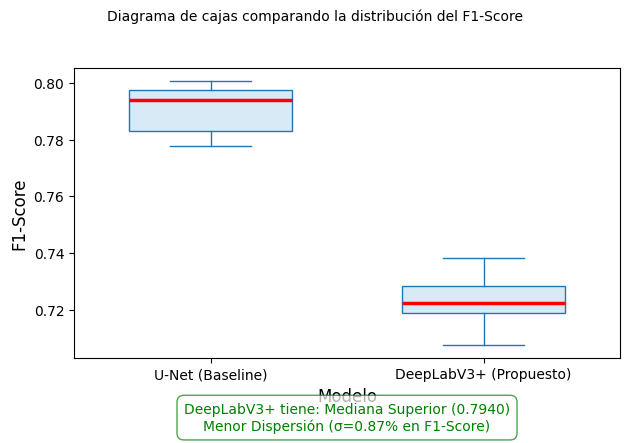

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1. DATOS EXTRAÍDOS DEL LOG DE VALIDACIÓN CRUZADA
unet_f1_scores = [0.7190, 0.7284, 0.7076, 0.7223, 0.7382]
deeplab_f1_scores = [0.7830, 0.8005, 0.7776, 0.7940, 0.7974]


data = {
    'Modelo': ['U-Net'] * len(unet_f1_scores) + ['DeepLabV3+'] * len(deeplab_f1_scores),
    'F1-Score': unet_f1_scores + deeplab_f1_scores
}
df = pd.DataFrame(data)


plt.figure(figsize=(8, 6))


unet_median = np.median(unet_f1_scores)
deeplab_median = np.median(deeplab_f1_scores)
deeplab_std = np.std(deeplab_f1_scores) * 100


bp = df.boxplot(column='F1-Score', by='Modelo', grid=False, patch_artist=True,
                widths=0.6,
                boxprops=dict(facecolor='#D9EAF7', color='#1F77B4'),
                medianprops=dict(color='#FF0000', linewidth=2.5),
                capprops=dict(color='#1F77B4'),
                whiskerprops=dict(color='#1F77B4'))


plt.title('Distribución del F1-Score en las 5 Particiones (Validación Cruzada)', fontsize=14, pad=15)
plt.suptitle('Diagrama de cajas comparando la distribución del F1-Score', fontsize=10)
plt.ylabel('F1-Score', fontsize=12)
plt.xlabel('Modelo', fontsize=12)
plt.xticks(ticks=[1, 2], labels=['U-Net (Baseline)', 'DeepLabV3+ (Propuesto)'])


plt.text(1.5, min(df['F1-Score']) - 0.03,
         f"DeepLabV3+ tiene: Mediana Superior ({deeplab_median:.4f})\nMenor Dispersión (σ={deeplab_std:.2f}% en F1-Score)",
         ha='center', fontsize=10, color='green', bbox=dict(facecolor='white', alpha=0.7, edgecolor='green', boxstyle='round,pad=0.5'))


plt.gca().set_title('')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Guardar la figura
file_name = "Figura_9_1_Diagrama_Cajas_Real.png"
plt.savefig(file_name)
plt.show()